<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# GA Project 4: West Nile Virus Modelling Based on Kaggle Competition

This project is based on a Kaggle dataset project on the **[West Nile Virus][1]**, a virus spread mainly by mosquito and its spread in Chicago over the period of 2007 to 2014. We are tasked with analyzing weather data and GIS data and predicting whether or not West Nile virus is present, for a given time, location, and species.

[1]:https://www.kaggle.com/competitions/predict-west-nile-virus/overview

## Problem Statement

We have been tasked by the Chicago Department of Public Health (CDPH) to study the patterns of mosquito propagation, to see whether **usable insights** can be drawn from the mosquito population data in an effort **to effectively predict the movement of the mosquito population in the city over time**.

We are given a main set of data to train our prediction models on, as well as 2 supplementary datasets that document the pesticide spray schedule and locations over years 2011 and 2013, as well as the overall weather patterns over the same period collected from two weather stations.

(*From Kaggle*)  
"*Every year from late-May to early-October, public health workers in Chicago setup mosquito traps scattered across the city. Every week from Monday through Wednesday, these traps collect mosquitos, and the mosquitos are tested for the presence of West Nile virus before the end of the week. The test results include the number of mosquitos, the mosquitos species, and whether or not West Nile virus is present in the cohort.*"


---
## Contents:
- [Background](#Background)
- [Data Cleaning](#1.0.0-Data-Cleaning)
- [Exploratory Data Analysis](#2.0.0-Exploratory-Data-Analysis)
- [Data Preprocessing](#Data-Preprocessing)
- [Modeling Process](#Modeling-Process)
- [Pycaret Auto ML](#Pycaret-auto-ML)
- [Data Visualization](#Data-Visualization)
- [Conclusions and Recommendations](#Conclusion-and-Recommendation)
---


## Background
The West Nile Virus first appeared in 1937 in Uganda (*[source][1]*), and subsequently appeared on continental America in 1999, making landfall in New York City. In 2002, North America saw the largest outbreak West Nile meningoencephalitis *anywhere* (*[source][2]*), with infections stretching from the Mississippi River in the East to the Pacific Coast in the west.

The virus is transmitted primarily by *Culex Pipiens*, otherwise known as the Northern house mosquito. They thrive in areas with many sources of stagnant water where they can easily breed, such as overgrown ponds, poorly managed waste-effluent lagoons, drainage ditches, or just water collected in natural or artificial catchment containers like cans, bird baths, etc. (*[source][1]*).

[1]:https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3111838/
[2]:https://www.tazewellhealth.org/228/History-of-West-Nile-Virus#:~:text=The%20West%20Nile%20Virus%20(WNV,outbreak%20in%20Israel%20in%201957.

### Summary of Sources (From Kaggle)
1. `train.csv`, `test.csv` - the training and test set of the main dataset. The training set consists of data from 2007, 2009, 2011, and 2013, while in the test set you are requested to predict the test results for 2008, 2010, 2012, and 2014.
<ul>
    <li> Id: the id of the record </li>
    <li> Date: date that the WNV test is performed
    <li> Address: approximate address of the location of trap. This is used to send to the GeoCoder. 
    <li> Species: the species of mosquitos
    <li> Block: block number of address
    <li> Street: street name
    <li> Trap: Id of the trap
    <li> AddressNumberAndStreet: approximate address returned from GeoCoder
    <li> Latitude, Longitude: Latitude and Longitude returned from GeoCoder
    <li> AddressAccuracy: accuracy returned from GeoCoder
    <li> NumMosquitos: number of mosquitoes caught in this trap
    <li> WnvPresent: whether West Nile Virus was present in these mosquitos. 1 means WNV is present, and 0 means not present.  
</ul>
<br/>
2. `spray.csv` - GIS data of spraying efforts in 2011 and 2013  
<ul>
    <li> Date, Time: the date and time of the spray  
    <li> Latitude, Longitude: the Latitude and Longitude of the spray
</ul>
<br/>
3. `weather.csv` - weather data from 2007 to 2014. Column descriptions in [noaa_weather_qclcd_documentation.pdf][1].

[1]: Assets/noaa_weather_qclcd_documentation.pdf

## 0 Imports

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [4]:
from IPython.core.display import HTML
table_css = 'table {align:left;display:block} '
HTML('<style{}</style>'.format(table_css))

In [5]:
train_df = pd.read_csv('./Assets/input/train.csv')
spray_df = pd.read_csv('./Assets/input/spray.csv')
weather_df = pd.read_csv('./Assets/input/weather.csv')
test_df = pd.read_csv('./Assets/input/test.csv')

## 1.0.0 Data Cleaning

### 1.1.0 Cleaning `train.csv`

- *Step1- checking dataframe structure*

In [6]:
print(train_df.shape)
print(train_df.info())
train_df.head()

(10506, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB
None


Date                                            Address  \
0  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2  2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   NumMosquitos  WnvPresent  
0             1           0  
1             1           0  
2             1           0  
3             1           0  
4             4           0

- *Step2- Check for Nan values*

In [7]:
train_df.isna().sum()

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

- *Step3- Change Date columns from object Dtype to Pandas datetime*
    - Split up Date to Year Month Day for EDA later

In [8]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df['Year'] = train_df['Date'].dt.year
train_df['Month'] = train_df['Date'].dt.month
train_df['Day'] = train_df['Date'].dt.day

In [9]:
train_df['Date'].nunique()

95

In [10]:
train_df['Year'].unique()

array([2007, 2009, 2011, 2013], dtype=int64)

In [11]:
train_df['Month'].unique()

array([ 5,  6,  7,  8,  9, 10], dtype=int64)

In [12]:
train_df['Species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

- *Step4- Checking for duplicated rows*
    - Found 2786 duplicated rows using .duplicated function without including 'NumMosquitos', 'WnvPresent' in the subset.

In [13]:
duplicated_rows = train_df[train_df.duplicated(subset = ['Date','Year', 'Month', 'Day','Species', 'Block', 'Street', 'Trap','Latitude', 'Longitude', 'AddressAccuracy'],keep=False)] 
duplicated_rows.shape

(2786, 15)

- *Due to the way it was recorded the total number of mosquito are capped at 50 per row. So as to collapse all rows into 1 row, NumMosquitos and WnvPresent are aggregated and summed by the other columns.*
- *After collapsing 2786 rows become 755*
- *the total number of mosquito captured will not be correctly recorded and in WnvPresent for rows more than 1 count will be counted as virus is present*

In [14]:
agg_dup_rows = duplicated_rows.groupby(['Date','Year', 'Month', 'Day','Species', 'Block', 'Street', 'Trap','Latitude', 'Longitude', 'AddressAccuracy'])[['NumMosquitos','WnvPresent']].sum()
agg_dup_rows = pd.DataFrame(agg_dup_rows).reset_index()
agg_dup_rows.shape

(755, 13)

#### Dropping Duplicated Rows 
- Dropping all 2786 duplicated rows and concat with the newly aggregated rows later

In [15]:
new_train = train_df.drop_duplicates(subset = ['Date','Year', 'Month', 'Day','Species', 'Block', 'Street', 'Trap','Latitude', 'Longitude', 'AddressAccuracy'],keep=False) 
new_train.shape

(7720, 15)

In [16]:
train = train_df.copy()
train_df = pd.concat([new_train,agg_dup_rows], ignore_index=True).set_index('Date').sort_index().reset_index()
train_df.shape

(8475, 15)

#### WnvPresent
- Replacing numbers with 1 and more to 1 to represent virus is present

In [17]:
train_df['WnvPresent'].mask(train_df['WnvPresent'] >=1 ,1, inplace=True)

#### Double Check
- Double checking all numbers in each columns tally to old dataframe

In [18]:
print(train.shape)
print(train_df.shape)

(10506, 15)
(8475, 15)


In [26]:
print(train['WnvPresent'].value_counts(normalize = True))
print(train_df['WnvPresent'].value_counts(normalize = True))

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64
0    0.946077
1    0.053923
Name: WnvPresent, dtype: float64


### 1.2.0 Cleaning `test.csv`

- *Step1- checking dataframe structure*

In [27]:
print(test_df.shape)
print(test_df.info())
test_df.head()

(116293, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      116293 non-null  int64  
 1   Date                    116293 non-null  object 
 2   Address                 116293 non-null  object 
 3   Species                 116293 non-null  object 
 4   Block                   116293 non-null  int64  
 5   Street                  116293 non-null  object 
 6   Trap                    116293 non-null  object 
 7   AddressNumberAndStreet  116293 non-null  object 
 8   Latitude                116293 non-null  float64
 9   Longitude               116293 non-null  float64
 10  AddressAccuracy         116293 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB
None


Id        Date                                            Address  \
0   1  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1   2  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2   3  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
3   4  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
4   5  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2           CULEX PIPIENS     41   N OAK PARK AVE  T002   
3        CULEX SALINARIUS     41   N OAK PARK AVE  T002   
4         CULEX TERRITANS     41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
1  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
2  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
3  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
4  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9

- *Step2- Check for Nan values*

In [28]:
test_df.isna().sum()

Id                        0
Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
dtype: int64

- *Step3- Change Date columns from object Dtype to Pandas datetime*
    - Split up Date to Year Month Day for EDA later

In [29]:
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df['Year'] = test_df['Date'].dt.year
test_df['Month'] = test_df['Date'].dt.month
test_df['Day'] = test_df['Date'].dt.day

- *Step4- check for duplicated rows*

In [30]:
test_df[test_df.duplicated(keep= False)]

Empty DataFrame
Columns: [Id, Date, Address, Species, Block, Street, Trap, AddressNumberAndStreet, Latitude, Longitude, AddressAccuracy, Year, Month, Day]
Index: []

In [31]:
test_df.columns

Index(['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'Year', 'Month', 'Day'],
      dtype='object')

In [32]:
# Check which Columns are missing
set(train_df.columns)-set(test_df.columns)

{'NumMosquitos', 'WnvPresent'}

### 1.3.0 Cleaning `spray.csv`

Step1- checking dataframe structure

In [33]:
print(spray_df.shape)
print(spray_df.info())
spray_df.head()

(14835, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB
None


Date        Time   Latitude  Longitude
0  2011-08-29  6:56:58 PM  42.391623 -88.089163
1  2011-08-29  6:57:08 PM  42.391348 -88.089163
2  2011-08-29  6:57:18 PM  42.391022 -88.089157
3  2011-08-29  6:57:28 PM  42.390637 -88.089158
4  2011-08-29  6:57:38 PM  42.390410 -88.088858

- *Step2- Check for Nan values*

In [34]:
spray_df.isna().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

- *Step3- Change Date columns from object Dtype to Pandas datetime*
    - Split up Date to Year Month Day for EDA later

In [35]:
# 'Date' should be in datetime format
spray_df['Date'] = pd.to_datetime(spray_df['Date'])

In [36]:
spray_df['Year'] = spray_df['Date'].dt.year
spray_df['Month'] = spray_df['Date'].dt.month
spray_df['Day'] = spray_df['Date'].dt.day

In [37]:
# check that spray data is given for 2011 and 2013
spray_df['Year'].unique()

array([2011, 2013], dtype=int64)

In [38]:
spray_df['Month'].value_counts()

8    7988
7    3809
9    3038
Name: Month, dtype: int64

- *Step4- check for duplicated rows*

In [39]:
spray_df[spray_df.duplicated()]

Date        Time   Latitude  Longitude  Year  Month  Day
485  2011-09-07  7:43:40 PM  41.983917 -87.793088  2011      9    7
490  2011-09-07  7:44:32 PM  41.986460 -87.794225  2011      9    7
491  2011-09-07  7:44:32 PM  41.986460 -87.794225  2011      9    7
492  2011-09-07  7:44:32 PM  41.986460 -87.794225  2011      9    7
493  2011-09-07  7:44:32 PM  41.986460 -87.794225  2011      9    7
...         ...         ...        ...        ...   ...    ...  ...
1025 2011-09-07  7:44:32 PM  41.986460 -87.794225  2011      9    7
1026 2011-09-07  7:44:32 PM  41.986460 -87.794225  2011      9    7
1027 2011-09-07  7:44:32 PM  41.986460 -87.794225  2011      9    7
1028 2011-09-07  7:44:32 PM  41.986460 -87.794225  2011      9    7
1029 2011-09-07  7:44:32 PM  41.986460 -87.794225  2011      9    7

[541 rows x 7 columns]

In [40]:
spray_df.drop_duplicates(inplace = True)

- *Step5- Drop irrelevent columns*

In [41]:
# there are nulls in the Time column
# since Time column is not useful, it will be dropped as a whole to maintain the integrity of the rest of the data
spray_df.drop(['Time'],axis = 1, inplace = True)

### 1.4.0 Cleaning `weather.csv`
*documentation: [noaa_weather_qclcd_documentation.pdf][1]*

[1]: Assets/noaa_weather_qclcd_documentation.pdf

In [42]:
# scan through Dtypes
weather_df.dtypes

Station          int64
Date            object
Tmax             int64
Tmin             int64
Tavg            object
Depart          object
DewPoint         int64
WetBulb         object
Heat            object
Cool            object
Sunrise         object
Sunset          object
CodeSum         object
Depth           object
Water1          object
SnowFall        object
PrecipTotal     object
StnPressure     object
SeaLevel        object
ResultSpeed    float64
ResultDir        int64
AvgSpeed        object
dtype: object

In [43]:
# check weather data structure
print(weather_df.shape)
weather_df.head()

(2944, 22)


Station        Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1  2007-05-01    83    50   67     14        51      56    0    2   
1        2  2007-05-01    84    52   68      M        51      57    0    3   
2        1  2007-05-02    59    42   51     -3        42      47   14    0   
3        2  2007-05-02    60    43   52      M        42      47   13    0   
4        1  2007-05-03    66    46   56      2        40      48    9    0   

   ... CodeSum Depth Water1 SnowFall PrecipTotal StnPressure SeaLevel  \
0  ...             0      M      0.0        0.00       29.10    29.82   
1  ...             M      M        M        0.00       29.18    29.82   
2  ...      BR     0      M      0.0        0.00       29.38    30.09   
3  ...   BR HZ     M      M        M        0.00       29.44    30.08   
4  ...             0      M      0.0        0.00       29.39    30.12   

  ResultSpeed ResultDir  AvgSpeed  
0         1.7        27       9.2  
1         2.7        25       9.6  
2        13.0         4      13.4  
3        13.3         2      13.4  
4        11.7         7      11.9  

[5 rows x 22 columns]

In [44]:
# check for Na
weather_df.isna().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
Water1         0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

In [45]:
# check for 'M'. info declared in weather documentation
weather_df[weather_df == 'M'].count()

Station           0
Date              0
Tmax              0
Tmin              0
Tavg             11
Depart         1472
DewPoint          0
WetBulb           4
Heat             11
Cool             11
Sunrise           0
Sunset            0
CodeSum           0
Depth          1472
Water1         2944
SnowFall       1472
PrecipTotal       2
StnPressure       4
SeaLevel          9
ResultSpeed       0
ResultDir         0
AvgSpeed          3
dtype: int64

In [46]:
# check for 'T'. info declared in weather documentation
weather_df[weather_df == '  T'].count()

Station          0
Date             0
Tmax             0
Tmin             0
Tavg             0
Depart           0
DewPoint         0
WetBulb          0
Heat             0
Cool             0
Sunrise          0
Sunset           0
CodeSum          0
Depth            0
Water1           0
SnowFall        12
PrecipTotal    318
StnPressure      0
SeaLevel         0
ResultSpeed      0
ResultDir        0
AvgSpeed         0
dtype: int64

In [47]:
# check for 'M'. info declared in weather documentation
weather_df[weather_df == '-'].count()

Station           0
Date              0
Tmax              0
Tmin              0
Tavg              0
Depart            0
DewPoint          0
WetBulb           0
Heat              0
Cool              0
Sunrise        1472
Sunset         1472
CodeSum           0
Depth             0
Water1            0
SnowFall          0
PrecipTotal       0
StnPressure       0
SeaLevel          0
ResultSpeed       0
ResultDir         0
AvgSpeed          0
dtype: int64

In [48]:
# check duplicated
weather_df.duplicated().any()

False

- **Station**

In [49]:
# verify that there are 2 stations
weather_df['Station'].unique()

array([1, 2], dtype=int64)

In [50]:
# double check Dtypes
weather_df['Station'].dtypes

dtype('int64')

- **Date**

In [51]:
# 'Date' should be in datetime format
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

In [52]:
# double check Dtypes
weather_df['Date'].dtypes

dtype('<M8[ns]')

- **Tmin**

In [53]:
weather_df['Tmin'].unique()

array([50, 52, 42, 43, 46, 48, 49, 51, 53, 54, 47, 60, 61, 63, 56, 59, 44,
       57, 45, 55, 66, 65, 70, 68, 62, 67, 64, 58, 71, 69, 73, 75, 72, 74,
       39, 41, 40, 37, 34, 38, 35, 36, 33, 31, 32, 76, 77, 29, 78, 79, 80,
       81, 82, 83], dtype=int64)

In [54]:
# double check Dtypes
weather_df['Tmin'].dtypes

dtype('int64')

- **Tmax**

In [55]:
weather_df['Tmax'].unique()

array([ 83,  84,  59,  60,  66,  67,  78,  68,  82,  80,  77,  76,  70,
        73,  64,  65,  69,  90,  62,  61,  71,  79,  87,  89,  88,  75,
        85,  86,  81,  72,  63,  91,  92,  93,  74,  94,  54,  53,  56,
        57,  58,  55,  50,  95,  52,  47,  45,  51,  48,  44,  49,  46,
        96,  99, 100, 101,  97,  98, 102, 103, 104,  42,  41], dtype=int64)

In [56]:
# double check Dtypes
weather_df['Tmax'].dtypes

dtype('int64')

- **Trange**

In [57]:
#Temp Range (Max - Min)
weather_df['Trange'] = weather_df['Tmax'] - weather_df['Tmin']

In [58]:
# double check Dtypes
weather_df['Trange'].dtypes

dtype('int64')

- **Tavg**

In [59]:
weather_df['Tavg'].unique()

array(['67', '68', '51', '52', '56', '58', 'M', '60', '59', '65', '70',
       '69', '71', '61', '55', '57', '73', '72', '53', '62', '63', '74',
       '75', '78', '76', '77', '66', '80', '64', '81', '82', '79', '85',
       '84', '83', '50', '49', '46', '48', '45', '54', '47', '44', '40',
       '41', '38', '39', '42', '37', '43', '86', '87', '89', '92', '88',
       '91', '93', '94', '90', '36'], dtype=object)

In [60]:
weather_df['Tavg'] = np.where(weather_df['Tavg'] == 'M', round((weather_df['Tmax'] + weather_df['Tmin'])/2) , weather_df['Tavg'])
weather_df['Tavg'] = weather_df['Tavg'].astype('int64')

In [61]:
# double check Dtypes
weather_df['Tavg'].dtypes

dtype('int64')

- **Depart**

Deviation from temp average

In [62]:
weather_df['Depart'].unique()

array(['14', 'M', '-3', ' 2', ' 4', ' 5', '10', '12', '13', '-2', '15',
       '11', '-4', '-6', ' 8', '-5', ' 1', ' 9', ' 6', '-9', '-8', ' 3',
       ' 0', '-1', '-7', ' 7', '-14', '18', '16', '22', '21', '20', '-10',
       '-16', '17', '-12', '-11', '-15', '-17', '19', '-13', '23'],
      dtype=object)

In [63]:
# get normal tempreture from station1
station1_normtemp = weather_df[(weather_df['Station'] == 1)].copy().set_index('Date')['Tavg'].astype('int64'
                    ) -weather_df[(weather_df['Station'] == 1)].copy().set_index('Date')['Depart'].astype('int64')

In [64]:
# extract Station2 fom weather
station2 = weather_df[(weather_df['Station'] == 2)].copy().set_index('Date')

In [65]:
# impute M in Station2 depart columns (Tavg - Station1_normtemp)
depart_lis = []
for index in station2.index:
    if station2.loc[index]['Depart'] =='M':
        temp_depart = station2.loc[index]['Tavg'] - station1_normtemp.loc[index]
        depart_lis.append(temp_depart)
    else:
        depart_lis.append(station2.loc[index]['Depart'])
station2['Depart'] = pd.Series(depart_lis,name = 'Depart',index = station2.index)

In [66]:
# prepare to merge
station2 = station2.reset_index().set_index(['Station','Date'])

In [67]:
# merge to weather
weather_df.set_index(['Station','Date'], inplace=True)
weather_df.update(station2)
weather_df.reset_index(inplace=True)
weather_df['Depart'] = weather_df['Depart'].astype('int64')

In [68]:
# double check Dtypes
weather_df['Depart'].dtypes

dtype('int64')

- **RHumidity**

In [69]:
Tavg_C = ((weather_df['Tavg'] - 32) * 5 / 9) #temperature in celcius
DewPoint_C = ((weather_df['DewPoint'] - 32) * 5 / 9) #dewpoint in celcius
RH =100*(np.exp((17.625*DewPoint_C)/(243.04+DewPoint_C))/np.exp((17.625*Tavg_C)/(243.04+Tavg_C)))
weather_df['RHumidity']= RH # add in Rhumidity

In [70]:
# double check Dtypes
weather_df['RHumidity'].dtypes

dtype('float64')

- **DewPoint** 

The dew point is the temperature the air needs to be cooled to (at constant pressure) in order to achieve a relative humidity (RH) of 100%. At this point the air cannot hold more water in the gas form

In [71]:
weather_df['DewPoint'].unique()

array([51., 42., 40., 41., 38., 39., 30., 58., 57., 59., 60., 52., 44.,
       36., 37., 33., 32., 47., 45., 56., 43., 31., 50., 46., 49., 48.,
       54., 53., 55., 61., 63., 62., 64., 65., 66., 67., 69., 70., 68.,
       71., 72., 73., 35., 34., 29., 27., 28., 23., 24., 25., 22., 26.,
       75., 74.])

In [72]:
# double check Dtypes
weather_df['DewPoint'].dtypes

dtype('float64')

- **WetBulb**

a measure of the heat stress in direct sunlight, which takes into account: temperature, humidity, wind speed, sun angle and cloud cover (solar radiation)

In [73]:
weather_df['WetBulb'].unique()

array(['56', '57', '47', '48', '50', '49', '46', '54', '53', '62', '63',
       '60', '61', '51', '59', '58', '43', '44', '45', '65', '66', '67',
       '64', '52', '55', '69', '68', '70', '72', '71', '73', '74', '76',
       '42', '39', '40', '41', '35', '33', '34', 'M', '75', '36', '32',
       '38', '78', '77', '37'], dtype=object)

In [74]:
weather_df[weather_df['WetBulb'] =='M']

Station       Date  Tmax  Tmin  Tavg  Depart  DewPoint WetBulb Heat  \
848         1 2009-06-26  86.0  69.0  78.0       7      60.0       M    0   
2410        1 2013-08-10  81.0  64.0  73.0       0      57.0       M    0   
2412        1 2013-08-11  81.0  60.0  71.0      -2      61.0       M    0   
2415        2 2013-08-12  85.0  69.0  77.0       4      63.0       M    0   

     Cool  ... Water1 SnowFall PrecipTotal StnPressure SeaLevel ResultSpeed  \
848    13  ...      M      0.0        0.00           M    29.85         6.4   
2410    8  ...      M      0.0        0.00           M    30.08         5.3   
2412    6  ...      M      0.0        0.01       29.35    30.07         2.0   
2415   12  ...      M        M        0.66       29.27    29.92         4.5   

     ResultDir AvgSpeed Trange  RHumidity  
848        4.0      8.2   17.0  53.971258  
2410       5.0      6.5   17.0  57.262967  
2412      27.0      3.0   21.0  70.686917  
2415      26.0      7.7   16.0  62.027888  

[4 rows x 24 columns]

In [75]:
# Extract Station1 & Station2 data
station1_wetbulb = weather_df[(weather_df['Station'] == 1)].copy().set_index('Date')
station2_wetbulb = weather_df[(weather_df['Station'] == 2)].copy().set_index('Date')

In [76]:
#impute station 1/2 missing data
weather_df.at[848, 'WetBulb'] = station2_wetbulb.loc['2009-06-26']['WetBulb']
weather_df.at[2410, 'WetBulb'] = station2_wetbulb.loc['2013-08-10']['WetBulb']
weather_df.at[2412, 'WetBulb'] = station2_wetbulb.loc['2013-08-11']['WetBulb']
weather_df.at[2415, 'WetBulb'] = station1_wetbulb.loc['2013-08-12']['WetBulb']

In [77]:
weather_df['WetBulb'] = weather_df['WetBulb'].astype('int64')

In [78]:
# double check Dtypes
weather_df['WetBulb'].dtypes

dtype('int64')

- **Heat**

In [79]:
weather_df['Heat'].unique()

array(['0', '14', '13', '9', '7', 'M', '5', '6', '4', '10', '8', '12',
       '3', '2', '1', '15', '16', '19', '17', '20', '11', '18', '21',
       '25', '24', '27', '26', '23', '28', '22', '29'], dtype=object)

In [80]:
weather_df[weather_df['Heat'] =='M']['Heat'].count()

11

In [81]:
station1_heat = weather_df[(weather_df['Station'] == 1)].copy().set_index('Date')['Heat']
station2_heat = weather_df[(weather_df['Station'] == 2)].copy().set_index('Date')

In [82]:
#impute station 2 missing data
heat_lis=[]
for index in station2_heat.index:
    if station2_heat.loc[index]['Heat'] =='M':
        temp_heat = station1_heat.loc[index]
        heat_lis.append(temp_heat)
    else:
        heat_lis.append(station2_heat.loc[index]['Heat'])
station2_heat['Heat'] = pd.Series(heat_lis,name = 'Heat',index = station2_heat.index)

In [83]:
# prepare to merge
station2_heat = station2_heat.reset_index().set_index(['Station','Date'])

In [84]:
# merge to weather
weather_df.set_index(['Station','Date'], inplace=True)
weather_df.update(station2_heat)
weather_df.reset_index(inplace=True)
weather_df['Heat'] = weather_df['Heat'].astype('int64')

In [85]:
# double check Dtypes
weather_df['Heat'].dtypes

dtype('int64')

- **Cool**

In [86]:
weather_df['Cool'].unique()

array([' 2', ' 3', ' 0', 'M', ' 5', ' 4', ' 6', ' 8', ' 7', ' 9', '10',
       '13', '11', '12', ' 1', '15', '16', '17', '14', '20', '19', '18',
       '21', '22', '24', '27', '23', '26', '28', '29', '25'], dtype=object)

In [87]:
weather_df[weather_df['Cool'] =='M']['Heat'].count()

11

In [88]:
# Extract Station1 & Station2 data
station1_cool = weather_df[(weather_df['Station'] == 1)].copy().set_index('Date')['Cool']
station2_cool = weather_df[(weather_df['Station'] == 2)].copy().set_index('Date')

In [89]:
#impute station 2 missing data
cool_lis=[]
for index in station2_cool.index:
    if station2_cool.loc[index]['Cool'] =='M':
        temp_cool = station1_cool.loc[index]
        cool_lis.append(temp_cool)
    else:
        cool_lis.append(station2_cool.loc[index]['Cool'])
station2_cool['Cool'] = pd.Series(cool_lis,name = 'Cool',index = station2_cool.index)

In [90]:
# prepare to merge
station2_cool = station2_cool.reset_index().set_index(['Station','Date'])

In [91]:
# merge to weather
weather_df.set_index(['Station','Date'], inplace=True)
weather_df.update(station2_cool)
weather_df.reset_index(inplace=True)
weather_df['Cool'] = weather_df['Cool'].astype('int64')

In [92]:
# double check Dtypes
weather_df['Cool'].dtypes

dtype('int64')

- **Sunrise and Sunset**

In [93]:
weather_df['Sunrise'].unique()

array(['0448', '-', '0447', '0446', '0444', '0443', '0442', '0441',
       '0439', '0438', '0437', '0436', '0435', '0434', '0433', '0432',
       '0431', '0430', '0429', '0428', '0427', '0426', '0425', '0424',
       '0423', '0422', '0421', '0420', '0419', '0418', '0417', '0416',
       '0440', '0445', '0449', '0450', '0451', '0452', '0453', '0454',
       '0455', '0456', '0457', '0458', '0459', '0500', '0501', '0502',
       '0503', '0504', '0505', '0506', '0508', '0509', '0510', '0511',
       '0512', '0513', '0514', '0515', '0516', '0517', '0518', '0519',
       '0520', '0521', '0522', '0523', '0524', '0525', '0526', '0527',
       '0528', '0529', '0530', '0531', '0532', '0533', '0535', '0536',
       '0537', '0538', '0539', '0540', '0541', '0542', '0543', '0544',
       '0545', '0546', '0547', '0548', '0549', '0550', '0552', '0553',
       '0554', '0555', '0556', '0557', '0558', '0559', '0600', '0602',
       '0603', '0604', '0605', '0606', '0607', '0608', '0610', '0611',
       '0

In [94]:
weather_df['Sunset'].unique()

array(['1849', '-', '1850', '1851', '1852', '1853', '1855', '1856',
       '1857', '1858', '1859', '1860', '1901', '1902', '1903', '1904',
       '1905', '1906', '1907', '1908', '1909', '1910', '1911', '1912',
       '1913', '1914', '1915', '1916', '1917', '1918', '1919', '1920',
       '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928',
       '1929', '1930', '1931', '1900', '1854', '1848', '1846', '1845',
       '1843', '1842', '1840', '1839', '1837', '1835', '1834', '1832',
       '1831', '1829', '1827', '1826', '1824', '1822', '1821', '1819',
       '1817', '1815', '1814', '1812', '1810', '1809', '1807', '1805',
       '1803', '1760', '1758', '1756', '1755', '1753', '1751', '1749',
       '1748', '1746', '1744', '1742', '1741', '1739', '1737', '1735',
       '1734', '1732', '1730', '1729', '1727', '1725', '1724', '1722',
       '1720', '1719', '1717', '1715', '1714', '1712', '1711', '1709',
       '1707', '1706', '1704', '1703', '1701', '1660', '1658', '1657',
       '1

In [95]:
# Missing data in 'Sunrise' and'Sunset', these are not flagged out as nulls as they are filled with '-'.
# The missing data are observed in 'Station 2'. Since stations 1 and 2 are in close proximity, we will imput the missing data with measurement from Station 1
sunrise_df = weather_df[weather_df['Station']==1][['Date', 'Sunrise']]
sunset_df = weather_df[weather_df['Station']==1][['Date', 'Sunset']]

In [96]:
# Drop the sunrise and sunset columns
weather_df.drop(columns=['Sunrise', 'Sunset'], inplace=True)

In [97]:
# Merge weather data set with sunrise and sunset data based on date
weather_df = weather_df.merge(sunrise_df, how='left', on='Date')
weather_df = weather_df.merge(sunset_df, how='left', on='Date')

In [98]:
# Not able to convert sunset timing to required datetime format, check for error in sunset timing. 
sunset_time=[]

for i, time in enumerate(weather_df["Sunset"]):
    if int(time[2:4]) > 59:
        sunset_time.append(time)

In [99]:
# Correct errorneous sunset time
for i, t in enumerate(weather_df["Sunset"]):
    if t=='1660':
        weather_df.loc[i, "Sunset"] = '1700'
    elif t=='1760':
        weather_df.loc[i, "Sunset"] = '1800'
    elif t=='1860':
        weather_df.loc[i, "Sunset"] = '1800'

In [100]:
weather_df['Sunrise'] =pd.to_datetime(weather_df['Sunrise'], format='%H%M')
weather_df['Sunset'] =pd.to_datetime(weather_df['Sunset'], format='%H%M')

In [101]:
# double check Dtypes
weather_df['Sunrise'].dtype

dtype('<M8[ns]')

In [102]:
# double check Dtypes
weather_df['Sunset'].dtype

dtype('<M8[ns]')

- **CodeSum**

In [103]:
weather_df['CodeSum'].unique()

array([' ', 'BR', 'BR HZ', 'HZ', 'RA', 'RA BR', 'TSRA RA BR', 'RA VCTS',
       'TSRA RA', 'RA HZ', 'TSRA RA BR HZ', 'TSRA BR HZ', 'RA BR HZ VCTS',
       'TSRA RA HZ', 'TSRA BR HZ VCTS', 'TSRA', 'TSRA BR HZ FU',
       'TSRA RA HZ FU', 'BR HZ FU', 'TSRA RA VCTS', 'HZ VCTS', 'TSRA HZ',
       'VCTS', 'RA BR VCTS', 'TSRA RA BR VCTS', 'TS TSRA RA BR HZ VCTS',
       'DZ BR', 'TS TSRA RA BR HZ', 'TS TSRA BR HZ', 'RA BR HZ',
       'TSRA RA DZ BR HZ', 'TS TSRA RA BR', 'TS RA BR', 'TS TSRA RA',
       'TS TSRA RA BR VCTS', 'TS TSRA BR', 'TS RA', 'RA BCFG BR',
       'TSRA BR', 'RA DZ FG+ BCFG BR', 'RA FG+ MIFG BR', 'RA DZ',
       'RA DZ BR', 'TS TSRA RA HZ', 'TSRA RA FG+ FG BR',
       'TSRA DZ FG+ FG BR HZ', 'TS BR', 'RA BR SQ', 'TS TSRA',
       'TSRA RA BR HZ VCTS', 'BR VCTS', 'TS', 'FG+ BR HZ', 'RA SN',
       'TSRA RA DZ BR', 'DZ BR HZ', 'RA BR FU', 'TS BR HZ', 'DZ',
       'FG+ BR', 'FG+ FG BR', 'FG+ MIFG BR', 'TSRA RA FG BR',
       'TSRA FG+ BR', 'RA DZ BR HZ', 'RA DZ SN', 'FG+ FG 

In [104]:
# get unique code
code_lis = weather_df['CodeSum'].unique()
code = []
for item in code_lis:
    code = code + item.split()
master_code = set(code)

In [105]:
# make new code columns
for name in master_code:
    weather_df.insert(11,name,0, True)

In [106]:
weather_df['CodeSum'] = weather_df['CodeSum'].str.split()

In [107]:
for idx in weather_df['CodeSum'].index:
    split = weather_df.at[idx, 'CodeSum']
    for code in split:
        weather_df.at[idx, code] = 1

In [108]:
weather_df.drop(['CodeSum'],axis =1,inplace = True)

- **Depth**

Drop depth due to insufficient data from both stations

In [109]:
weather_df['Depth'].unique()

array(['0', 'M'], dtype=object)

In [110]:
weather_df[weather_df['Depth'] =='M']['Depth'].count()

1472

In [111]:
weather_df[(weather_df['Depth'] =='M') & (weather_df['Station'] ==1)]['Depth'].count()

0

In [112]:
weather_df[(weather_df['Depth'] =='M') & (weather_df['Station'] ==2)]['Depth'].count()

1472

In [113]:
weather_df.drop(['Depth'],axis =1,inplace = True)

- **Water1**

Drop water1 due to no data

In [114]:
weather_df['Water1'].unique()

array(['M'], dtype=object)

In [115]:
weather_df[weather_df['Water1'] =='M']['Water1'].count()

2944

In [116]:
weather_df.drop(['Water1'],axis =1,inplace = True)

- **SnowFall**

Drop SnowFall due to low data variations

In [117]:
weather_df['SnowFall'].unique()

array(['0.0', 'M', '  T', '0.1'], dtype=object)

In [118]:
weather_df[weather_df['SnowFall'] =='M']['SnowFall'].count()

1472

In [119]:
weather_df[weather_df['SnowFall'] =='  T']['SnowFall'].count()

12

In [120]:
weather_df.drop(['SnowFall'],axis =1,inplace = True)

- **PrecipTotal**

In [121]:
weather_df['PrecipTotal'].unique()

array(['0.00', '  T', '0.13', '0.02', '0.38', '0.60', '0.14', '0.07',
       '0.11', '0.09', '1.01', '0.28', '0.04', '0.08', '0.01', '0.53',
       '0.19', '0.21', '0.32', '0.39', '0.31', '0.42', '0.27', '0.16',
       '0.58', '0.93', '0.05', '0.34', '0.15', '0.35', 'M', '0.40',
       '0.66', '0.30', '0.24', '0.43', '1.55', '0.92', '0.89', '0.17',
       '0.03', '1.43', '0.97', '0.26', '1.31', '0.06', '0.46', '0.29',
       '0.23', '0.41', '0.45', '0.83', '1.33', '0.91', '0.48', '0.37',
       '0.88', '2.35', '1.96', '0.20', '0.25', '0.18', '0.67', '0.36',
       '0.33', '1.28', '0.74', '0.76', '0.71', '0.95', '1.46', '0.12',
       '0.52', '0.64', '0.22', '1.24', '0.72', '0.73', '0.65', '1.61',
       '1.22', '0.50', '1.05', '2.43', '0.59', '2.90', '2.68', '1.23',
       '0.62', '6.64', '3.07', '1.44', '1.75', '0.82', '0.80', '0.86',
       '0.63', '0.55', '1.03', '0.70', '1.73', '1.38', '0.44', '1.14',
       '1.07', '3.97', '0.87', '0.78', '1.12', '0.68', '0.10', '0.61',
       '0.

- Since ' T' represents TRACE replace with 0.005 ([*source*](https://wgntv.com/weather/what-are-traces-of-precipitation/#:~:text=%E2%80%9CTrace%E2%80%9D%20amounts%20are%20defined%20as,that%20amount%20(0.05%20inches)))


In [122]:
# impute ' T' with 0.005 
weather_df.replace('  T', 0.005, inplace =True)

In [123]:
# for 'M' in PrecipTotal columns
weather_df[weather_df['PrecipTotal'] == 'M']

Station       Date  Tmax  Tmin  Tavg  Depart  DewPoint  WetBulb  Heat  \
117        2 2007-06-28  73.0  61.0  67.0    -4.0      56.0     61.0   0.0   
119        2 2007-06-29  71.0  56.0  64.0    -7.0      56.0     60.0   1.0   

     Cool  ...  PrecipTotal  StnPressure  SeaLevel  ResultSpeed  ResultDir  \
117     2  ...            M        29.43     30.07         12.2        2.0   
119     0  ...            M        29.47     30.11          7.4        2.0   

     AvgSpeed  Trange  RHumidity             Sunrise              Sunset  
117      13.3    12.0  67.773364 1900-01-01 04:19:00 1900-01-01 19:31:00  
119       8.2    15.0  75.222665 1900-01-01 04:19:00 1900-01-01 19:31:00  

[2 rows x 36 columns]

In [124]:
# Extract station1 from weather
station1_PrecipTotal = weather_df[(weather_df['Station'] == 1)].copy().set_index('Date')

# impute 'M' with station 1 data
weather_df.at[117, "PrecipTotal"] = station1_PrecipTotal.loc['2007-06-28']['PrecipTotal']
weather_df.at[119, "PrecipTotal"] = station1_PrecipTotal.loc['2007-06-29']['PrecipTotal']

In [125]:
weather_df['PrecipTotal'] = weather_df['PrecipTotal'].astype('float64')

In [126]:
# double check Dtypes
weather_df['PrecipTotal'].dtypes

dtype('float64')

- **StnPressure**

In [127]:
weather_df['StnPressure'].unique()

array(['29.10', '29.18', '29.38', '29.44', '29.39', '29.46', '29.31',
       '29.36', '29.40', '29.57', '29.62', '29.29', '29.21', '29.28',
       '29.20', '29.26', '29.33', '29.49', '29.54', '29.55', '29.23',
       '29.13', '29.19', '29.53', '29.60', '29.34', '29.41', '29.47',
       '29.51', '29.42', '29.43', '29.25', '29.03', '28.82', '28.87',
       '28.88', '29.16', '29.07', '28.84', '28.91', '29.24', 'M', '29.30',
       '29.12', '29.45', '29.56', '29.32', '29.05', '29.11', '29.06',
       '29.22', '29.08', '29.14', '29.37', '29.35', '29.15', '29.17',
       '29.48', '29.52', '29.27', '29.50', '28.59', '28.67', '28.75',
       '29.02', '29.79', '29.86', '29.63', '29.70', '28.95', '29.01',
       '28.79', '28.85', '28.97', '28.89', '28.94', '28.93', '28.98',
       '28.96', '29.00', '29.66', '29.09', '28.90', '29.04', '29.59',
       '29.65', '29.58', '29.61', '29.64', '29.71', '29.67', '28.80',
       '28.73', '29.68', '28.74', '28.55', '28.63', '28.92', '28.99',
       '28.81',

In [128]:
weather_df[weather_df['StnPressure'] == 'M']

Station       Date  Tmax  Tmin  Tavg  Depart  DewPoint  WetBulb  Heat  \
87          2 2007-06-13  86.0  68.0  77.0     9.0      53.0     62.0   0.0   
848         1 2009-06-26  86.0  69.0  78.0     7.0      60.0     67.0   0.0   
2410        1 2013-08-10  81.0  64.0  73.0     0.0      57.0     63.0   0.0   
2411        2 2013-08-10  81.0  68.0  75.0     2.0      55.0     63.0   0.0   

      Cool  ...  PrecipTotal  StnPressure  SeaLevel  ResultSpeed  ResultDir  \
87      12  ...          0.0            M         M          7.0        5.0   
848     13  ...          0.0            M     29.85          6.4        4.0   
2410     8  ...          0.0            M     30.08          5.3        5.0   
2411    10  ...          0.0            M     30.07          6.0        6.0   

      AvgSpeed  Trange  RHumidity             Sunrise              Sunset  
87           M    18.0  43.319099 1900-01-01 04:16:00 1900-01-01 19:27:00  
848        8.2    17.0  53.971258 1900-01-01 04:18:00 1900-01-01 19:31:00  
2410       6.5    17.0  57.262967 1900-01-01 04:54:00 1900-01-01 19:00:00  
2411       7.4    13.0  49.807306 1900-01-01 04:54:00 1900-01-01 19:00:00  

[4 rows x 36 columns]

In [129]:
station1_pa = weather_df[(weather_df['Station'] == 1)].copy().set_index('Date')
station2_pa = weather_df[(weather_df['Station'] == 2)].copy().set_index('Date')

In [130]:
#impute station 1/2 missing data
weather_df.at[87, 'StnPressure'] = station1_wetbulb.loc['2007-06-13']['StnPressure']
weather_df.at[848, 'StnPressure'] = station2_wetbulb.loc['2009-06-26']['StnPressure']
weather_df.at[2410, 'StnPressure'] = station2_wetbulb.loc['2013-08-09']['StnPressure']
weather_df.at[2411, 'StnPressure'] = station1_wetbulb.loc['2013-08-09']['StnPressure']

In [131]:
weather_df['StnPressure'] = weather_df['StnPressure'].astype('float64')

In [132]:
weather_df['StnPressure'].dtypes

dtype('float64')

- **SeaLevel**

In [133]:
weather_df['SeaLevel'].unique()

array(['29.82', '30.09', '30.08', '30.12', '30.05', '30.04', '30.10',
       '30.29', '30.28', '30.03', '30.02', '29.94', '29.93', '29.92',
       '29.91', '30.20', '30.19', '30.24', '29.97', '29.98', '29.84',
       '29.83', '30.27', '30.25', '30.26', '30.11', '30.06', '30.23',
       '30.15', '30.14', '30.00', '29.99', '29.90', '29.77', '29.76',
       '29.56', '29.54', '29.52', '29.51', '29.79', '29.78', '29.81',
       '29.55', '29.85', '30.07', '30.16', 'M', '29.96', '29.95', '30.13',
       '30.21', '30.22', '29.88', '30.01', '29.80', '29.89', '29.74',
       '29.87', '29.86', '30.18', '30.17', '29.34', '29.44', '29.45',
       '29.71', '29.72', '30.52', '30.53', '30.40', '30.41', '29.67',
       '29.53', '29.69', '29.61', '29.64', '29.63', '29.66', '29.70',
       '30.34', '30.33', '29.62', '29.60', '29.75', '29.68', '29.73',
       '30.31', '30.30', '30.32', '30.37', '30.39', '29.59', '29.65',
       '30.35', '30.36', '29.48', '30.38', '29.50', '29.25', '29.23',
       '29.46',

In [134]:
sea_toimpute = weather_df[weather_df['SeaLevel'] == 'M']

In [135]:
station1_sea = weather_df[(weather_df['Station'] == 1)].copy().set_index('Date')
station2_sea = weather_df[(weather_df['Station'] == 2)].copy().set_index('Date')

In [136]:
for index in sea_toimpute.index:
    if sea_toimpute.at[index, 'Station'] == 1:
        weather_df.at[index, 'SeaLevel'] = station2_sea.loc[sea_toimpute.at[index, 'Date']]['SeaLevel']
    if sea_toimpute.at[index, 'Station'] == 2:
        weather_df.at[index, 'SeaLevel'] = station1_sea.loc[sea_toimpute.at[index, 'Date']]['SeaLevel']

In [137]:
weather_df['SeaLevel'] = weather_df['SeaLevel'].astype('float64')

In [138]:
weather_df['SeaLevel'].dtypes

dtype('float64')

- **ResultSpeed**

In [139]:
weather_df['ResultSpeed'].unique()

array([ 1.7,  2.7, 13. , 13.3, 11.7, 12.9, 10.4, 10.1, 11.2, 14.4, 13.8,
        8.6,  8.5,  2.5,  3.9,  0.7,  2. , 11.3, 12.4, 12.7,  6.6,  6.4,
       16.9, 14.1,  8.1,  7.8,  8. , 10.5,  5.4,  3.4, 11.1,  6.3, 10. ,
       11.4, 10.9, 14.9,  4.9,  4.5,  2.8,  8.9,  8.2,  4.8,  4.7,  5.8,
       10.3,  9.7,  9.3,  4.2,  6.5,  7.5,  5.2,  7.9,  6.2, 10.8,  9.6,
       22.7, 20.3,  0.3,  2.4,  4.6,  8.3,  9.4,  7.2,  7. ,  5.6,  5.9,
        4.1,  3.8,  2.1,  4. , 14. , 12.2, 10.7,  3.5,  3.7,  7.6,  7.3,
        6.1, 11.9,  7.4,  5.1,  9.5,  6.7,  3.1,  4.3,  3.2,  3.3,  8.4,
       12.6,  8.8,  9.1,  1.4,  1.2,  4.4,  7.7,  1.9,  2.9,  1.1,  3. ,
       10.6,  5.5,  5.7,  1.6,  2.6,  1.5,  6.9,  3.6,  6. ,  0.5,  5.3,
        9. ,  2.2, 12.8,  9.2, 12.1,  1.8,  7.1,  6.8, 12.5,  5. ,  9.8,
        2.3, 11.5, 15.1, 14.6, 17.2, 15.5, 16.2, 17.7, 18. , 16.7, 16. ,
       13.9, 14.5, 10.2, 14.3, 13.7, 19.2, 13.2, 21.1, 11.8, 16.1, 14.8,
        8.7, 11.6, 13.6,  1. , 12. , 17.5, 13.4,  9

In [140]:
# double check Dtypes
weather_df['ResultSpeed'].dtypes

dtype('float64')

- **ResultDir**

In [141]:
weather_df['ResultDir'].unique()

array([27., 25.,  4.,  2.,  7.,  6.,  8., 11., 10., 18., 17.,  9.,  3.,
       36.,  1., 14., 21., 22., 24., 23., 16., 19., 20.,  5., 15., 26.,
       31., 30., 28., 33., 29., 12., 13., 32., 35., 34.])

In [142]:
weather_df['ResultDir'].dtypes

dtype('float64')

- **AvgSpeed**

In [143]:
weather_df['AvgSpeed'].unique()

array(['9.2', '9.6', '13.4', '11.9', '13.2', '10.8', '10.4', '12.0',
       '11.5', '15.0', '14.5', '10.5', '9.9', '5.8', '5.4', '6.2', '5.9',
       '4.1', '3.9', '12.9', '12.8', '13.0', '8.1', '7.6', '17.3', '14.6',
       '12.3', '12.2', '11.8', '11.3', '7.5', '5.5', '11.4', '10.7',
       '9.7', '8.2', '7.8', '10.2', '10.6', '11.2', '15.2', '8.8', '7.2',
       '9.5', '5.3', '5.2', '6.5', '7.4', '10.1', '6.4', '6.7', '23.1',
       '20.7', '13.8', '12.4', '5.0', '4.7', '5.6', '6.9', '8.4', '10.0',
       '8.6', 'M', '6.8', '4.9', '6.1', '6.3', '15.1', '12.6', '7.7',
       '8.7', '9.0', '8.0', '6.0', '7.1', '8.5', '12.5', '13.3', '8.3',
       '7.3', '13.1', '12.7', '10.9', '11.1', '13.9', '6.6', '14.4',
       '9.1', '3.3', '3.5', '4.0', '7.0', '9.4', '7.9', '5.7', '4.3',
       '4.6', '3.7', '11.7', '4.4', '12.1', '13.5', '13.7', '11.0', '9.8',
       '8.9', '10.3', '15.5', '18.9', '17.2', '16.7', '18.0', '18.2',
       '16.8', '14.1', '14.7', '4.2', '9.3', '14.3', '17.7', '17.8'

In [144]:
avgwind_toimpute = weather_df[weather_df['AvgSpeed'] == 'M']

In [145]:
station1_avgwind = weather_df[(weather_df['Station'] == 1)].copy().set_index('Date')
station2_avgwind = weather_df[(weather_df['Station'] == 2)].copy().set_index('Date')

In [146]:
for index in avgwind_toimpute.index:
    if avgwind_toimpute.at[index, 'Station'] == 1:
        weather_df.at[index, 'AvgSpeed'] = station2_avgwind.loc[avgwind_toimpute.at[index, 'Date']]['AvgSpeed']
    if avgwind_toimpute.at[index, 'Station'] == 2:
        weather_df.at[index, 'AvgSpeed'] = station1_avgwind.loc[avgwind_toimpute.at[index, 'Date']]['AvgSpeed']

In [147]:
weather_df['AvgSpeed'] = weather_df['AvgSpeed'].astype('float64')

In [148]:
weather_df['AvgSpeed'].dtypes

dtype('float64')

## 2.0.0 Exploratory Data Analysis

### 2.1.0 Exploring `train.csv`

**Quick histrogram plot (High level data inference)**
1) Date
    - Highest Data contribution is from year 2007
    - Highest Data contribution is from Month 8
    - Day have 2 peaks 11 and 26
    
2) Block
    - Majority of data are from block >20      
3) Latitude
    - Majority of data are from > 41.9 
4) Longitude
    - Majority of data are around -87.7       
3) AddressAccuracy
    - Majority of data are around 8-9      
3) NumMosquito
    - Not able to get any proper data inference   
3) WnvPresent (y variable)
    - Clearly imbalance of class (aprox 95% -5%)      

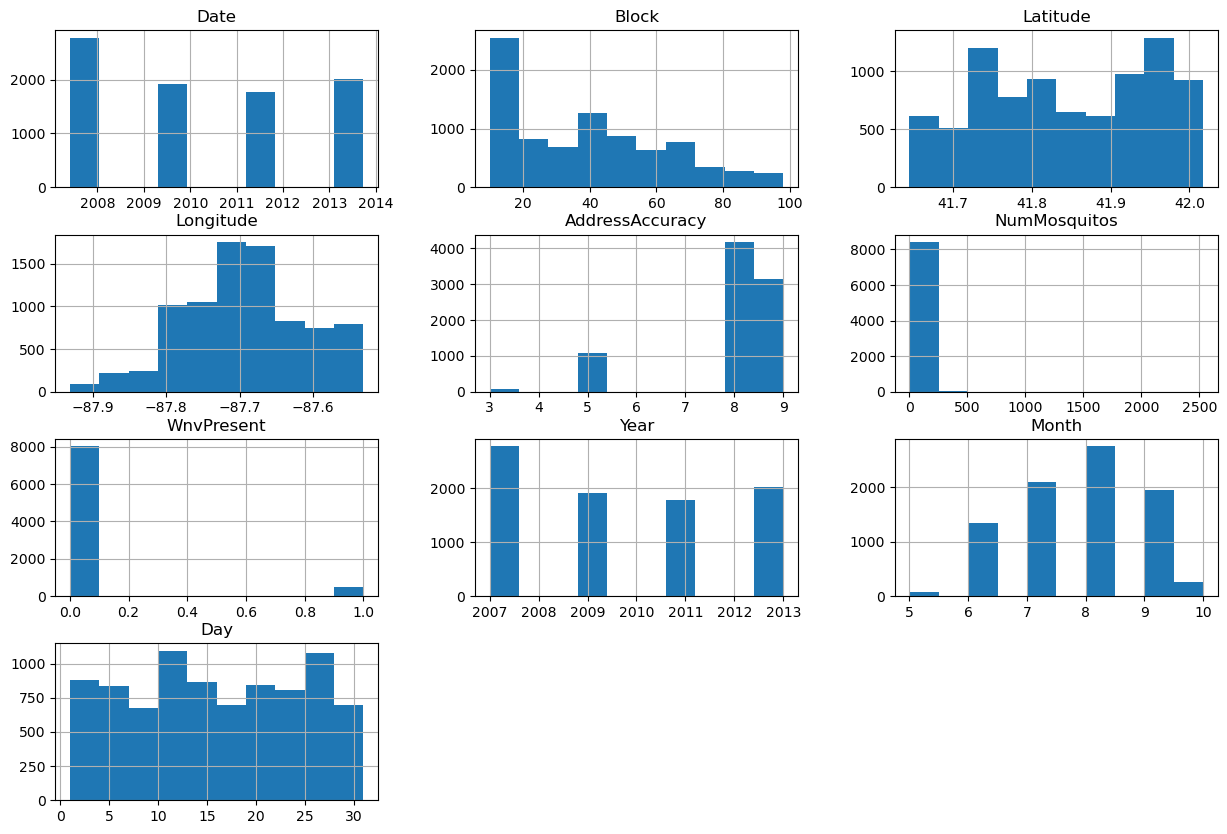

In [149]:
train_df.hist(figsize = [15, 10])
plt.show();

**Deeper level data inference**

**NumMosquitos**
- In total there are 135039 mosquitos caught
- Most number of mosquito caught was in the year 2007
- August 2007 number of mosquito caught peaked for year 2007 and the mosquito species are the CULEX PIPENS.
- July 2009 number of mosquito caught peaked for year 2009 and the mosquito species are the CULEX PIPENS/RESTAUNS.
- July 2011 number of mosquito caught peaked for year 2011 and the mosquito species are the CULEX PIPENS/RESTAUNS.
- August 2013 number of mosquito caught peaked for year 2013 and the mosquito species are the CULEX PIPENS/RESTAUNS.
- Top 5 most number of mosquitos caught are in the year 2007 August and the species are the CULEX PIPENS/RESTAUNS.
- There are 7 species of mosquitos where CULEX PIPIENS/RESTUANS being the most commonly caught
- Top 5 most number of mosquitos caught are in 12 S DOTY AVE, 10 W OHARE AIRPORT, 10 S STONY ISLAND AVE, 41 N OAK PARK AVE & 24 E 105TH ST.
- Top 5 most number of mosquitos caught by trap are T115, T900, T138, T002 & T128


In [150]:
train_df['NumMosquitos'].sum()

135039

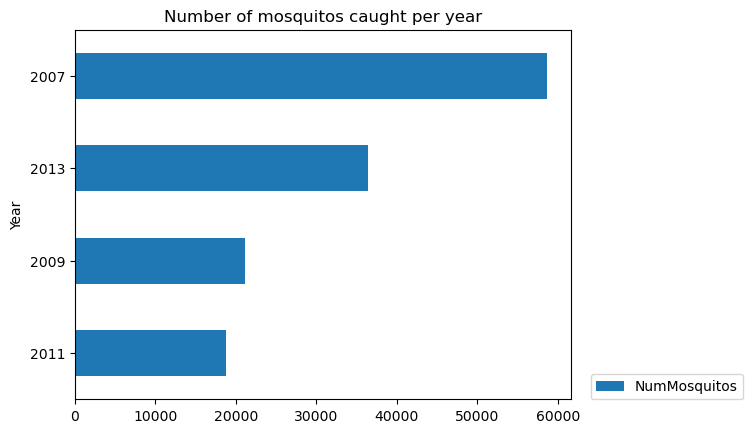

In [151]:
pd.DataFrame(train_df.groupby(by = ['Year'])['NumMosquitos'].sum().sort_values()).plot.barh(rot=0)
plt.title('Number of mosquitos caught per year')
plt.legend(loc=(1.04,0))
plt.show();

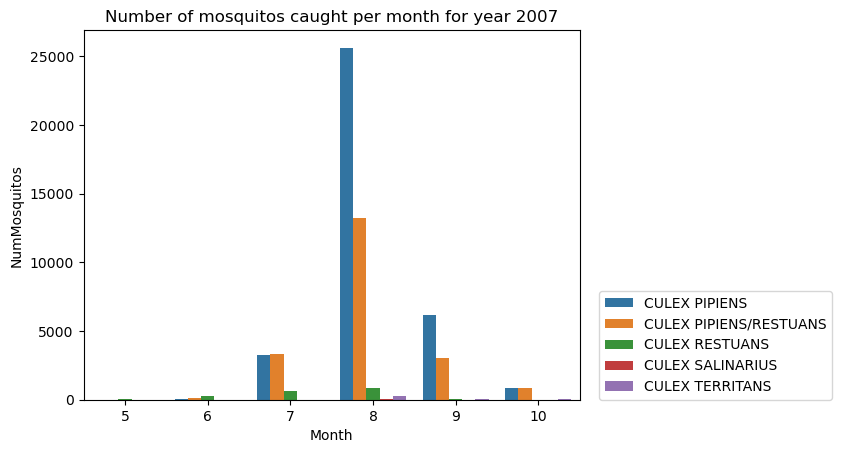

In [152]:
sns.barplot(data = pd.DataFrame(train_df.groupby(by = ['Year','Month','Species'])['NumMosquitos'].sum().loc[(2007)]).reset_index(),
            x = 'Month', y = 'NumMosquitos', hue="Species")
plt.title('Number of mosquitos caught per month for year 2007')
plt.legend(loc=(1.04,0))
plt.show();

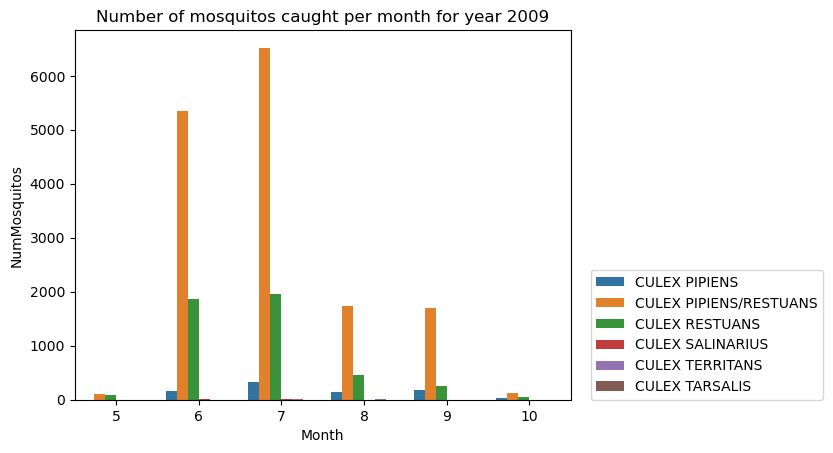

In [153]:
sns.barplot(data = pd.DataFrame(train_df.groupby(by = ['Year','Month','Species'])['NumMosquitos'].sum().loc[(2009)]).reset_index(),
            x = 'Month', y = 'NumMosquitos', hue="Species")
plt.title('Number of mosquitos caught per month for year 2009')
plt.legend(loc=(1.04,0))
plt.show();

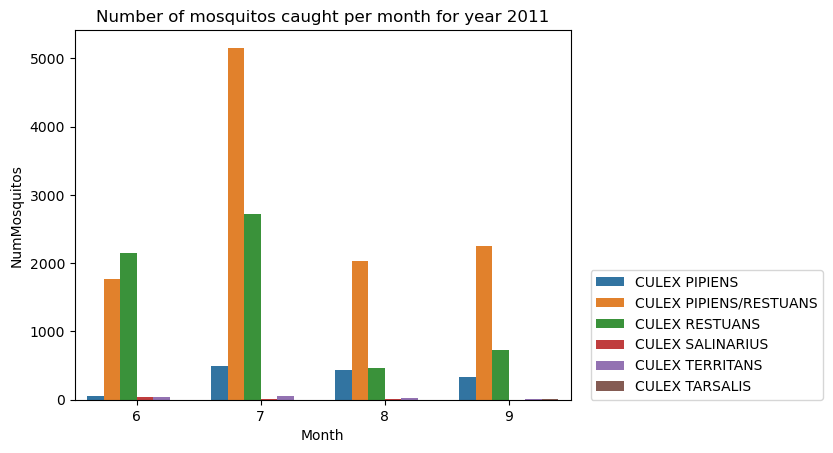

In [154]:
sns.barplot(data = pd.DataFrame(train_df.groupby(by = ['Year','Month','Species'])['NumMosquitos'].sum().loc[(2011)]).reset_index(),
            x = 'Month', y = 'NumMosquitos', hue="Species")
plt.title('Number of mosquitos caught per month for year 2011')
plt.legend(loc=(1.04,0))
plt.show();

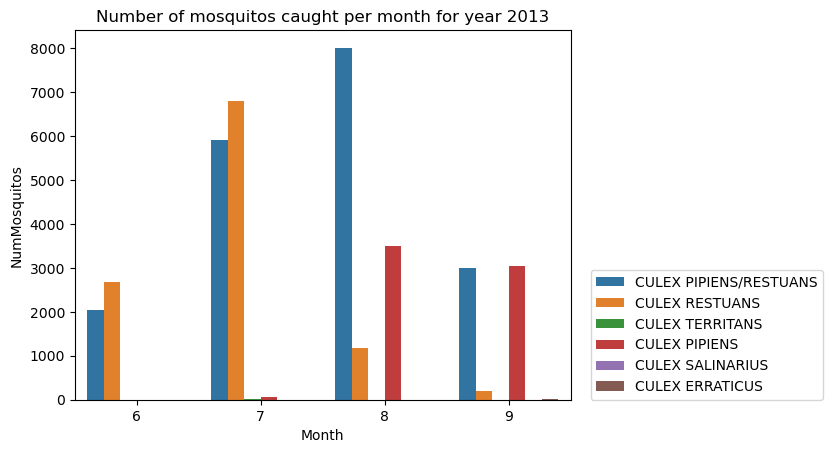

In [155]:
sns.barplot(data = pd.DataFrame(train_df.groupby(by = ['Year','Month','Species'])['NumMosquitos'].sum().loc[(2013)]).reset_index(),
            x = 'Month', y = 'NumMosquitos', hue="Species")
plt.title('Number of mosquitos caught per month for year 2013')
plt.legend(loc=(1.04,0))
plt.show();

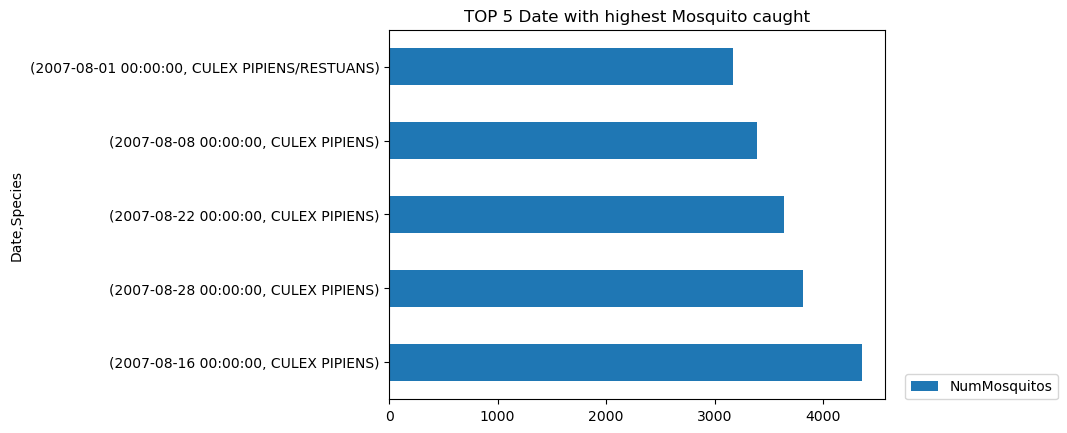

In [156]:
pd.DataFrame(train_df.groupby(by= ['Date','Species'])['NumMosquitos'].sum().sort_values(ascending = False)).head().plot.barh(rot=0)
plt.title('TOP 5 Date with highest Mosquito caught')
plt.legend(loc=(1.04,0))
plt.show();

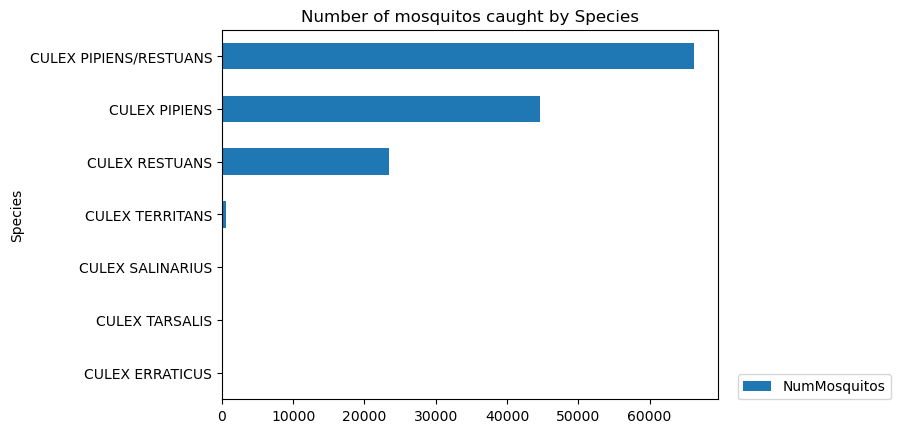

In [157]:
pd.DataFrame(train_df.groupby('Species')['NumMosquitos'].sum().sort_values()).plot.barh(rot=0)
plt.title('Number of mosquitos caught by Species')
plt.legend(loc=(1.04,0))
plt.show();

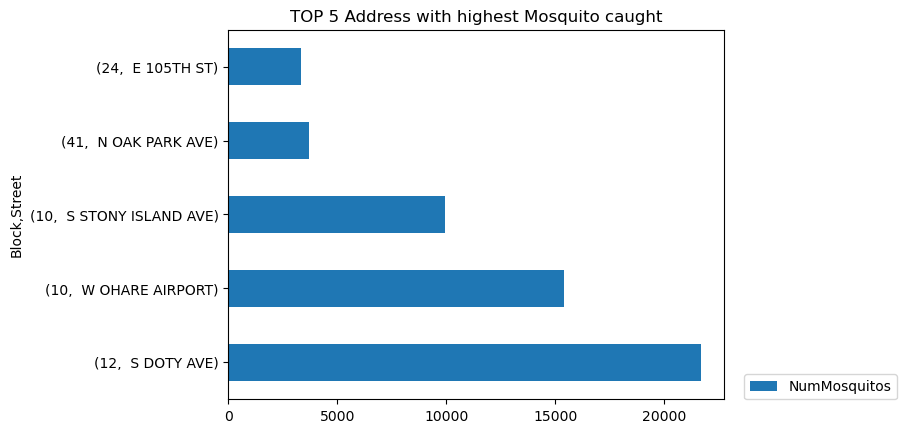

In [158]:
pd.DataFrame(train_df.groupby(by= ['Block', 'Street'])['NumMosquitos'].sum().sort_values(ascending = False)).head().plot.barh(rot=0)
plt.title('TOP 5 Address with highest Mosquito caught')
plt.legend(loc=(1.04, 0))
plt.show();

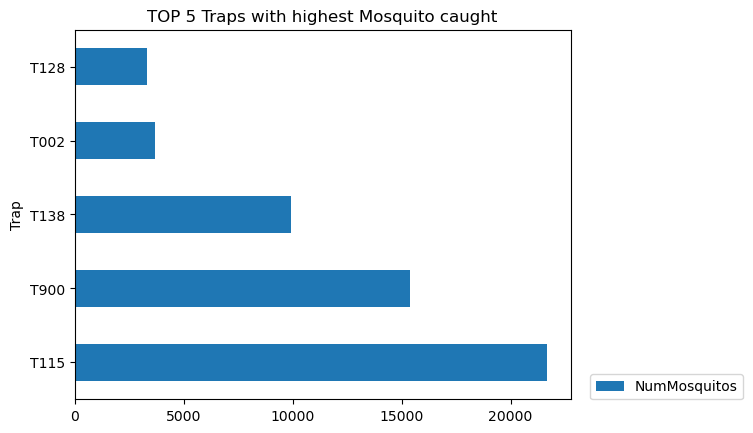

In [159]:
pd.DataFrame(train_df.groupby(['Trap'])['NumMosquitos'].sum().sort_values(ascending = False)).head().plot.barh(rot=0)
plt.title('TOP 5 Traps with highest Mosquito caught')
plt.legend(loc=(1.04, 0))
plt.show();

---
**Deeper level data inference**

**Trap**
- There are a total of 136 traps
- Top 5 number of times recorded are T900, T002, T135, T151, T115
- There are 2 satellite traps 'T094B' and 'T054C'
- CULEX PIPIENS/RESTUANS most commonly caught in traps

In [160]:
pd.DataFrame(train_df['Trap'].value_counts(ascending= False)).shape

(136, 1)

In [161]:
train_df['Trap'].unique()

array(['T002', 'T159', 'T153', 'T148', 'T143', 'T129', 'T096', 'T094',
       'T091', 'T086', 'T054', 'T007', 'T015', 'T045', 'T048', 'T049',
       'T050', 'T046', 'T142', 'T141', 'T135', 'T033', 'T092', 'T090',
       'T089', 'T145', 'T146', 'T218', 'T147', 'T149', 'T150', 'T151',
       'T152', 'T154', 'T158', 'T162', 'T031', 'T220', 'T028', 'T019',
       'T025', 'T016', 'T011', 'T009', 'T001', 'T003', 'T006', 'T161',
       'T008', 'T219', 'T088', 'T085', 'T051', 'T047', 'T043', 'T040',
       'T037', 'T034', 'T012', 'T084', 'T013', 'T014', 'T018', 'T030',
       'T144', 'T160', 'T095', 'T044', 'T017', 'T005', 'T061', 'T004',
       'T036', 'T039', 'T060', 'T035', 'T062', 'T065', 'T081', 'T082',
       'T083', 'T114', 'T155', 'T069', 'T080', 'T066', 'T067', 'T070',
       'T071', 'T073', 'T075', 'T076', 'T077', 'T079', 'T074', 'T063',
       'T115', 'T200', 'T138', 'T212', 'T215', 'T209', 'T206', 'T128',
       'T107', 'T072', 'T102', 'T103', 'T100', 'T099', 'T097', 'T156',
      

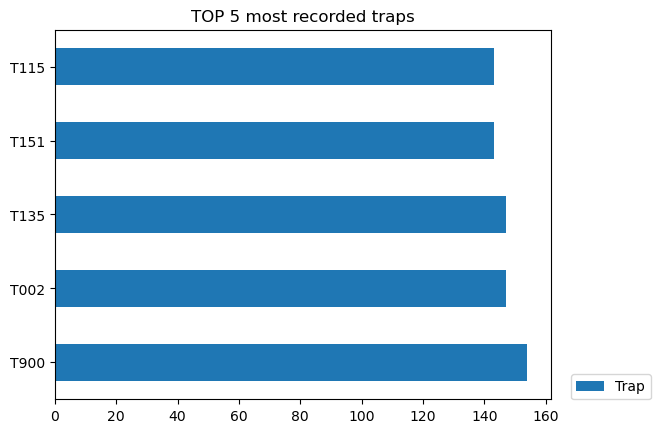

In [162]:
pd.DataFrame(train_df['Trap'].value_counts(ascending= False)).head().plot.barh(rot=0)
plt.title('TOP 5 most recorded traps')
plt.legend(loc=(1.04, 0))
plt.show();

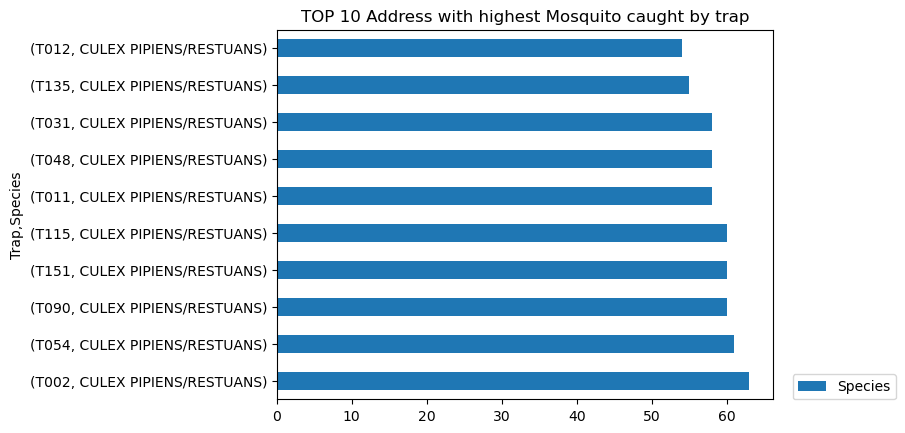

In [163]:
pd.DataFrame(train_df.groupby('Trap')['Species'].value_counts().sort_values(ascending = False)).head(10).plot.barh(rot=0)
plt.title('TOP 10 Address with highest Mosquito caught by trap')
plt.legend(loc=(1.04, 0))
plt.show();

---
**Deeper level data inference**

**Block**
- There are a total of 64 blocks
- Top 5 number of times recorded are blocks 10, 11, 22 ,13 & 17

In [164]:
pd.DataFrame(train_df['Block'].value_counts(ascending= False)).shape

(64, 1)

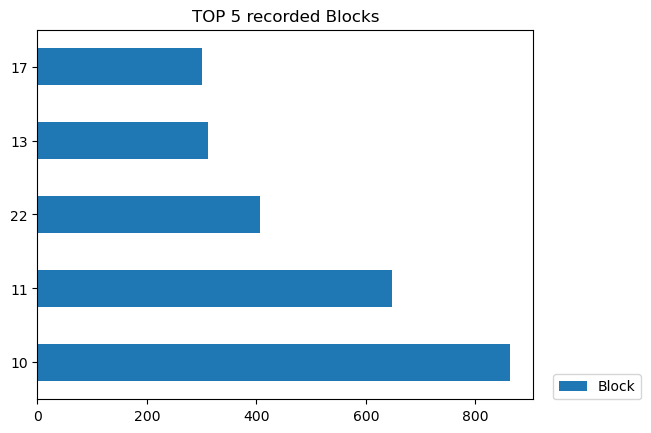

In [165]:
pd.DataFrame(train_df['Block'].value_counts(ascending= False)).head().plot.barh(rot=0)
plt.title('TOP 5 recorded Blocks')
plt.legend(loc=(1.04, 0))
plt.show();

---
**Deeper level data inference**

**Address Accuracy**
- There are a total of 4 types of Address Accuracy 9, 8, 5 & 3 where 8 has the highest recored frequency and 3 being the least 


In [166]:
pd.DataFrame(train_df['AddressAccuracy'].value_counts(ascending= False))

AddressAccuracy
8             4179
9             3137
5             1080
3               79

---
**Deeper level data inference**

**Latitude & Longitude**
- There are a total of 138 Latitude and Longitude combinations recorded.
- top 5 coordinates are (41.974689  -87.890615), (41.662014  -87.724608), (41.954690  -87.800991), (41.673408  -87.599862) & (41.916265  -87.800515)

In [167]:
train_df[['Latitude','Longitude']].value_counts().shape

(138,)

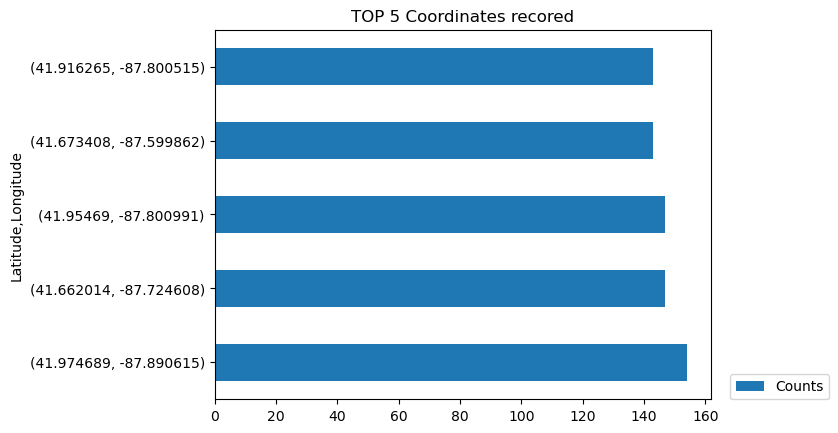

In [168]:
pd.DataFrame(train_df[['Latitude','Longitude']].value_counts(ascending= False)).head().plot.barh(rot=0)
plt.title('TOP 5 Coordinates recored')
plt.legend(loc=(1.04, 0)).get_texts()[0].set_text('Counts')
plt.show();

---
**Deeper level data inference**

**WnvPresent**
- Data imbalance ~ 95% class 0 and ~5% class 1 (Virus presence) .
- In 2007 Class1 detected only at Month 7 8 9 10 and Month 8 being highest that year (~10%)
- In 2009 Class1 detected only at Month 7 8 9 and Month 8 being highest that year (>~10%)
- In 2011 Class1 detected only at Month 7 8 9 and Month 9 being highest that year (>~10%)
- In 2013 Class1 detected only at Month 6 7 8 9 and Month 8 being highest that year (~20%)
- Top 10 traps with highest west nile virus recorded are T900, T002, T115, T003, T225, T011, T013, T138, T028, T114
- Top 10 Address with highest west nile virus recorded10 W OHARE AIRPORT, 41 N OAK PARK AVE, 12 S DOTY AVE, 46 N MILWAUKEE AVE, 36 N PITTSBURGH AVE, 82 S KOSTNER AVE, 61 W FULLERTON AVE, 58 N WESTERN AVE, 70 N MOSELL AVE & 10 W OHARE

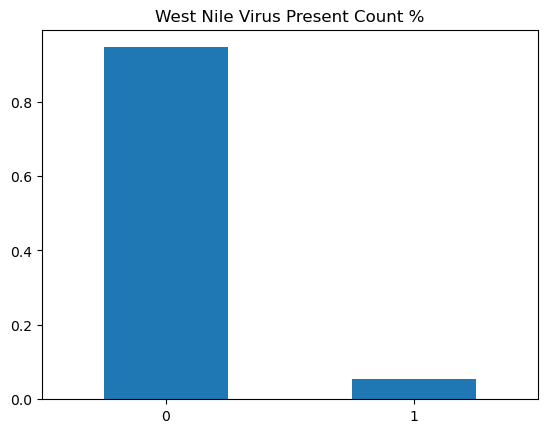

In [169]:
train_df['WnvPresent'].value_counts(normalize = True).plot.bar(rot=0)
plt.title('West Nile Virus Present Count %');

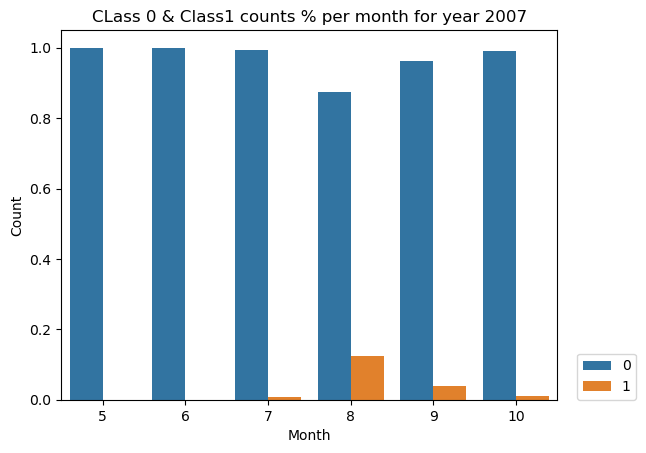

In [170]:
sns.barplot(data =pd.DataFrame(train_df.groupby(by = ['Year','Month'])['WnvPresent'].value_counts(normalize = True)).rename(columns={"WnvPresent": "Count"}).loc[(2007)
            ].reset_index(), x = 'Month', y = 'Count', hue = 'WnvPresent')
plt.title('CLass 0 & Class1 counts % per month for year 2007')
plt.legend(loc=(1.04,0))
plt.show();

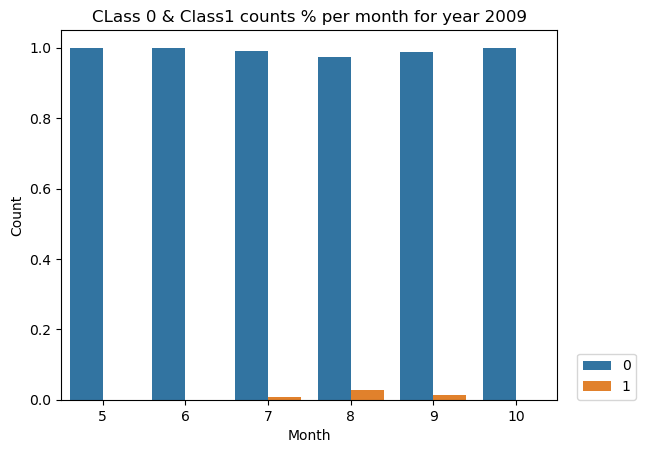

In [171]:
sns.barplot(data =pd.DataFrame(train_df.groupby(by = ['Year','Month'])['WnvPresent'].value_counts(normalize = True)).rename(columns={"WnvPresent": "Count"}).loc[(2009)
            ].reset_index(),x = 'Month', y = 'Count', hue = 'WnvPresent')
plt.title('CLass 0 & Class1 counts % per month for year 2009')
plt.legend(loc=(1.04,0))
plt.show();

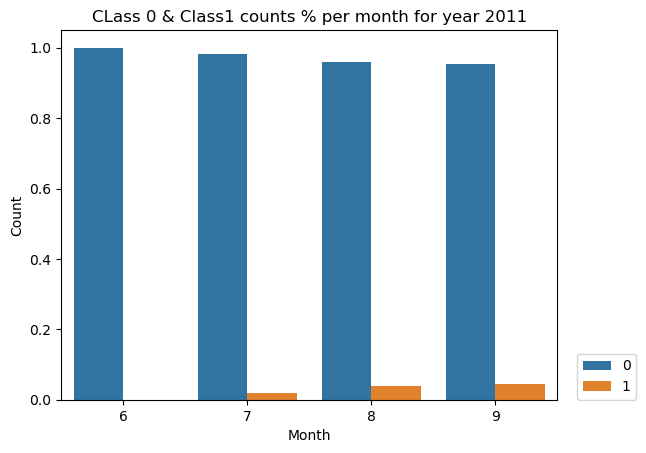

In [172]:
sns.barplot(data =pd.DataFrame(train_df.groupby(by = ['Year','Month'])['WnvPresent'].value_counts(normalize = True)).rename(columns={"WnvPresent": "Count"}).loc[(2011)
            ].reset_index(),x = 'Month', y = 'Count', hue = 'WnvPresent')
plt.title('CLass 0 & Class1 counts % per month for year 2011')
plt.legend(loc=(1.04,0))
plt.show();

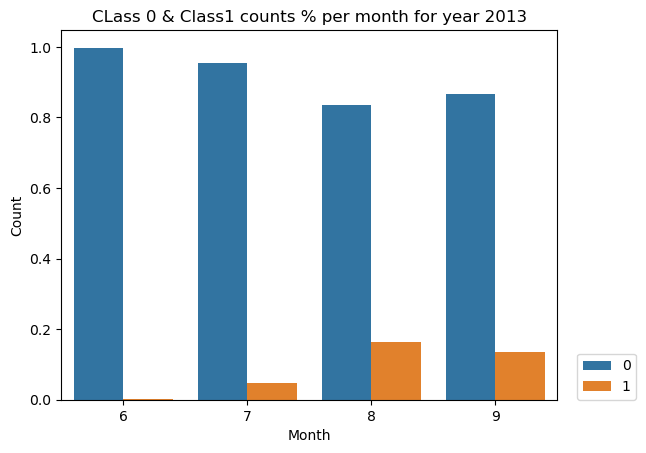

In [173]:
sns.barplot(data =pd.DataFrame(train_df.groupby(by = ['Year','Month'])['WnvPresent'].value_counts(normalize = True)).rename(columns={"WnvPresent": "Count"}).loc[(2013)
            ].reset_index(),x = 'Month', y = 'Count', hue = 'WnvPresent')
plt.title('CLass 0 & Class1 counts % per month for year 2013')
plt.legend(loc=(1.04,0))
plt.show();

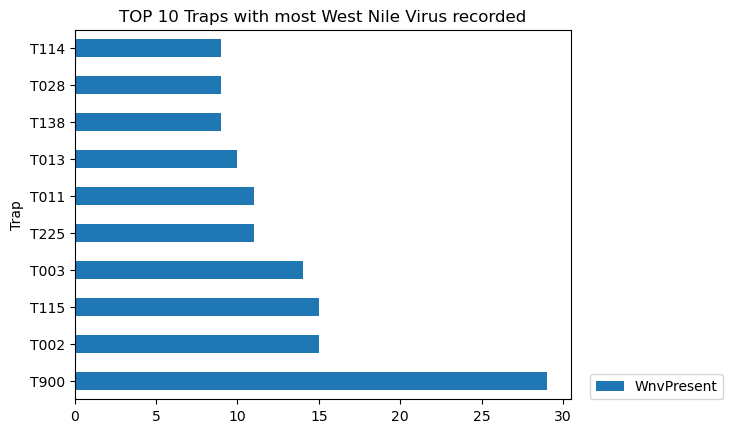

In [174]:
pd.DataFrame(train_df.groupby('Trap')['WnvPresent'].sum().sort_values(ascending = False)).head(10).plot.barh(rot=0)
plt.title('TOP 10 Traps with most West Nile Virus recorded')
plt.legend(loc=(1.04,0))
plt.show();

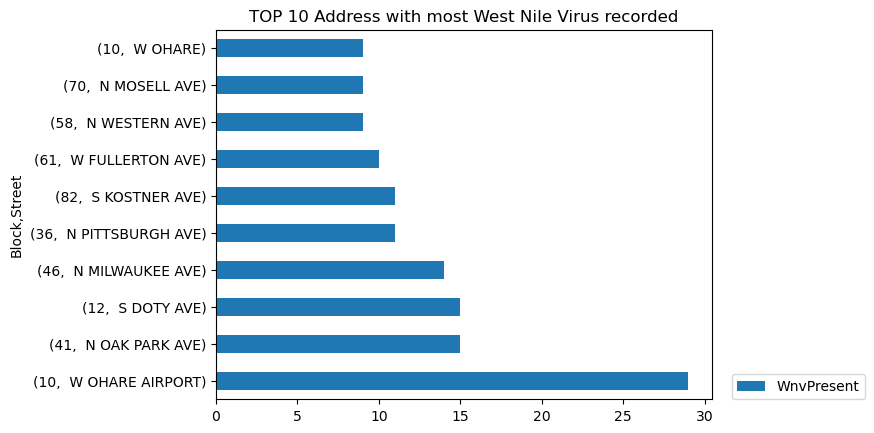

In [175]:
pd.DataFrame(train_df.groupby(by= ['Block','Street'])['WnvPresent'].sum().sort_values(ascending = False)).head(10).plot.barh(rot=0)
plt.title('TOP 10 Address with most West Nile Virus recorded')
plt.legend(loc=(1.04,0))
plt.show();

---
**Deeper level data inference**

**Correlation heat map for train**
- All features does not have high Correlation to Y target

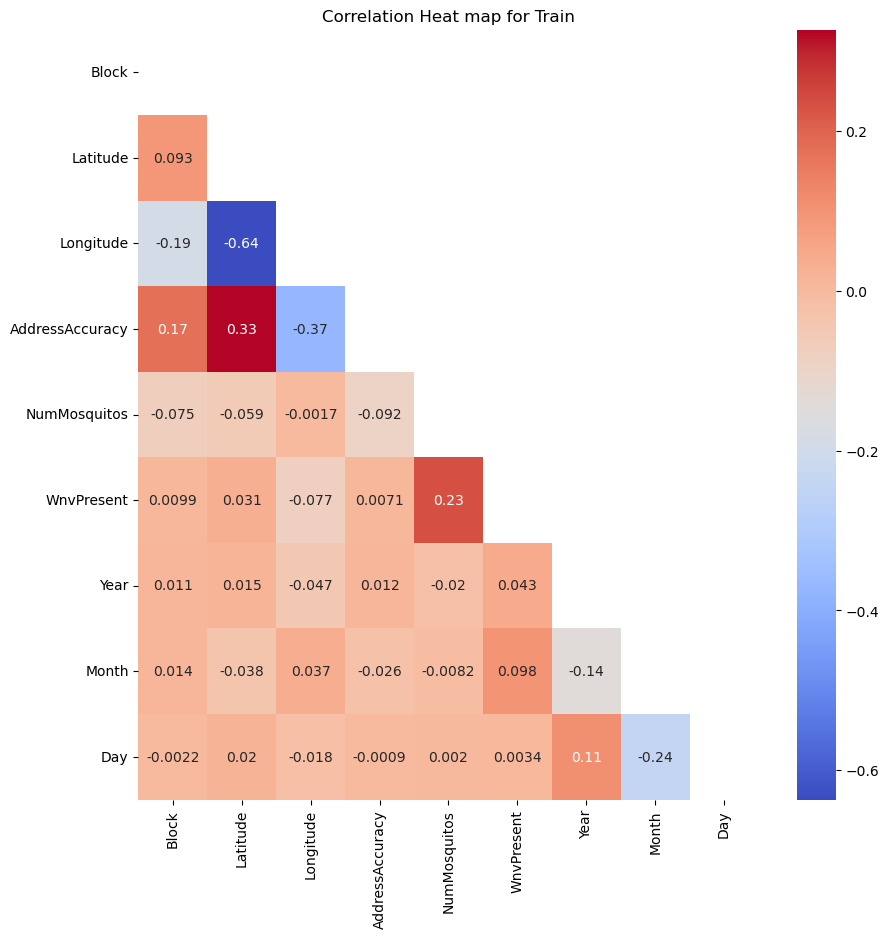

In [176]:
plt.figure(figsize=(10,10))
corr = train_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask, annot = True, cmap='coolwarm')
plt.title('Correlation Heat map for Train')
plt.show();

### 2.2.0 Exploring `test.csv`

**Quick histrogram plot (High level data inference)**
1) Date
    - Highest Data contribution is from year 2010
    - Highest Data contribution is from month 7  
    - Day has 2 peaks  around 20 and 29
2) Block
    - Majority of data are from block >20      
3) Latitude
    - Majority of data are from > 41.9 
4) Longitude
    - Majority of data are around -87.7       
3) AddressAccuracy
    - Majority of data are around 8-9      
 

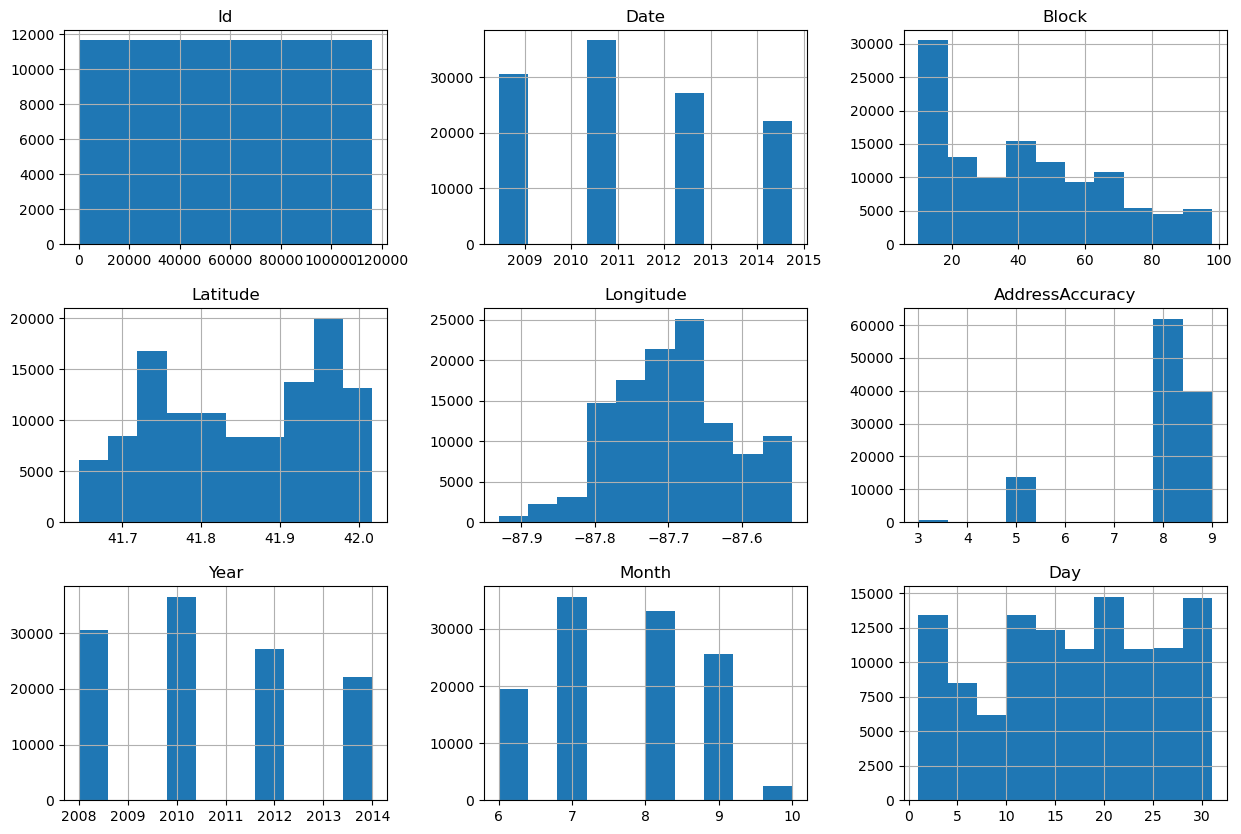

In [177]:
test_df.hist(figsize = [15, 10])
plt.show();

---
**Deeper level data inference**

**Trap**
- There are a total of 149 traps
- Top 5 number of times recorded are T009, T035, T900, T002, T008
- There are 10 satellite traps 'T903', 'T090A', 'T090B','T090C', 'T200A', 'T128A', 'T200B', 'T218A', 'T218C', 'T218B'
- CULEX PIPIENS/RESTUANS most commonly caught in traps

In [178]:
pd.DataFrame(test_df['Trap'].value_counts(ascending= False)).shape

(149, 1)

In [179]:
test_df['Trap'].unique()

array(['T002', 'T007', 'T015', 'T045', 'T046', 'T048', 'T049', 'T050',
       'T054', 'T086', 'T091', 'T094', 'T096', 'T129', 'T143', 'T148',
       'T153', 'T159', 'T009', 'T011', 'T016', 'T019', 'T025', 'T028',
       'T031', 'T033', 'T089', 'T090', 'T092', 'T135', 'T141', 'T142',
       'T145', 'T146', 'T147', 'T149', 'T150', 'T151', 'T152', 'T154',
       'T158', 'T162', 'T218', 'T220', 'T001', 'T003', 'T006', 'T008',
       'T012', 'T034', 'T037', 'T040', 'T043', 'T047', 'T051', 'T085',
       'T088', 'T161', 'T219', 'T013', 'T014', 'T018', 'T030', 'T084',
       'T144', 'T160', 'T005', 'T017', 'T044', 'T095', 'T004', 'T035',
       'T036', 'T039', 'T060', 'T061', 'T062', 'T065', 'T066', 'T067',
       'T069', 'T070', 'T071', 'T073', 'T074', 'T075', 'T076', 'T077',
       'T079', 'T080', 'T081', 'T082', 'T083', 'T114', 'T155', 'T063',
       'T115', 'T138', 'T200', 'T206', 'T209', 'T212', 'T215', 'T107',
       'T128', 'T072', 'T078', 'T097', 'T099', 'T100', 'T102', 'T103',
      

In [180]:
# difference in train and test
set(test_df.Trap.unique()) - set(train_df.Trap.unique())

{'T002A',
 'T002B',
 'T065A',
 'T090A',
 'T090B',
 'T090C',
 'T128A',
 'T200A',
 'T200B',
 'T218A',
 'T218B',
 'T218C',
 'T234'}

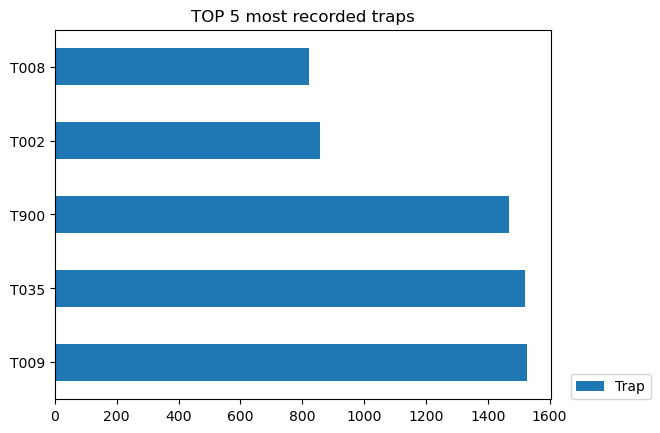

In [181]:
pd.DataFrame(test_df['Trap'].value_counts(ascending= False)).head().plot.barh(rot=0)
plt.title('TOP 5 most recorded traps')
plt.legend(loc=(1.04, 0))
plt.show();

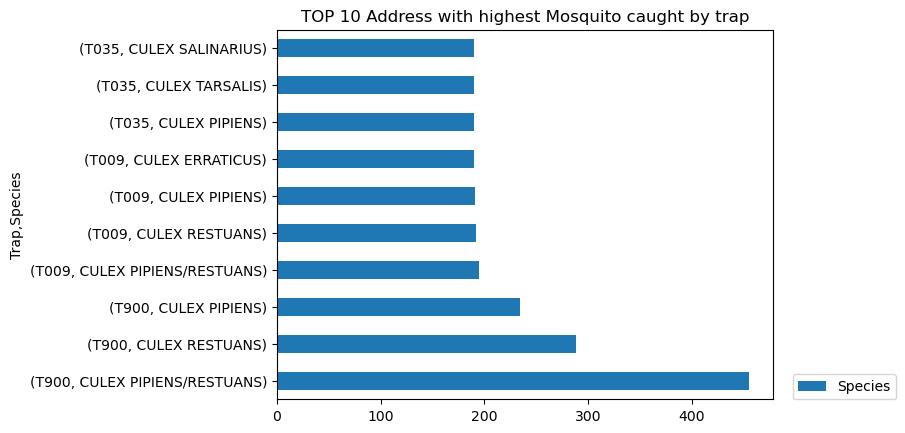

In [182]:
pd.DataFrame(test_df.groupby('Trap')['Species'].value_counts().sort_values(ascending = False)).head(10).plot.barh(rot=0)
plt.title('TOP 10 Address with highest Mosquito caught by trap')
plt.legend(loc=(1.04, 0))
plt.show();

---
**Deeper level data inference**

**Block**
- There are a total of 65 blocks
- Top 5 number of times recorded are blocks 10, 11, 22 ,40 & 37

In [183]:
pd.DataFrame(test_df['Block'].value_counts(ascending= False)).shape

(65, 1)

In [184]:
# difference in train and test
set(test_df.Block.unique()) - set(train_df.Block.unique())

{26}

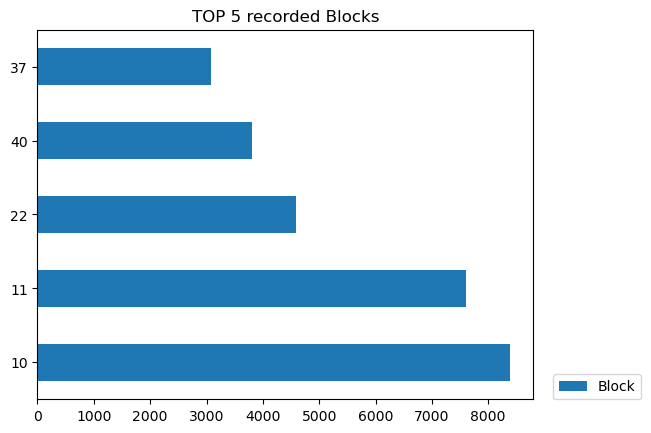

In [185]:
pd.DataFrame(test_df['Block'].value_counts(ascending= False)).head().plot.barh(rot=0)
plt.title('TOP 5 recorded Blocks')
plt.legend(loc=(1.04, 0))
plt.show();

---
**Deeper level data inference**

**Street**
- There are a total of 139 streets
- Top 5 number of times recorded are streets named N OAK PARK AVE	, N PULASKI RD, N CANNON DR ,S ASHLAND AVE & S STONY ISLAND AVE

In [186]:
pd.DataFrame(test_df['Street'].value_counts(ascending= False)).shape

(139, 1)

In [187]:
# difference in train and test
set(test_df.Street.unique()) - set(train_df.Street.unique())

{' E 136TH ST',
 ' N KENNETH AVE',
 ' N KILBOURN AVE',
 ' N MELVINA AVE',
 ' S BALTIMORE AVE',
 ' S LOOMIS ST',
 ' S OGLESBY AVE',
 ' W 112TH ST',
 ' W 120TH ST',
 ' W 63RD PL',
 ' W DAKIN ST'}

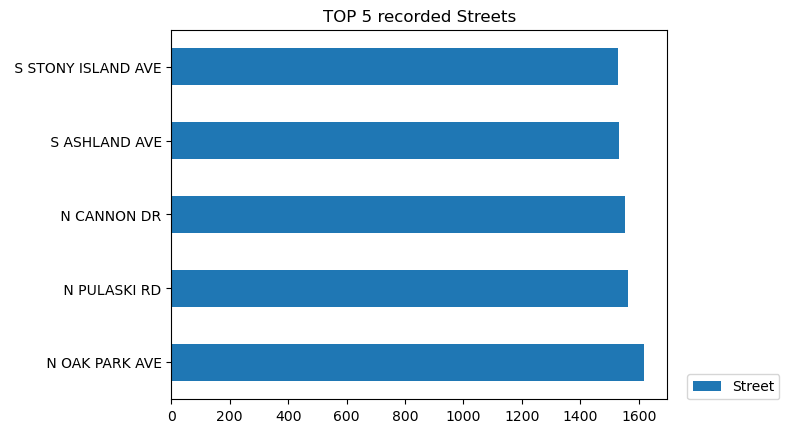

In [188]:
pd.DataFrame(test_df['Street'].value_counts(ascending= False)).head().plot.barh(rot=0)
plt.title('TOP 5 recorded Streets')
plt.legend(loc=(1.04, 0))
plt.show();

---
**Deeper level data inference**

**Address Accuracy**
- There are a total of 4 types of Address Accuracy 9, 8, 5 & 3 where 8 has the highest recored frequency and 3 being the least 


In [189]:
pd.DataFrame(test_df['AddressAccuracy'].value_counts(ascending= False))

AddressAccuracy
8            61973
9            39795
5            13761
3              764

---
**Deeper level data inference**

**Latitude & Longitude**
- There are a total of 151 Latitude and Longitude Unique combinations recorded.
- top 5 coordinates are (41.974689  -87.890615), (41.954690 -87.800991), (42.008314	-87.777921	), (41.944869	-87.832763	) & (41.984809	-87.728492)

In [190]:
test_df[['Latitude','Longitude']].value_counts().shape

(151,)

In [191]:
# Difference in Train and Test
set(test_df[['Latitude','Longitude']].value_counts().index) - set(train_df[['Latitude','Longitude']].value_counts().index)

{(41.646541, -87.543762),
 (41.675876, -87.651515),
 (41.690423, -87.656929),
 (41.731929, -87.54854),
 (41.738583, -87.567726),
 (41.777689, -87.749149),
 (41.868533, -87.661638),
 (41.933652, -87.738416),
 (41.942285, -87.761726),
 (41.94828, -87.74134),
 (41.951878, -87.789234),
 (41.95477, -87.73089),
 (41.965571, -87.781978)}

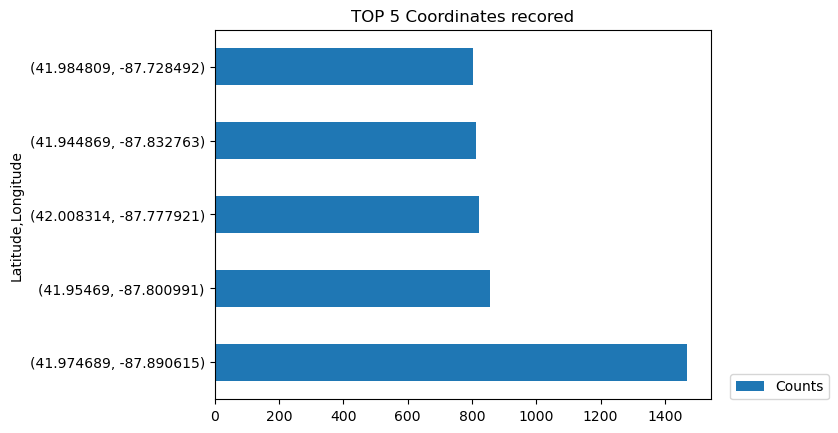

In [192]:
pd.DataFrame(test_df[['Latitude','Longitude']].value_counts(ascending= False)).head().plot.barh(rot=0)
plt.title('TOP 5 Coordinates recored')
plt.legend(loc=(1.04, 0)).get_texts()[0].set_text('Counts')
plt.show();

### 2.3.0 Exploring `weather.csv`

In [193]:
weather_df.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'GR', 'SQ', 'SN', 'FG+', 'HZ', 'VCFG',
       'MIFG', 'FG', 'RA', 'TSRA', 'DZ', 'TS', 'BCFG', 'FU', 'VCTS', 'BR',
       'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'AvgSpeed', 'Trange', 'RHumidity', 'Sunrise', 'Sunset'],
      dtype='object')

In [194]:
num_feat = ['Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 
            'Cool','PrecipTotal', 'StnPressure','SeaLevel', 'ResultSpeed', 'ResultDir',
            'AvgSpeed', 'Trange', 'RHumidity', 'Sunrise', 'Sunset']

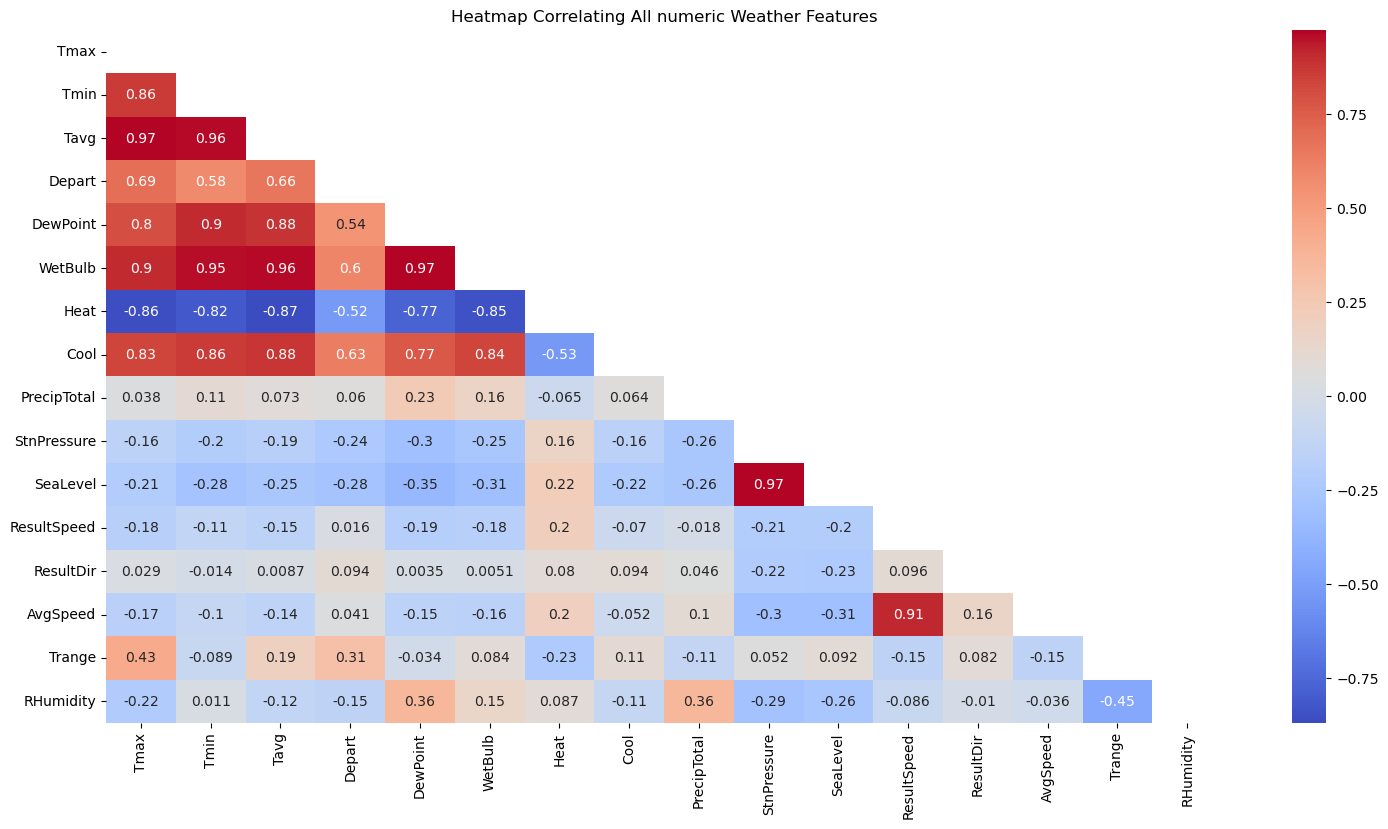

In [195]:
plt.figure(figsize=(18,9))
corr = weather_df[num_feat].corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask, annot = True, cmap='coolwarm'); # 'coolwarm' colormap is easier to read in my opinion

plt.title('Heatmap Correlating All numeric Weather Features');

- Identified the follwoing features with strong correlation:
    1) Tmin, Tmax, Tavg and Depart
    1) WetBulb and DewPoint
    1) StnPressure and SeaLevel
    1) ResultSpeed and AvgSpeed
    1) Cool and Heat

**Tmin, Tmax and Tavg**

In [196]:
# Since Tavg is derived from Tmin and Tmax, Tmin and Tmax will be dropped to minimise multi-ollinearity
weather_df.drop(columns = ['Tmin', 'Tmax'], inplace =True)

**WetBulb and DewPoint**

In [197]:
# WetBulb and DewPoint are highly correlated with Pearson Corr =0.97. Since both features are related to the relative humidity in air, either features can be dropped
# Wetbulb and DewPoint are dropped to avoid multi-collinearity with Tavg (corr = 0.96)
weather_df.drop(columns = ['WetBulb','DewPoint'], inplace =True)

**StnPressure and SeaLevel**

In [198]:
# StnPressure and SeaLevel are highly correlated with Pearson Corr =0.97.
# StnPressure changes at various altitudes since it's not adjusted. With barometric pressure, SeaLevel Pressure is likely the station pressure adjusted to the mean sea level.
# Drop StnPressure
weather_df.drop(columns = ['StnPressure'], inplace =True)

**ResultSpeed and AvgSpeed**

In [199]:
# ResultSpeed and AvgSpeed are highly correlated with Pearson Corr =0.91.
# ResultSpeed can be paired with ResultDir
# Drop AvgSpeed
weather_df.drop(columns = ['AvgSpeed'], inplace =True)

**Basic statistics and distrubution plot**
|Col|Mean|Min|Max|Dist|
|---|---|---|---|---|
|Tavg|67.2|36 |94|Nominal| 
|Depart|2.5|-17.0|25.0 |Nominal| 
|Heat| 3.41|0|29|Left-Skewed|
|Cool| 5.64|0|29 |Left-Skewed|
|PrecipTotal| 0.13|0|6.86 |Left-Skewed
|SeaLevel| 29.9|29.2|30.5 |Nominal|
|ResultSpeed| 6.96|0.1|24.1|Nominal|
|ResultDir| 17.4|1|36 |Two Peaks|
|Trange|18.3|3|41 |Nominal|
|RHumidity|62.2|29.9|107|Nominal|
|Daylight(hr)| 0.56|0.43|0.63|Right-Skewed|

In [200]:
new_num_feat = ['Tavg', 'Depart', 'Heat', 'Cool','PrecipTotal', 'SeaLevel', 
                'ResultSpeed','ResultDir', 'Trange', 'RHumidity']

In [201]:
weather_df[new_num_feat].describe()

Tavg       Depart         Heat         Cool  PrecipTotal  \
count  2944.000000  2944.000000  2944.000000  2944.000000  2944.000000   
mean     67.239470     2.587296     3.417799     5.641304     0.131780   
std      10.539316     6.915085     5.955153     6.104849     0.393031   
min      36.000000   -17.000000     0.000000     0.000000     0.000000   
25%      60.000000    -2.000000     0.000000     0.000000     0.000000   
50%      69.000000     2.000000     0.000000     4.000000     0.000000   
75%      75.000000     7.000000     5.000000    10.000000     0.060000   
max      94.000000    25.000000    29.000000    29.000000     6.860000   

          SeaLevel  ResultSpeed    ResultDir       Trange    RHumidity  
count  2944.000000  2944.000000  2944.000000  2944.000000  2944.000000  
mean     29.968274     6.960666    17.494905    18.355639    62.271527  
std       0.158487     3.587527    10.063609     5.872835    11.418334  
min      29.230000     0.100000     1.000000     3.000000    29.993924  
25%      29.870000     4.300000     7.000000    14.000000    54.240749  
50%      29.970000     6.400000    19.000000    18.000000    61.651562  
75%      30.060000     9.200000    25.000000    22.000000    69.511662  
max      30.530000    24.100000    36.000000    41.000000   107.152309

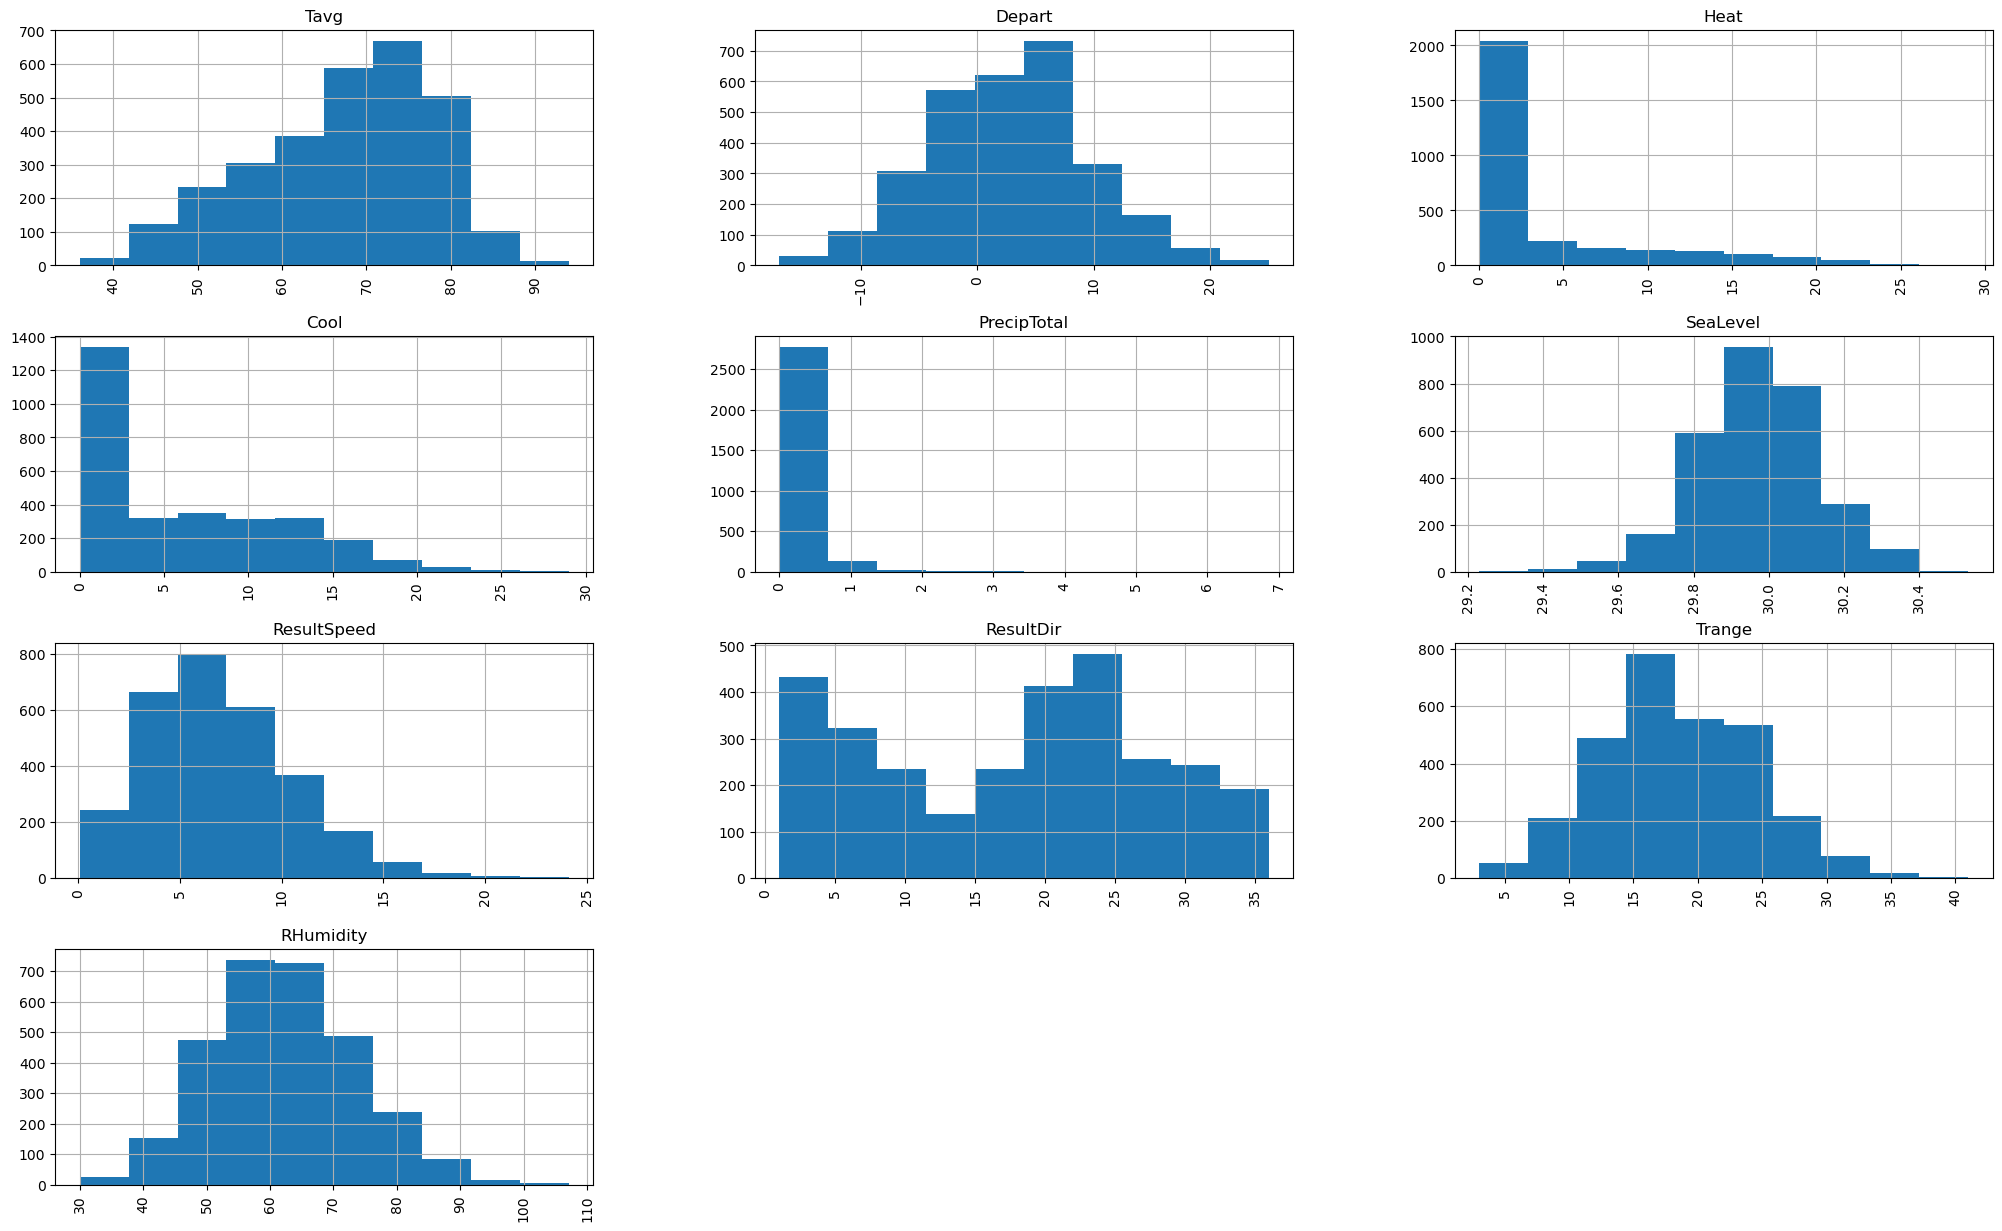

In [202]:
weather_df[new_num_feat].hist(figsize = [25, 15], xrot=90)
plt.show();

Data Inference
- Highest count of mosquito in Aug, which coincides with the the high precipitation (PrecipTotal), relative humidity (RHumidity) and temperature (Tavg) period.

### 2.4.0 Exploring `spray.csv`

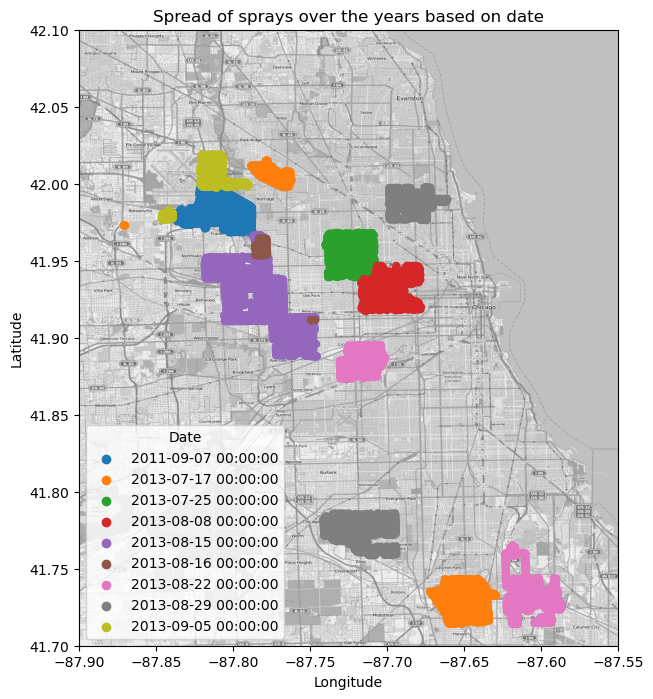

In [203]:
# Plotting spray data against graph
# Excluding '2011-08-29' as the plot is very far from the rest of the spray locations
# x1, y1 --> Spray locations
# x1, y1 --> Mosquito Density
# Latitude
x1 = spray_df['Longitude']

# Longitude
y1 = spray_df['Latitude']

# Getting list of corresponding WnvPresent values
hue1 = spray_df[spray_df['Date'] != '2011-08-29']['Date']

coord_ll = [41.7, -87.9] # Coordinates of lower left corner
coord_ur = [42.1,-87.55] # Coordinates of upper right corner

mapdata = np.loadtxt('Assets/input/mapdata_copyright_openstreetmap_contributors.txt')

plt.figure(figsize = (15,8))
plt.imshow(mapdata, cmap = plt.get_cmap('gray'), extent = [coord_ll[1], coord_ur[1], coord_ll[0], coord_ur[0]])
sns.scatterplot(x=x1, y=y1, hue=hue1, ec = None, ci=False)
plt.title('Spread of sprays over the years based on date');

### 2.5.0 Exploring `train_merged.csv`

In [204]:
# Combine train_df and weather_df using function to map Station 1 or 2
def input_station(lat:int, lng:int):
    stn1 = (41.995, -87.933)
    stn2 = (41.786, -87.752)
    coord = (lat, lng)
    
    if (geodesic(coord, stn1) 
        < geodesic(coord, stn2)):
        return 1
    
    else:
        return 2

In [205]:
train_df['Station'] = train_df.apply(lambda x: input_station(x['Latitude'], x['Longitude']), axis=1)

In [206]:
# Merge the Train and Weather data
train_merged = train_df.copy()
train_merged = train_merged.merge(weather_df, how="left", on=["Station", "Date"])

In [207]:
print(train_merged.shape)
print(train_merged.info())
train_merged.head()

(8475, 44)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8475 entries, 0 to 8474
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    8475 non-null   datetime64[ns]
 1   Address                 7720 non-null   object        
 2   Species                 8475 non-null   object        
 3   Block                   8475 non-null   int64         
 4   Street                  8475 non-null   object        
 5   Trap                    8475 non-null   object        
 6   AddressNumberAndStreet  7720 non-null   object        
 7   Latitude                8475 non-null   float64       
 8   Longitude               8475 non-null   float64       
 9   AddressAccuracy         8475 non-null   int64         
 10  NumMosquitos            8475 non-null   int64         
 11  WnvPresent              8475 non-null   int64         
 12  Year                    8475 non-null

Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  8900 South Carpenter Street, Chicago, IL 60620...   
2 2007-05-29     1500 North Long Avenue, Chicago, IL 60651, USA   
3 2007-05-29   7500 North Oakley Avenue, Chicago, IL 60645, USA   
4 2007-05-29  6500 North Oak Park Avenue, Chicago, IL 60631,...   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     89   S CARPENTER ST  T159   
2          CULEX RESTUANS     15       N LONG AVE  T153   
3  CULEX PIPIENS/RESTUANS     75     N OAKLEY AVE  T148   
4  CULEX PIPIENS/RESTUANS     65   N OAK PARK AVE  T143   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  8900  S CARPENTER ST, Chicago, IL  41.732984 -87.649642                8   
2      1500  N LONG AVE, Chicago, IL  41.907645 -87.760886                8   
3    7500  N OAKLEY AVE, Chicago, IL  42.017430 -87.687769                8   
4  6500  N OAK PARK AVE, Chicago, IL  41.999129 -87.795585                8   

   ...  VCTS  BR  PrecipTotal  SeaLevel  ResultSpeed  ResultDir  Trange  \
0  ...     0   1          0.0     30.11          5.8       18.0    28.0   
1  ...     0   1          0.0     30.09          5.8       16.0    23.0   
2  ...     0   1          0.0     30.09          5.8       16.0    23.0   
3  ...     0   1          0.0     30.11          5.8       18.0    28.0   
4  ...     0   1          0.0     30.11          5.8       18.0    28.0   

   RHumidity             Sunrise              Sunset  
0  57.398449 1900-01-01 04:21:00 1900-01-01 19:17:00  
1  53.830642 1900-01-01 04:21:00 1900-01-01 19:17:00  
2  53.830642 1900-01-01 04:21:00 1900-01-01 19:17:00  
3  57.398449 1900-01-01 04:21:00 1900-01-01 19:17:00  
4  57.398449 1900-01-01 04:21:00 1900-01-01 19:17:00  

[5 rows x 44 columns]

**Tavg by month**

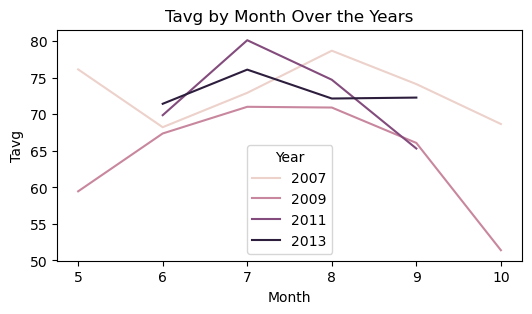

In [208]:
plt.figure(figsize=(6,3))
sns.lineplot(x='Month', 
             y='Tavg',
             hue = 'Year',
             data=train_merged.groupby(by=['Year', 'Month']).mean()[['Tavg']],
             ci=False)
plt.title('Tavg by Month Over the Years');

Data Inference
- July is the warmest month of the year. Tavg tend to decline after Aug.

**PrecipTotal by month**

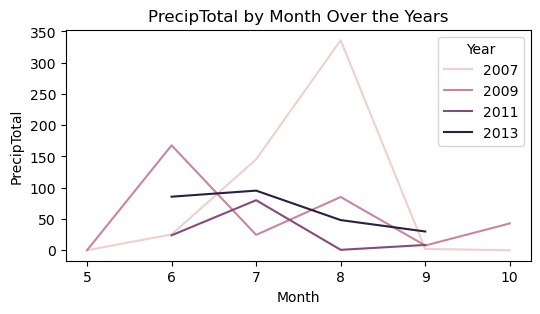

In [209]:
plt.figure(figsize=(6,3))
sns.lineplot(x='Month', 
             y='PrecipTotal',
             hue = 'Year',
             data=train_merged.groupby(by=['Year', 'Month']).sum()[['PrecipTotal']],
             ci=False)
plt.title('PrecipTotal by Month Over the Years');

Data Inference
- Except for in 2009, Jul and Aug tend to experience the most precipitation.

**RHumidity by month**

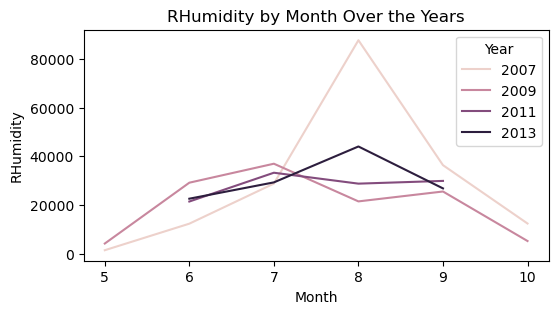

In [210]:
plt.figure(figsize=(6,3))
sns.lineplot(x='Month', 
             y='RHumidity',
             hue = 'Year',
             data=train_merged.groupby(by=['Year', 'Month']).sum()[['RHumidity']],
             ci=False)
plt.title('RHumidity by Month Over the Years');

Data Inference
- Highest relative humidity expected in Jul and Aug period of the year.

**Mosquito Trapped by month**

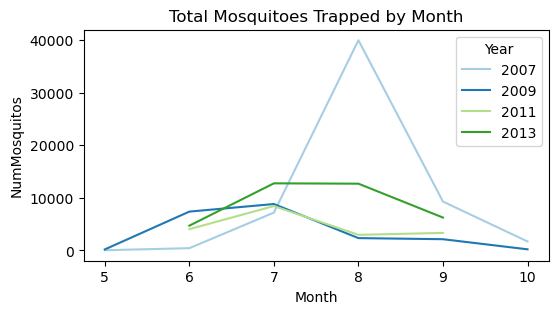

In [211]:
plt.figure(figsize=(6,3))
sns.lineplot(x='Month', y='NumMosquitos', hue='Year', data = train_merged.groupby(by=['Year', 'Month']).sum()[['NumMosquitos']], ci=False, palette='Paired')
plt.title(f'Total Mosquitoes Trapped by Month');

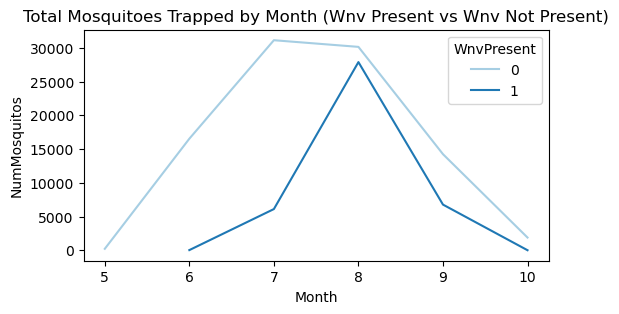

In [212]:
plt.figure(figsize=(6,3))
sns.lineplot(x='Month', y='NumMosquitos', hue='WnvPresent', data = train_merged.groupby(by=['WnvPresent', 'Month']).sum()[['NumMosquitos']], ci=False, palette='Paired')
plt.title(f'Total Mosquitoes Trapped by Month (Wnv Present vs Wnv Not Present)');

**Data Inference**
- Highest count of mosquito in Jul and Aug period, which coincides with the the high precipitation (PrecipTotal), relative humidity (RHumidity) and temperature (Tavg) period.
---

**Mosquito Trapped Year**

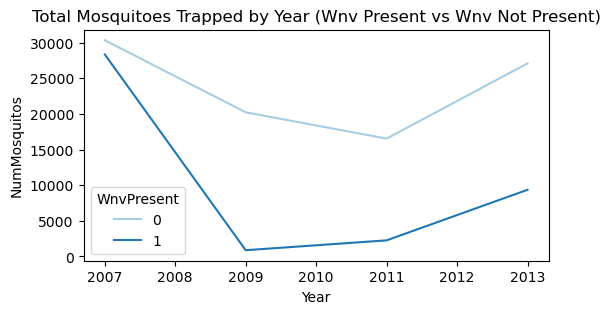

In [213]:
plt.figure(figsize=(6,3))
sns.lineplot(x='Year', y='NumMosquitos', hue='WnvPresent', data = train_merged.groupby(by=['WnvPresent', 'Year']).sum()[['NumMosquitos']], ci=False, palette='Paired')
plt.title(f'Total Mosquitoes Trapped by Year (Wnv Present vs Wnv Not Present)');

**Data Inference**
- Highest count of mosquito observed in 2007.
- Most of the mosquito caught do not have Wnv 
- General increase in number of mosquito after 2011
---

**`sunrise` and `sunset`**

The main factor that realistically would affect mosquitoes from sunrise and sunset timings would be *daylight hours*. The Common House Mosquito *Culex Pipiens* that spreads the West Nile Virus is mostly active at night, and thus perhaps a logical hypothesis would be to assume the shorter the average daylight hours during any given week would result in more mosquito activity over that period.

Thus, we can condense the two fields into a single field, and use that as a feature metric for our model.

In [214]:
train_merged['Daylight(hr)'] = train_merged['Sunset'] - train_merged['Sunrise']
train_merged['Daylight(hr)'] = train_merged['Daylight(hr)'].apply(lambda x:x.total_seconds()/86400)

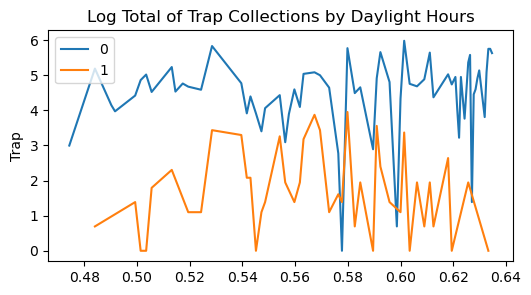

In [215]:
x_plot = [train_merged.groupby(by = ['Daylight(hr)','WnvPresent'], axis = 0).count().index[i][0] 
 for i in range(len(train_merged.groupby(by = ['Daylight(hr)','WnvPresent'], axis = 0).count()))]

# Trap Counts that correspond to the same days with similar daylight hours
# log graph to compare shape of both subsets more easily
y_plot = np.log(train_merged.groupby(by = ['Daylight(hr)','WnvPresent'], axis = 0).count()['Trap'])

# Getting list of corresponding WnvPresent values
hue = [train_merged.groupby(by = ['Daylight(hr)','WnvPresent'], axis = 0).count().index[i][1] 
 for i in range(len(train_merged.groupby(by = ['Daylight(hr)','WnvPresent'], axis = 0).count()))]

plt.figure(figsize=(6,3))
sns.lineplot(x=x_plot, 
             y=y_plot,
             hue=hue,
             ci=False)
plt.title('Log Total of Trap Collections by Daylight Hours');

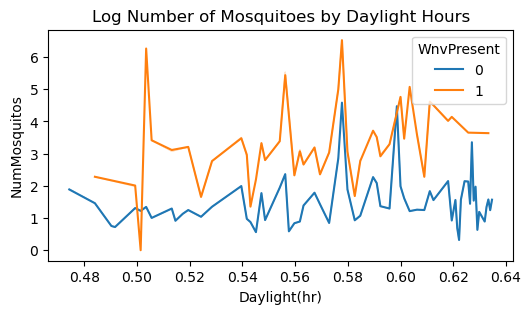

In [216]:
x2_plot = train_merged['Daylight(hr)']

# Number of mosquitoes
# log graph to compare shape of both subsets more easily
y2_plot = np.log(train_merged['NumMosquitos'])

# Getting list of corresponding WnvPresent values
hue2 = train_merged['WnvPresent']

plt.figure(figsize=(6,3))
sns.lineplot(x=x2_plot, 
             y=y2_plot,
             hue=hue2,
             ci=False)
plt.title('Log Number of Mosquitoes by Daylight Hours');

**Transfrom Lat & Long to Coordinates by tuple**

this will be treated as a catergorical instead of numeric value

In [217]:
train_merged['Coordinates'] =  list(zip(train_merged.Latitude, train_merged.Longitude))

**Address & AddressNumberAndStreet columns**

Address and AddressNumberAndStreet columns will be dropped as they are repeat information for block & street.Also Lat and Long coordinates are sufficient to idenify locations

In [218]:
train_merged.drop(['Address', 'AddressNumberAndStreet'], axis=1, inplace = True)

**Cyclical feature for Month and Day**

There are some features that are cyclic by nature. For example the hours of a day or the months in a year. In these cases, the higher values of the variable are closer to the lower values. For example, December (12) is closer to January (1) than to June (6). By applying a cyclical transformation we capture this cycle or proximity between values.([*source*](https://feature-engine.readthedocs.io/en/1.1.x/creation/CyclicalTransformer.html))

In [219]:
def cyclical_encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [220]:
train_merged = cyclical_encode(train_merged, 'Month', 12)
train_merged = cyclical_encode(train_merged, 'Day', 31)

In [221]:
train_merged[['Month_sin', 'Month_cos', 'Day_sin', 'Day_cos']].head()

Month_sin  Month_cos   Day_sin   Day_cos
0        0.5  -0.866025 -0.394356  0.918958
1        0.5  -0.866025 -0.394356  0.918958
2        0.5  -0.866025 -0.394356  0.918958
3        0.5  -0.866025 -0.394356  0.918958
4        0.5  -0.866025 -0.394356  0.918958

**Create clusters to group certain numeric columns together**

In [449]:
def plot_clusters(df, name):
    mks = itertools.cycle(['o', '*'])
    markers = [next(mks) for i in train_clus['WnvPresent'].unique()]
    names = df.columns.tolist()
    x,y,hue = names
    ax = sns.scatterplot(data=df, x=x, y=y, hue=hue,palette = "tab10",markers = markers)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set_title(name)
    plt.show()

In [223]:
def scale_matrix(df):
    X_scaled = StandardScaler().fit_transform(df)
    return X_scaled

In [224]:
def find_k(df):
    X_sc = scale_matrix(df)
    scores = [] # declaring empty list
    for k in range(2, 41): # k (representing num of clusters)--> running numbers from 2 to 30
        cl = KMeans(n_clusters=k) # instantiate k-means
        cl.fit(X_sc) # fit k-means on scaled X for every value of 'k' in range
        inertia = cl.inertia_ # getting intertia metric scores
        sil = silhouette_score(X_sc, cl.labels_) # getting silhouette scores
        scores.append([k, inertia, sil]) # append k (num of clusters), intertia, silhouette scores to initialized empty list

    score_df = pd.DataFrame(scores)
    score_df.columns = ['k', 'inertia', 'silhouette']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    axes[0].plot(score_df.k, score_df.inertia)
    axes[0].set_title('Inertia over k')
    axes[1].plot(score_df.k, score_df.silhouette);
    axes[1].set_title('Silhouette Score over k')

In [225]:
def plot_results(df, cl):
    
    names = df.columns.tolist()
    x,y,hue = names
    df_fil = df[[x, y]]

    ss = StandardScaler()
    df_scaled = ss.fit_transform(df_fil)

    cl = cl.fit(df_scaled)

    name = f'{cl}'.split('(')[0]
    print (f'{name} silhouette_score: {silhouette_score(df_scaled, cl.labels_):0.2f}')

    df_copy = df_fil.copy()       
    df_copy['cluster'] = cl.labels_

    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    ax1.scatter(x=df_copy[x], y=df_copy[y], c = df_copy['cluster'] )
    plt.title(x+'/'+y+' '+'cluster')

    centroids = pd.DataFrame(
    ss.inverse_transform(cl.cluster_centers_), # reverse-scale/un-scale previously scaled data
    columns=[x, y])

    ax1.scatter(x=centroids[x], y=centroids[y],marker="*" ,c=df_copy['cluster'].unique(), s=550 )

    plt.show()
    return df_copy['cluster']

In [226]:
train_clus = train_merged.copy()
train_clus = train_clus[['Latitude', 'Longitude','ResultSpeed','ResultDir','Tavg','RHumidity','WnvPresent']]
clus_latlong = train_clus[['Latitude', 'Longitude', 'WnvPresent']]
clus_wind = train_clus[['ResultSpeed','ResultDir','WnvPresent']]
clus_temphum = train_clus[['Tavg','RHumidity','WnvPresent']]

**Finding clusters between 2 parameters**

Clustering was carried out under the assumstion that there are clusters between the two features that are favourable for WNV presences

1) Clustering for Lat & Long
1) Clustering for Wind speed & Wind direction
1) Clustering for Temperature & RHumidity

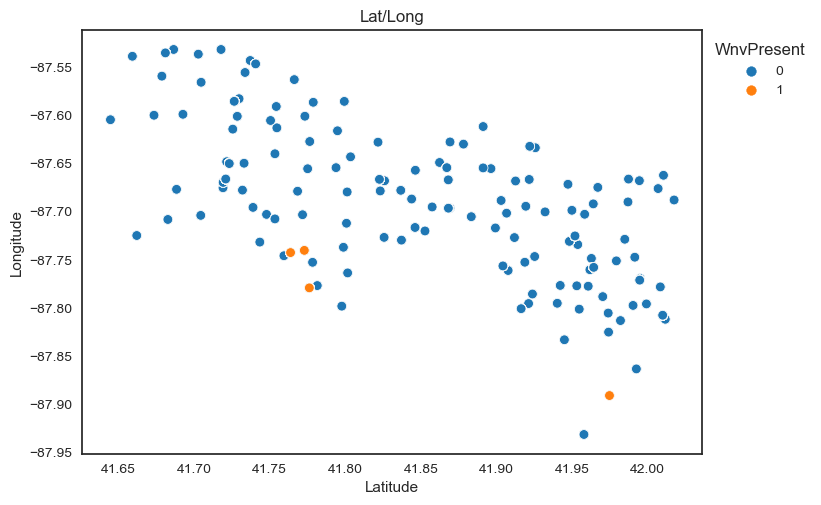

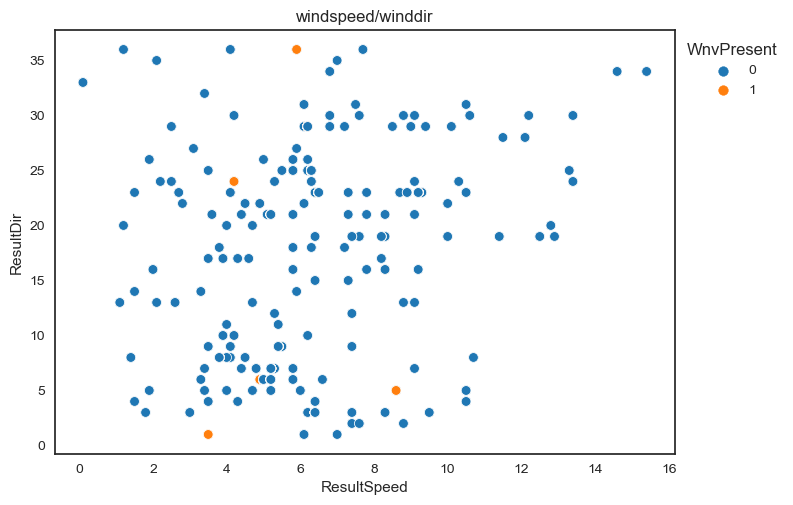

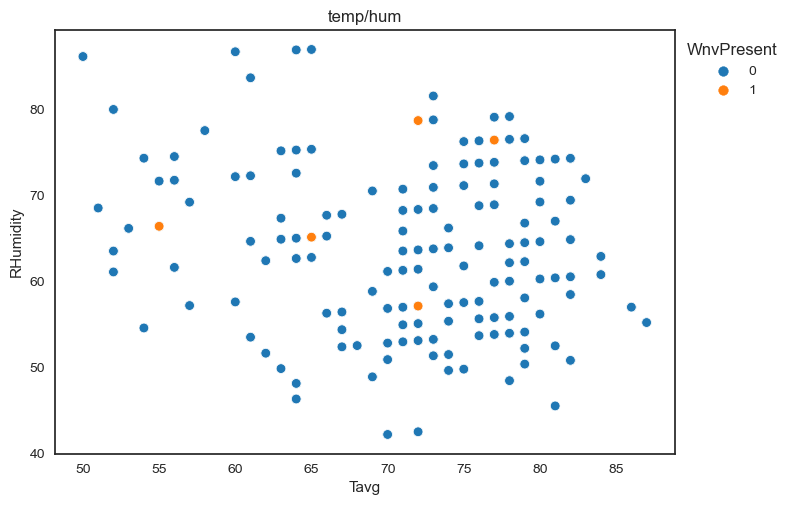

In [450]:
# check for clustering with Virus presence
dfs = [(clus_latlong, 'Lat/Long'),(clus_wind, 'windspeed/winddir') ,(clus_temphum, 'temp/hum') ]
[plot_clusters(df, name) for df, name in dfs];

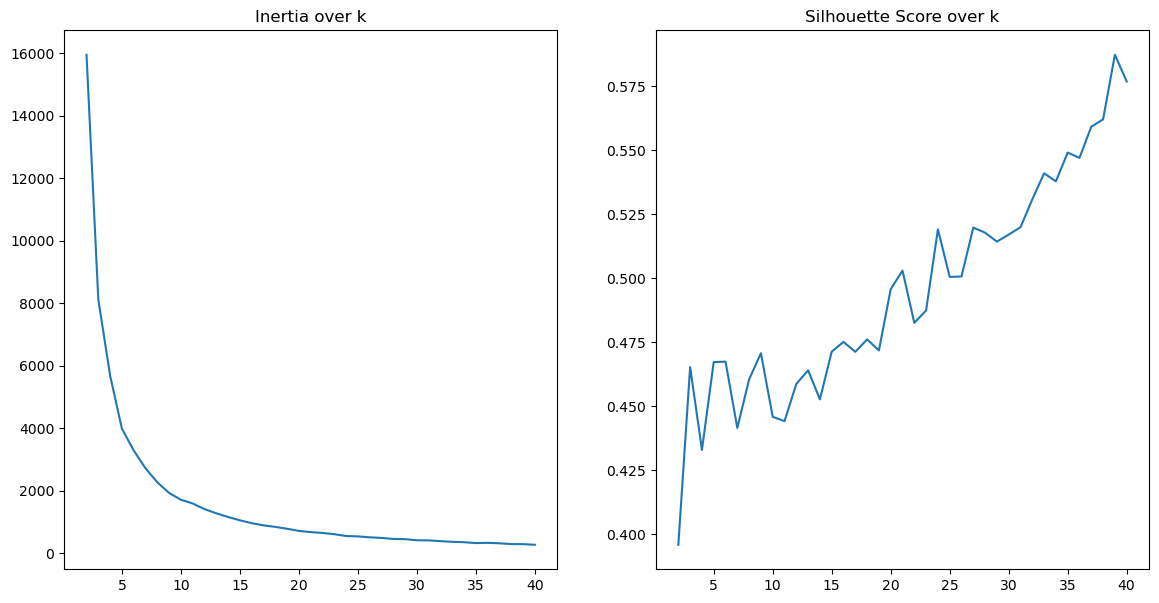

In [228]:
#finding optimimum k
find_k(clus_latlong)

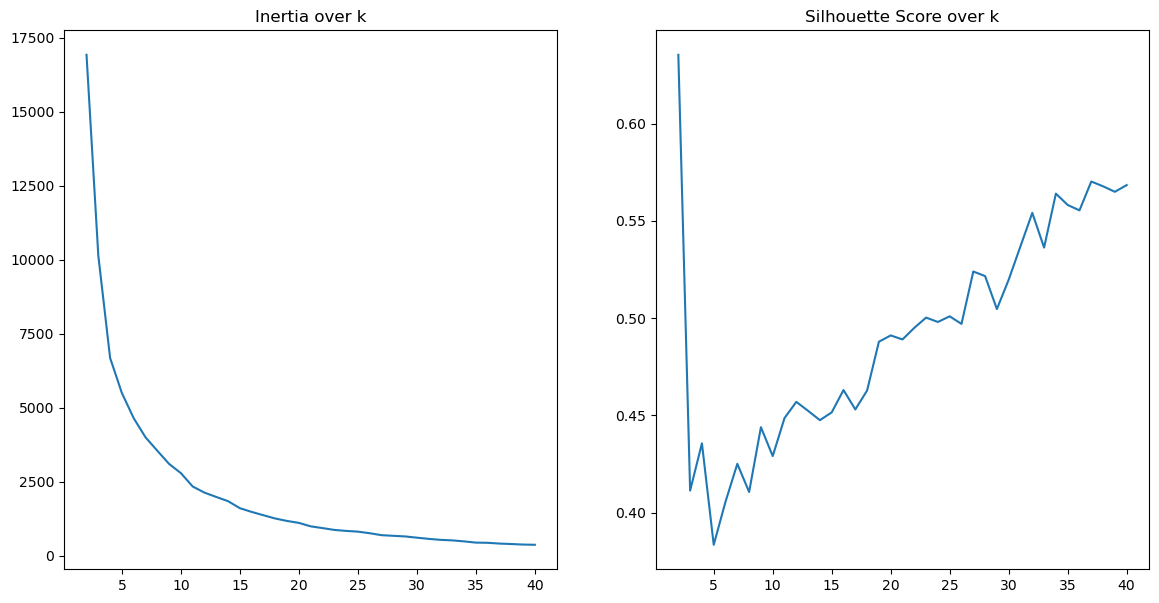

In [229]:
#finding optimimum k
find_k(clus_wind)

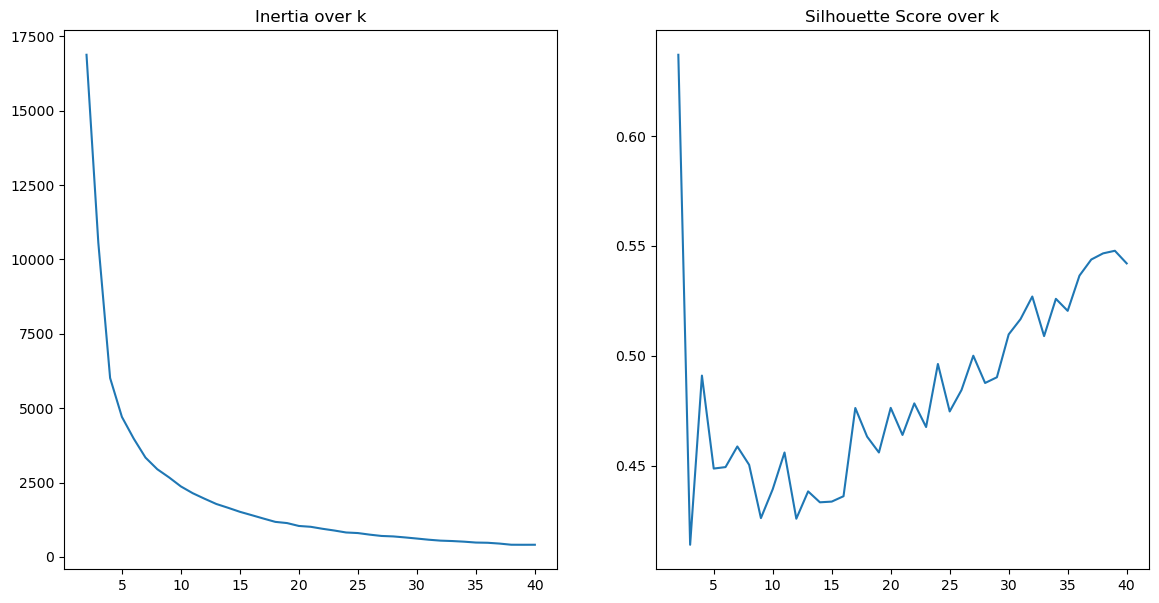

In [230]:
#finding optimimum k
find_k(clus_temphum)

**Clustering process**

KMeans silhouette_score: 0.49


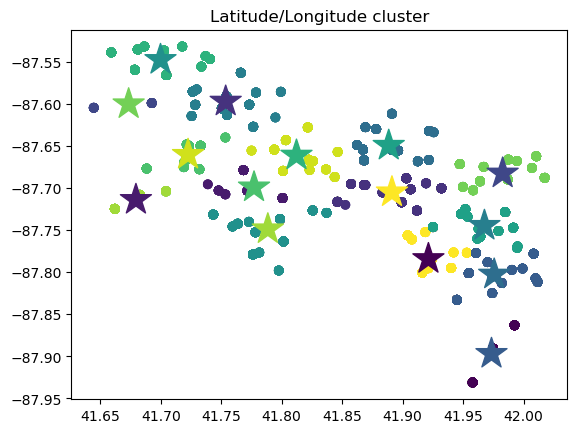

In [231]:
df = clus_latlong
cl = KMeans(n_clusters=15) #reasonable inertia
cluster_latlong = plot_results(df, cl)
cluster_latlong = cluster_latlong.rename('cluster_latlong')

KMeans silhouette_score: 0.49


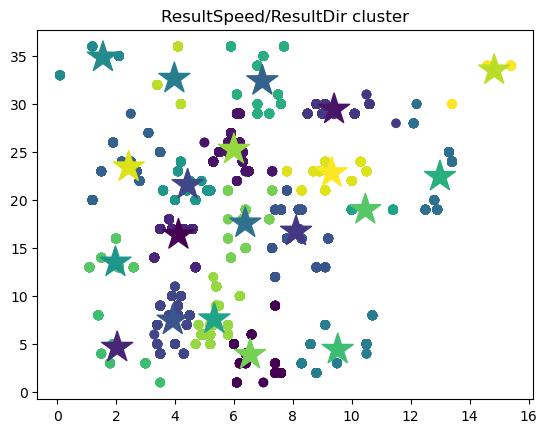

In [232]:
df = clus_wind
cl = KMeans(n_clusters=20) #reasonable inertia
cluster_wind = plot_results(df, cl)
cluster_wind = cluster_wind.rename('cluster_wind')

KMeans silhouette_score: 0.48


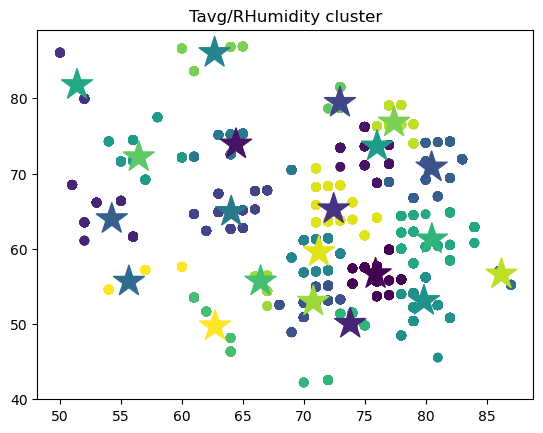

In [233]:
df = clus_temphum
cl = KMeans(n_clusters=21)  #reasonable inertia
cluster_temphum = plot_results(df, cl)
cluster_temphum = cluster_temphum.rename('cluster_temphum')

In [234]:
train_merged = pd.concat([train_merged, cluster_latlong,cluster_wind,cluster_temphum],axis =1)

**Checking correlation to Virus presence**

In [235]:
train_merged_coor = train_merged.copy()

In [236]:
train_merged_coor.columns

Index(['Date', 'Species', 'Block', 'Street', 'Trap', 'Latitude', 'Longitude',
       'AddressAccuracy', 'NumMosquitos', 'WnvPresent', 'Year', 'Month', 'Day',
       'Station', 'Tavg', 'Depart', 'Heat', 'Cool', 'GR', 'SQ', 'SN', 'FG+',
       'HZ', 'VCFG', 'MIFG', 'FG', 'RA', 'TSRA', 'DZ', 'TS', 'BCFG', 'FU',
       'VCTS', 'BR', 'PrecipTotal', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'Trange', 'RHumidity', 'Sunrise', 'Sunset', 'Daylight(hr)',
       'Coordinates', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos',
       'cluster_latlong', 'cluster_wind', 'cluster_temphum'],
      dtype='object')

In [237]:
train_merged_coor.drop(['Latitude', 'Longitude','Depart','Month', 'Heat', 'Cool'],axis=1,inplace = True)

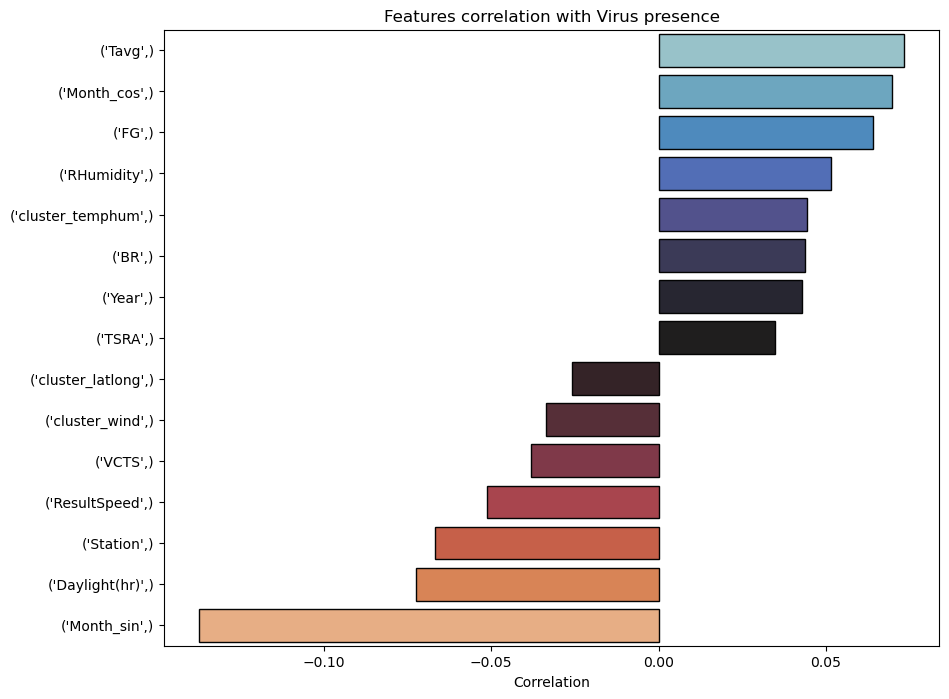

In [238]:
# checking Correraltion for features with Virus presences
virus_corr = train_merged_coor.corr()['WnvPresent'].drop(['WnvPresent','NumMosquitos']).sort_values(ascending = False)
virus_corr_fil = virus_corr[(virus_corr >= 0.025) | (virus_corr <= -0.025)]
virus_corrdf = pd.DataFrame({'VirusCorr':virus_corr_fil.tolist()}, index = [virus_corr_fil.index])

plt.figure(figsize=(10, 8))
g =sns.barplot(data=virus_corrdf.T,orient ='h',palette="icefire",linewidth=1, edgecolor=".01",)
plt.title("Features correlation with Virus presence")
g.set_xlabel("Correlation", fontsize = 10);

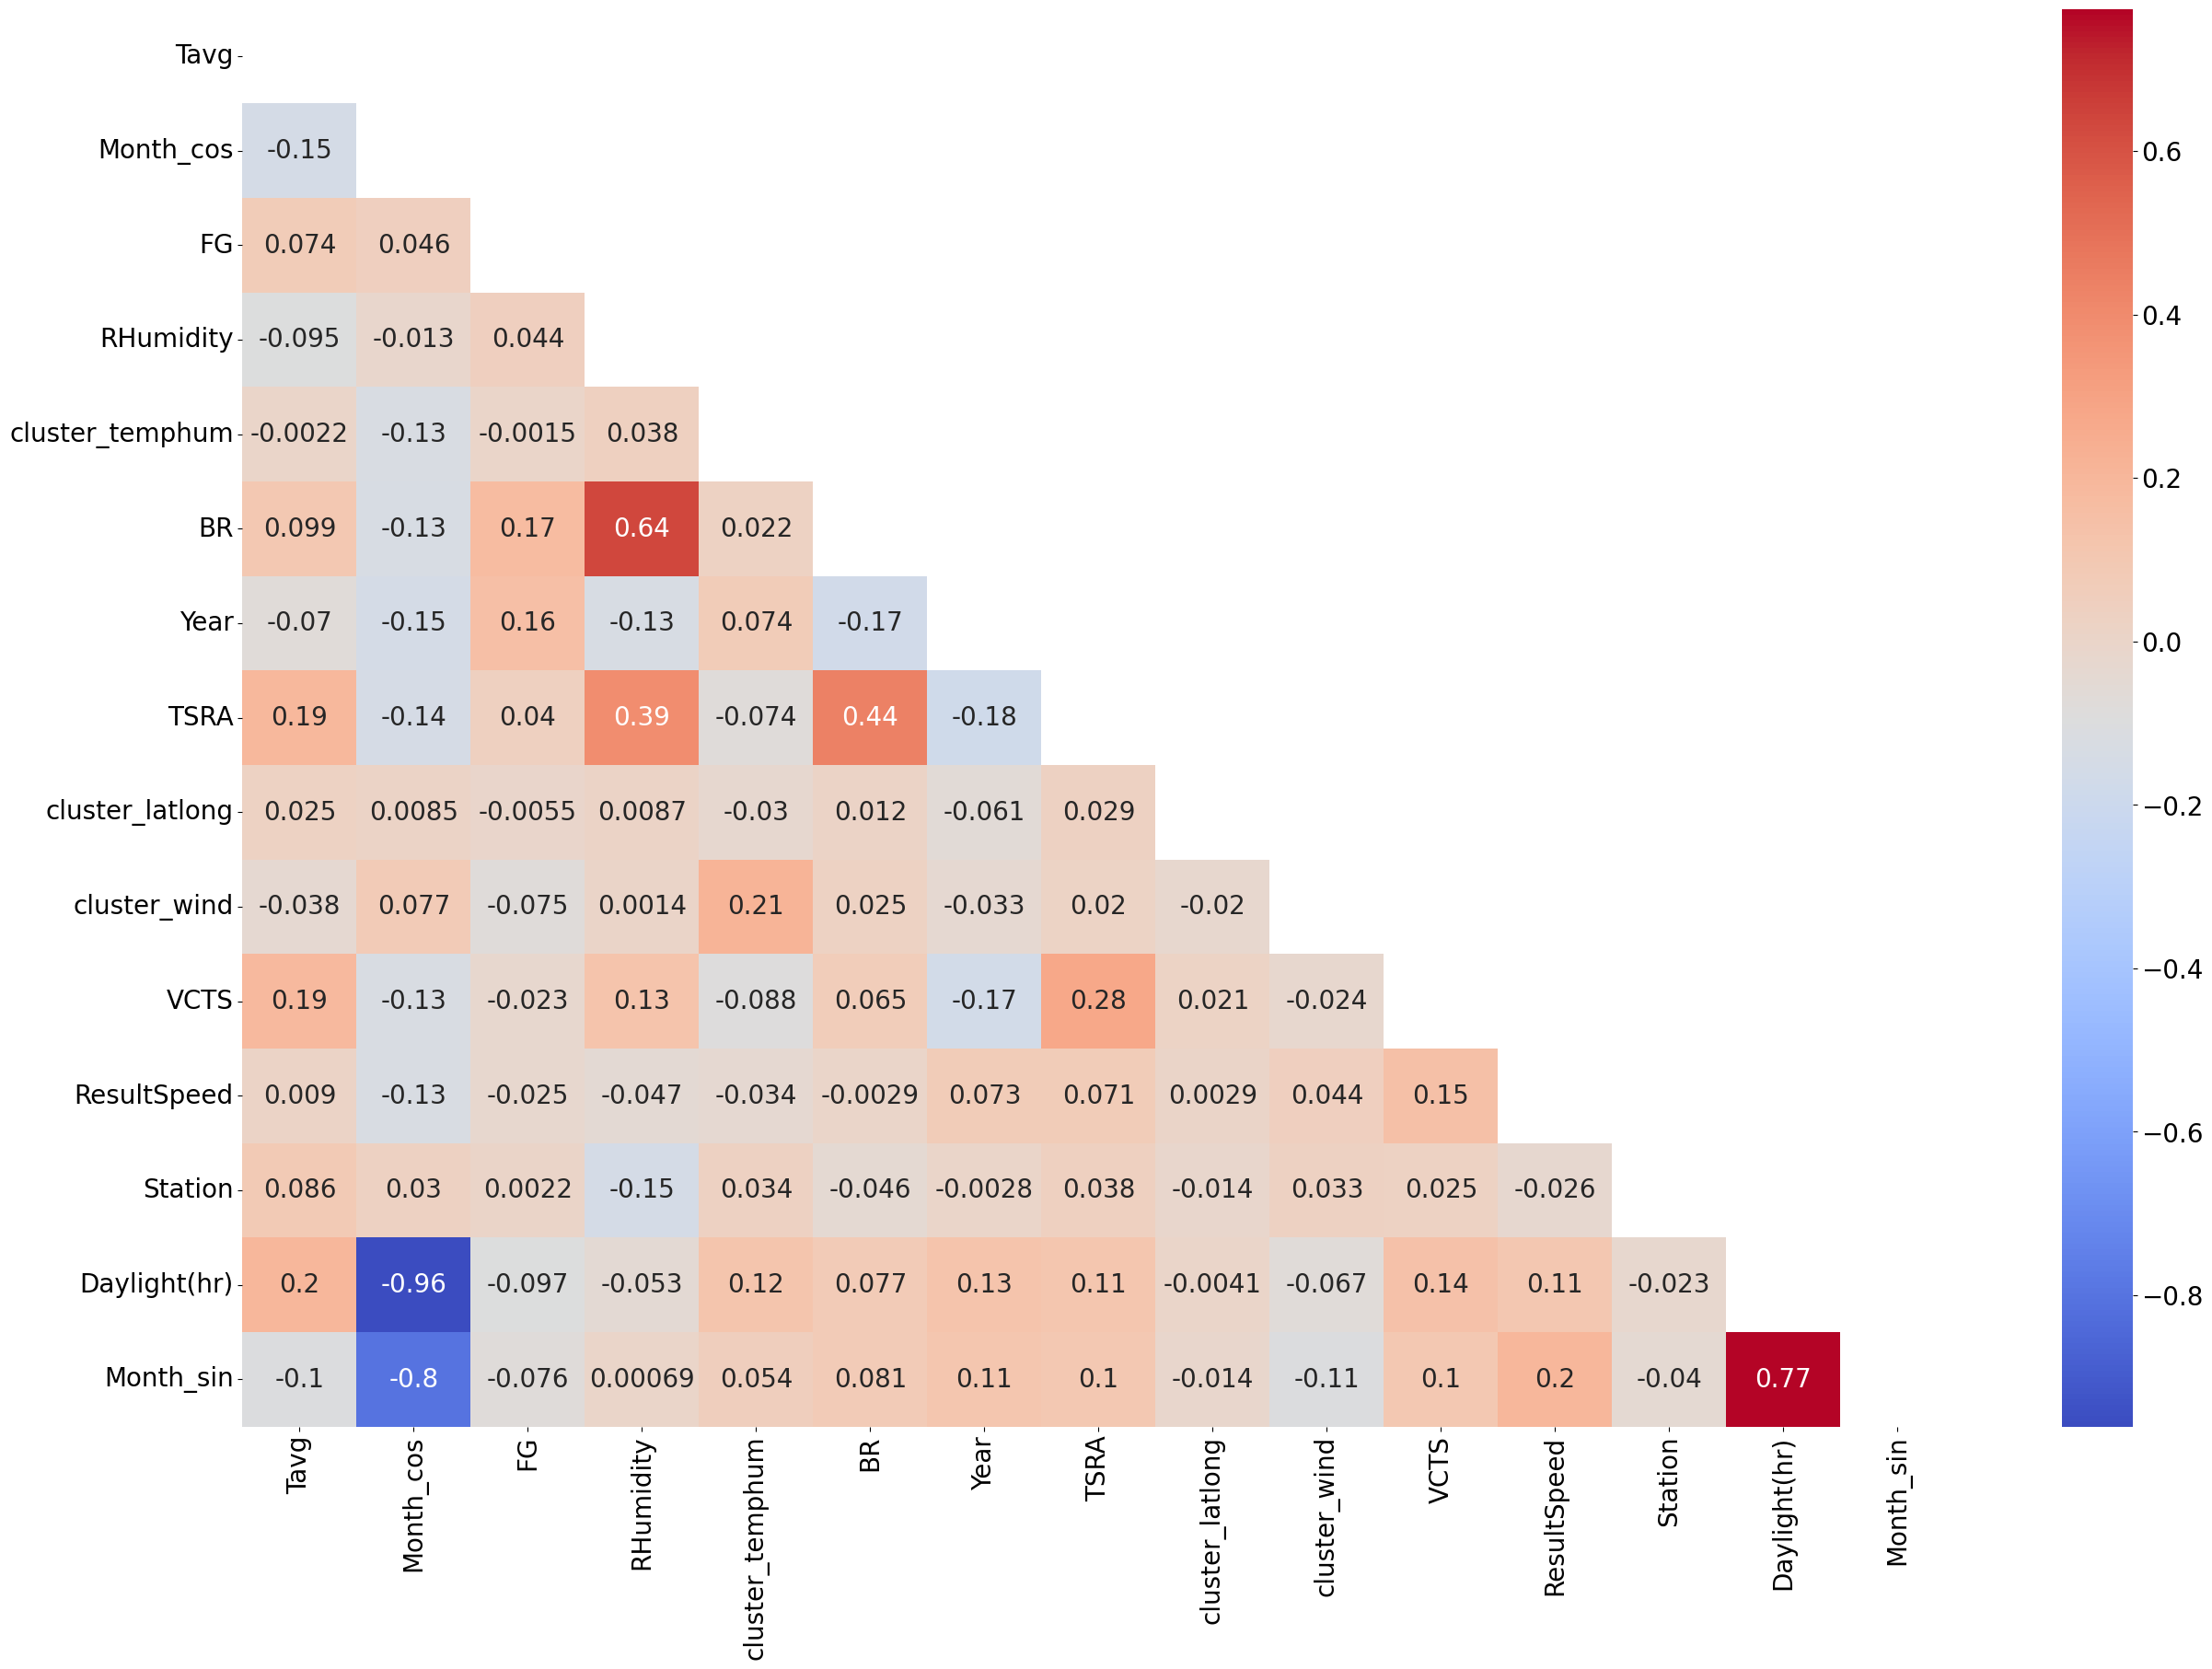

In [239]:
# Checking Correalation within features
plt.figure(figsize=(30,20))
plt.rcParams.update({'font.size': 20})
corr = train_merged_coor[virus_corr_fil.index.tolist()].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask, annot = True, cmap='coolwarm');

**Outlier check for Train_merged Dataframe**

In [240]:
def find_outliers(lis):
    outlier_col = []
    outlier_percent = []
    for item in lis:
        q1=train_merged[item].quantile(0.25)
        q3=train_merged[item].quantile(0.75)
        IQR=q3-q1
        if train_merged[item].min() <= (q1-1.5*IQR) or train_merged[item].max() >= (q3+1.5*IQR): 
            outlier_col.append(item)
            outlier_percent.append(((len(train_merged[train_merged[item] <= (q1-1.5*IQR)][item])+len(train_merged[train_merged[item] >= (q3+1.5*IQR)][item]))/len(train_merged[item]))*100)
    outlier_df = pd.DataFrame(list(zip(outlier_col, outlier_percent)),columns =['Feature', 'Outlier %']) 
    return outlier_df

In [241]:
lis = train_merged.select_dtypes(include=['int','float']).columns
outliers = find_outliers(lis)
ss_outlier = StandardScaler()
train_df_scal = ss_outlier.fit_transform(train_merged[outliers.Feature]) 
train_df_scal = pd.DataFrame(train_df_scal, columns = train_merged[outliers.Feature].columns) # scaling is only for ploting purposes
num_only = ['Longitude','Tavg','Heat','PrecipTotal', 'SeaLevel','ResultSpeed', 'Trange']
train_df_scal = train_df_scal[num_only]

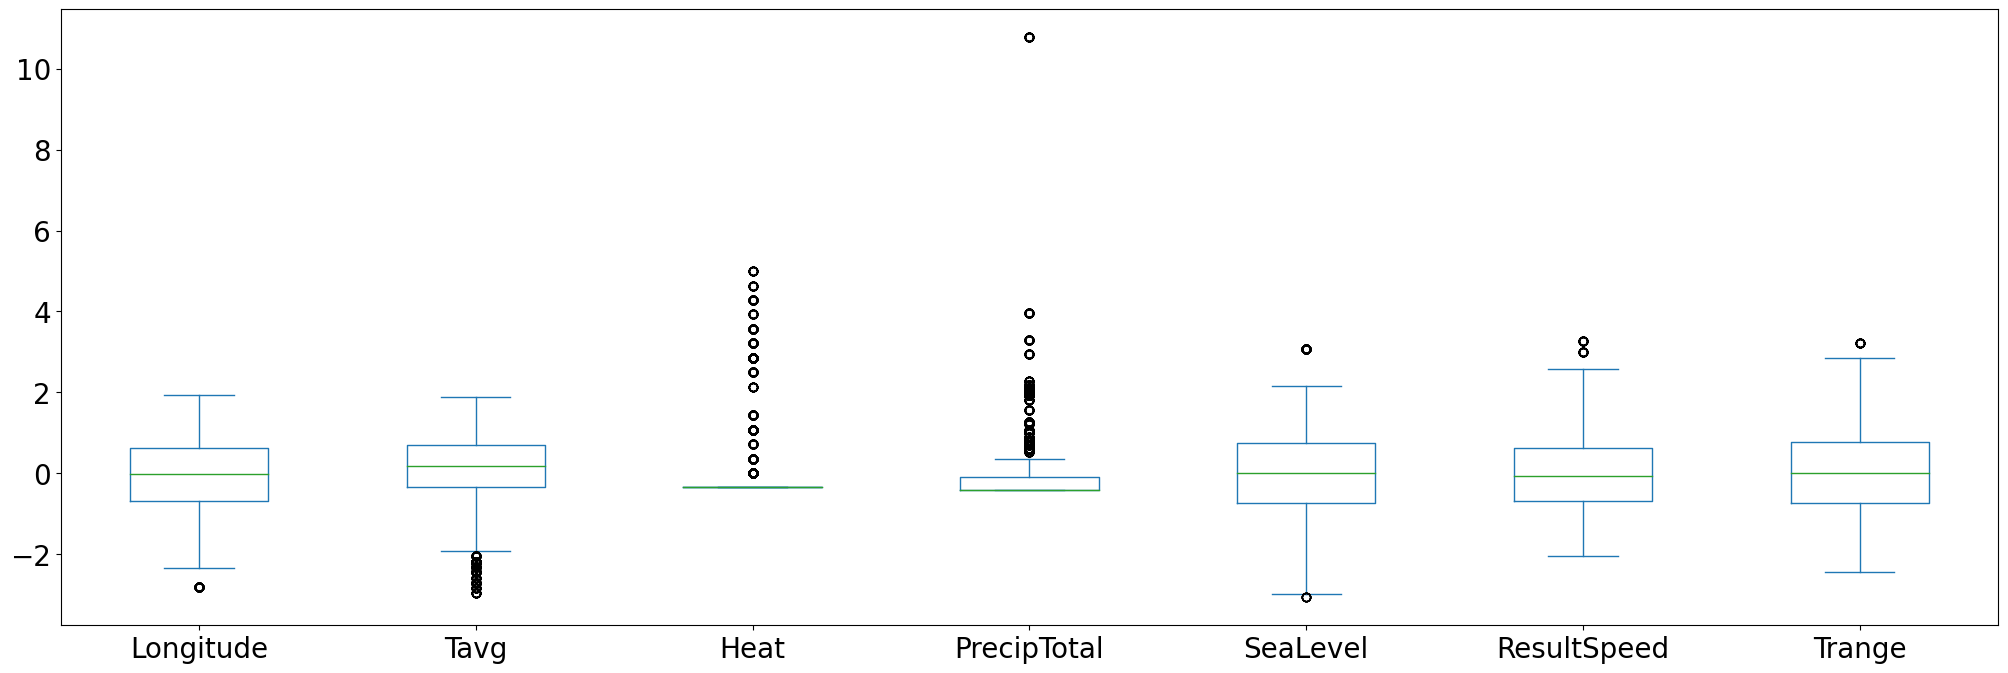

In [242]:
train_df_scal.plot.box(figsize=(25, 8));

In [243]:
# drop Max Outlier1 for ['ResultSpeed']
drop1 = train_merged[train_merged['ResultSpeed'] == train_merged['ResultSpeed'].max()].index
train_merged.drop(drop1,inplace= True)
train_merged.shape

(8447, 51)

In [244]:
# drop Max Outlier1 for ['ResultSpeed']
drop2 = train_merged[train_merged['ResultSpeed'] == train_merged['ResultSpeed'].max()].index
train_merged.drop(drop2,inplace= True)
train_merged.shape

(8422, 51)

In [245]:
# drop Max Outlier1 for ['ResultSpeed']
drop3 = train_merged[train_merged['Trange'] == train_merged['Trange'].max()].index
train_merged.drop(drop3,inplace= True)
train_merged.shape

(8403, 51)

In [246]:
train_merged = train_merged.reset_index(drop = True)

In [247]:
train_merged.to_csv('./Assets/input/train_merged.csv', index=False)

## 3.0.0 Modeling

Accuracy will be main metric scoring to judge how well model predict TP and NP and also overfitting of the model
Recall will be sub metric scoring as to have correct prediction of virus presence is crucial

In [248]:
from sklearn.model_selection import train_test_split, GridSearchCV 
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE, SMOTENC
from pycaret.classification import *
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay,roc_auc_score
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression

In [249]:
# Function for displaying scores and Confusion matrix
def display_scores(model,X_train,y_train,X_test,y_test):
    cm = confusion_matrix(y_test, model.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not present', 'Present'])
    disp.plot();

    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict(X_test))
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot();
    
    tn, fp, fn, tp = cm.ravel()
    print(f'Accuracy_score(train):{model.score(X_train,y_train):0.2f}')
    print(f'Accuracy_score(test):{(tp+tn)/(tp+fn+fp+tn):0.2f}')
    print(f'MisclassificationRate_score(test):{1-((tp+tn)/(tp+fn+fp+tn)):0.2f}')
    print(f'Recall_score(test):{tp/(fn+tp):0.2f}') 
    print(f'Specificity_score(test):{tn/(fp+tn):0.2f}') 
    print(f'Precision_score(test):{tp/(tp+fp):0.2f}') 
    print(f'F1_score(test):{f1_score(y_test, model.predict(X_test)):0.2f}')
    print(f'ROC_AUC_score(test):{roc_auc:0.2f}')

In [250]:
# Function for displaying scores and Confusion matrix only for pycaret usage
def pycaret_get_cm(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not present', 'Present'])
    disp.plot();
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot();
    
    tn, fp, fn, tp = cm.ravel()
    print(f'Accuracy_score(test):{(tp+tn)/(tp+fn+fp+tn):0.2f}')
    print(f'MisclassificationRate_score(test):{1-((tp+tn)/(tp+fn+fp+tn)):0.2f}')
    print(f'Recall_score(test):{tp/(fn+tp):0.2f}') 
    print(f'Specificity_score(test):{tn/(fp+tn):0.2f}') 
    print(f'Precision_score(test):{tp/(tp+fp):0.2f}') 
    print(f'F1_score(test):{f1_score(y_test, y_pred):0.2f}')
    print(f'ROC_AUC_score(test):{roc_auc:0.2f}')

### 3.1.0 Models

**Declare X and Y (Train.csv) for modeling**

In [251]:
train_merged.columns

Index(['Date', 'Species', 'Block', 'Street', 'Trap', 'Latitude', 'Longitude',
       'AddressAccuracy', 'NumMosquitos', 'WnvPresent', 'Year', 'Month', 'Day',
       'Station', 'Tavg', 'Depart', 'Heat', 'Cool', 'GR', 'SQ', 'SN', 'FG+',
       'HZ', 'VCFG', 'MIFG', 'FG', 'RA', 'TSRA', 'DZ', 'TS', 'BCFG', 'FU',
       'VCTS', 'BR', 'PrecipTotal', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'Trange', 'RHumidity', 'Sunrise', 'Sunset', 'Daylight(hr)',
       'Coordinates', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos',
       'cluster_latlong', 'cluster_wind', 'cluster_temphum'],
      dtype='object')

In [252]:
features = virus_corr_fil.index.tolist() + ['Species','Trap','Coordinates']

In [253]:
features

['Tavg',
 'Month_cos',
 'FG',
 'RHumidity',
 'cluster_temphum',
 'BR',
 'Year',
 'TSRA',
 'cluster_latlong',
 'cluster_wind',
 'VCTS',
 'ResultSpeed',
 'Station',
 'Daylight(hr)',
 'Month_sin',
 'Species',
 'Trap',
 'Coordinates']

In [254]:
X = train_merged[features]
X = pd.get_dummies(data=X, columns=['Species','Trap','Coordinates'], drop_first=True)
len(X.columns)

293

- ***Prepare Test.csv similar to Train.csv for comparsion***

In [255]:
def get_test_cluster(df, cl):
    
    names = df.columns.tolist()
    x,y = names
    df_fil = df[[x, y]]

    ss = StandardScaler()
    df_scaled = ss.fit_transform(df_fil)

    cl = cl.fit(df_scaled)

    name = f'{cl}'.split('(')[0]
    print (f'{name} silhouette_score: {silhouette_score(df_scaled, cl.labels_):0.2f}')

    df_copy = df_fil.copy()       
    df_copy['cluster'] = cl.labels_

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.patch.set_facecolor('xkcd:light grey blue')
    color_labels = df_copy['cluster'].unique()

    rgb_values = sns.color_palette("Spectral",25)

    color_map = dict(zip(color_labels, rgb_values))
    
    ax1.scatter(x=df_copy[x], y=df_copy[y], c = df_copy['cluster'].map(color_map),edgecolors= "black" )
    plt.title(x+'/'+y+' '+'cluster')

    centroids = pd.DataFrame(
    ss.inverse_transform(cl.cluster_centers_), # reverse-scale/un-scale previously scaled data
    columns=[x, y])

    ax1.scatter(x=centroids[x], y=centroids[y],marker="*" ,c=df_copy['cluster'].unique(), s=550,edgecolors= "black" )

    plt.show()
    return df_copy['cluster']

In [256]:
def input_station(lat:int, lng:int):
    stn1 = (41.995, -87.933)
    stn2 = (41.786, -87.752)
    coord = (lat, lng)
    
    if (geodesic(coord, stn1) 
        < geodesic(coord, stn2)):
        return 1
    
    else:
        return 2

In [257]:
test_df['Date'] = pd.to_datetime(test_df['Date'])
weather_df['Date'] = pd.to_datetime(weather_df['Date'])


test_df['Street'] = test_df['Street'].str.strip()

test_df['Coordinates'] =  list(zip(test_df.Latitude, test_df.Longitude))

test_df['Station'] = test_df.apply(lambda x: input_station(x['Latitude'], x['Longitude']), axis=1)

In [258]:
test_merged = test_df.copy()
test_merged = test_merged.merge(weather_df, how="left", on=["Station", "Date"])
test_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 44 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      116293 non-null  int64         
 1   Date                    116293 non-null  datetime64[ns]
 2   Address                 116293 non-null  object        
 3   Species                 116293 non-null  object        
 4   Block                   116293 non-null  int64         
 5   Street                  116293 non-null  object        
 6   Trap                    116293 non-null  object        
 7   AddressNumberAndStreet  116293 non-null  object        
 8   Latitude                116293 non-null  float64       
 9   Longitude               116293 non-null  float64       
 10  AddressAccuracy         116293 non-null  int64         
 11  Year                    116293 non-null  int64         
 12  Month                   116293

In [259]:
test_merged['Daylight(hr)'] = pd.to_datetime(test_merged['Sunset']) - pd.to_datetime(test_merged['Sunrise'])
test_merged['Daylight(hr)'] = test_merged['Daylight(hr)'].apply(lambda x:x.total_seconds()/86400)

In [260]:
test_clus = test_merged.copy()

In [261]:
test_clus = test_clus[['Latitude', 'Longitude','ResultSpeed','ResultDir','Tavg','RHumidity']]
Tclus_latlong = test_clus[['Latitude', 'Longitude']]
Tclus_wind = test_clus[['ResultSpeed','ResultDir']]
Tclus_temphum = test_clus[['Tavg','RHumidity']]

KMeans silhouette_score: 0.48


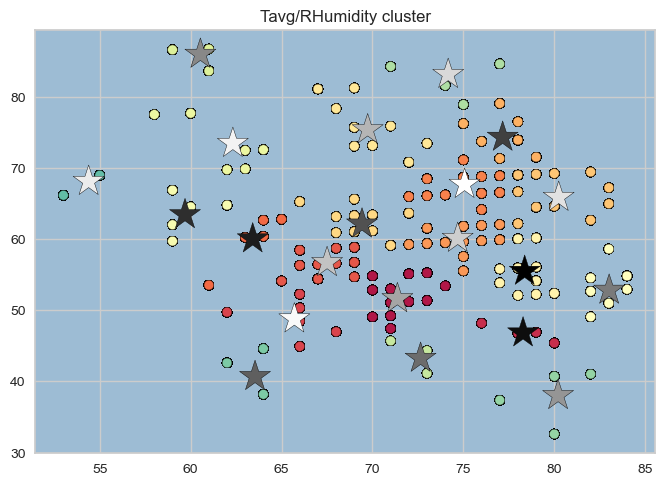

Wall time: 4min 39s


In [262]:
%%time
df = Tclus_temphum
cl = KMeans(n_clusters=21)
Tcluster_temphum = get_test_cluster(df, cl)
Tcluster_temphum = Tcluster_temphum.rename('cluster_temphum')

KMeans silhouette_score: 0.47


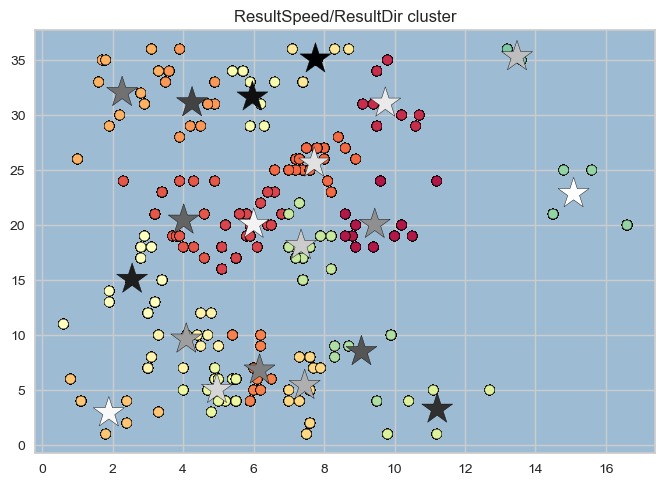

Wall time: 4min 24s


In [263]:
%%time
df = Tclus_wind
cl = KMeans(n_clusters=20)
Tcluster_wind = get_test_cluster(df, cl)
Tcluster_wind = Tcluster_wind.rename('cluster_wind')

KMeans silhouette_score: 0.43


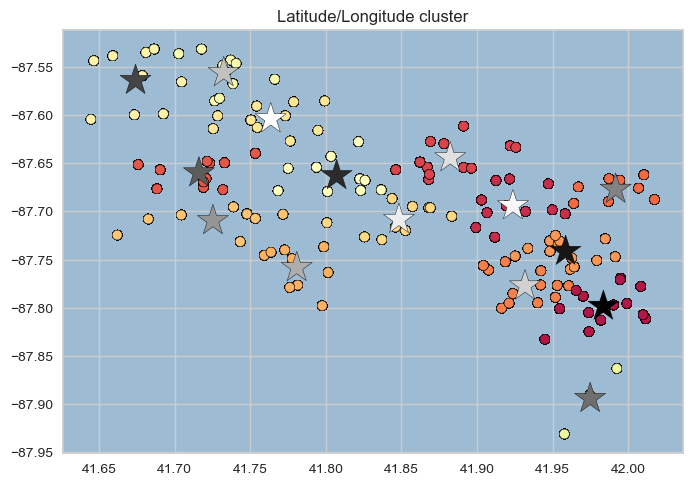

Wall time: 3min 54s


In [264]:
%%time
df = Tclus_latlong
cl = KMeans(n_clusters=15) #reasonable inertia
Tcluster_latlong = get_test_cluster(df, cl)
Tcluster_latlong = Tcluster_latlong.rename('cluster_latlong')

In [265]:
test_merged = pd.concat([test_merged,Tcluster_wind,Tcluster_temphum,Tcluster_latlong],axis =1)

In [266]:
test_merged = cyclical_encode(test_merged, 'Month', 12)
test_merged = cyclical_encode(test_merged, 'Day', 31)

In [267]:
compare = pd.get_dummies(data=test_merged[features], columns=['Species','Trap','Coordinates'], drop_first=True)

- **Compare difference with Train and Test and modify train columns to test columns**

In [268]:
to_add_lis = list(set(compare)-set(X))

for col in to_add_lis:
    X.insert(17,col,0, True)

In [269]:
len(X.columns)

320

In [270]:
train_df.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'Year', 'Month', 'Day', 'Station'],
      dtype='object')

In [271]:
y = train_merged['WnvPresent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
y_train.value_counts()

0    5959
1     343
Name: WnvPresent, dtype: int64

In [272]:
features

['Tavg',
 'Month_cos',
 'FG',
 'RHumidity',
 'cluster_temphum',
 'BR',
 'Year',
 'TSRA',
 'cluster_latlong',
 'cluster_wind',
 'VCTS',
 'ResultSpeed',
 'Station',
 'Daylight(hr)',
 'Month_sin',
 'Species',
 'Trap',
 'Coordinates']

In [273]:
numeric_features = ['Month_cos', 'Tavg', 'RHumidity', 'Year', 'ResultSpeed', 'Daylight(hr)', 'Month_sin']

X_train_numeric = X_train[numeric_features]
X_test_numeric = X_test[numeric_features]

In [274]:
# define categorical features
X_train_categorical = X_train.drop(columns=numeric_features, axis=1)
X_test_categorical = X_test.drop(columns=numeric_features, axis=1)

In [275]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train_numeric)
X_train_ss = pd.DataFrame(X_train_ss, columns = X_train_numeric.columns, index = X_train_numeric.index)
X_test_ss = ss.transform(X_test_numeric)
X_test_ss = pd.DataFrame(X_test_ss, columns = X_test_numeric.columns, index = X_test_numeric.index)

In [276]:
X_train_sc = pd.concat([X_train_ss, X_train_categorical], axis=1)
X_test_sc = pd.concat([X_test_ss, X_test_categorical], axis=1)

- **SMOTE resampling** ([*source*](https://www.kaggle.com/code/residentmario/oversampling-with-smote-and-adasyn/notebook))

The SMOTE algorithm is parameterized with k_neighbors (the number of nearest neighbors it will consider) and the number of new points you wish to create. Each step of the algorithm will:

1) Randomly select a minority point.
1) Randomly select any of its k_neighbors nearest neighbors belonging to the same class.
1) Randomly specify a lambda value in the range [0, 1].
1) Generate and place a new point on the vector between the two points, located lambda percent of the way from the original point.

In [277]:
X_train_sm, y_train_sm = SMOTE(random_state=42).fit_resample(X_train_sc, y_train)
y_train_sm.value_counts()

0    5959
1    5959
Name: WnvPresent, dtype: int64

- **ADASYN resampling**([*source*](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN.html?highlight=adasyn#imblearn.over_sampling.ADASYN))

This method is similar to SMOTE but it generates different number of samples depending on an estimate of the local distribution of the class to be oversampled.

In [278]:
X_train_ada, y_train_ada = ADASYN().fit_resample(X_train_sc, y_train)
y_train_ada.value_counts()

0    5959
1    5835
Name: WnvPresent, dtype: int64

- **SVMSMOTE resampling** ([*source*](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SVMSMOTE.html#))

Variant of SMOTE algorithm which use an SVM algorithm to detect sample to use for generating new synthetic samples.

In [279]:
X_train_svm, y_train_svm = SVMSMOTE(random_state=42).fit_resample(X_train_sc, y_train)
y_train_svm.value_counts()

0    5959
1    5959
Name: WnvPresent, dtype: int64

- **SMOTENC resampling**([*source*](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html))

Synthetic Minority Over-sampling Technique for Nominal and Continuous.

Unlike SMOTE, SMOTE-NC for dataset containing numerical and categorical features. However, it is not designed to work with only categorical features.

In [280]:
%%time
cat = X_train_categorical.columns
cat_index =[]
for col in cat:
    cat_index.append(X_train_sc.columns.get_loc(col))
X_train_smnc, y_train_smnc = SMOTENC(categorical_features= cat_index,random_state=42).fit_resample(X_train_sc, y_train)
y_train_smnc.value_counts()

Wall time: 27.7 s


0    5959
1    5959
Name: WnvPresent, dtype: int64

- **PCA** ([*source*](https://www.sartorius.com/en/knowledge/science-snippets/what-is-principal-component-analysis-pca-and-how-it-is-used-507186))

Principal component analysis is a statistical procedure that allows you to summarize the information content in large data tables by means of a smaller set of “summary indices” that can be more easily visualized and analyzed.

In [501]:
pca = PCA(n_components = 15, random_state = 42)
Z_train = pca.fit_transform(X_train_smnc)
Z_train = pd.DataFrame(Z_train)
Z_test = pca.transform(X_test_sc)
Z_test = pd.DataFrame(Z_test,index = y_test.index)

In [502]:
# Generate the cumulative explained variance.
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance: {np.round(cum_var_exp[:30],3)}')

Cumulative explained variance: [0.438 0.726 0.907 0.93  0.948 0.959 0.967 0.975 0.979 0.982 0.984 0.985
 0.986 0.987 0.988]


- **Complete Test preperation for prediction**

In [283]:
XTest = test_merged[features]
XTest = pd.get_dummies(data=XTest , columns=['Species','Trap','Coordinates'], drop_first=True)

In [284]:
XTest_numeric = XTest[numeric_features]
XTest_categorical = XTest.drop(columns=numeric_features, axis=1)

In [285]:
XTest_ss = ss.transform(XTest_numeric)
XTest_ss = pd.DataFrame(XTest_ss, columns = XTest_numeric.columns, index = XTest_numeric.index)

In [286]:
XTest_sc = pd.concat([XTest_ss, XTest_categorical], axis=1)

#### 3.1.1.1 Baseline Logistic Regression model (No resampling)

In [287]:
%%time
lr_pipe = Pipeline([
                    ('logreg',  LogisticRegression()) 
                    ])

lr_pipe_params = {
                 'logreg__C': np.linspace(0, 15,5),
                 'logreg__class_weight': ['balanced',{0:1,1:8},{0:1,1:16}],
                 'logreg__max_iter': [1000],
                 'logreg__n_jobs': [-1],
                 'logreg__l1_ratio':np.linspace(0, 1,4)
                 }

gs = GridSearchCV(lr_pipe, 
                  param_grid=lr_pipe_params,
                  cv=5,
                  verbose = 1,
                  n_jobs=-1,
                  scoring = 'recall'
                 ).fit(X_train_sc, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.3min finished


Wall time: 5min 39s


In [288]:
pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
12      22.895922      3.632542         0.019254        0.003374   
15      25.906969      4.704139         0.015721        0.001151   
14      20.198323      1.102045         0.020909        0.004290   
13      24.435679      2.579479         0.017387        0.004749   
25      25.661791      1.118617         0.014806        0.000383   

   param_logreg__C param_logreg__class_weight param_logreg__l1_ratio  \
12            3.75                   balanced                    0.0   
15            3.75                   balanced                    1.0   
14            3.75                   balanced               0.666667   
13            3.75                   balanced               0.333333   
25             7.5                   balanced               0.333333   

   param_logreg__max_iter param_logreg__n_jobs  \
12                   1000                   -1   
15                   1000                   -1   
14                   1000                   -1   
13                   1000                   -1   
25                   1000                   -1   

                                               params  split0_test_score  \
12  {'logreg__C': 3.75, 'logreg__class_weight': 'b...           0.753623   
15  {'logreg__C': 3.75, 'logreg__class_weight': 'b...           0.753623   
14  {'logreg__C': 3.75, 'logreg__class_weight': 'b...           0.753623   
13  {'logreg__C': 3.75, 'logreg__class_weight': 'b...           0.753623   
25  {'logreg__C': 7.5, 'logreg__class_weight': 'ba...           0.753623   

    split1_test_score  split2_test_score  split3_test_score  \
12           0.724638           0.764706           0.720588   
15           0.724638           0.764706           0.720588   
14           0.724638           0.764706           0.720588   
13           0.724638           0.764706           0.720588   
25           0.710145           0.764706           0.720588   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
12           0.797101         0.752131        0.028048                1  
15           0.797101         0.752131        0.028048                1  
14           0.797101         0.752131        0.028048                1  
13           0.797101         0.752131        0.028048                1  
25           0.797101         0.749233        0.031300                5

Accuracy_score(train):0.87
Accuracy_score(test):0.75
MisclassificationRate_score(test):0.25
Recall_score(test):0.69
Specificity_score(test):0.75
Precision_score(test):0.14
F1_score(test):0.23
ROC_AUC_score(test):0.72


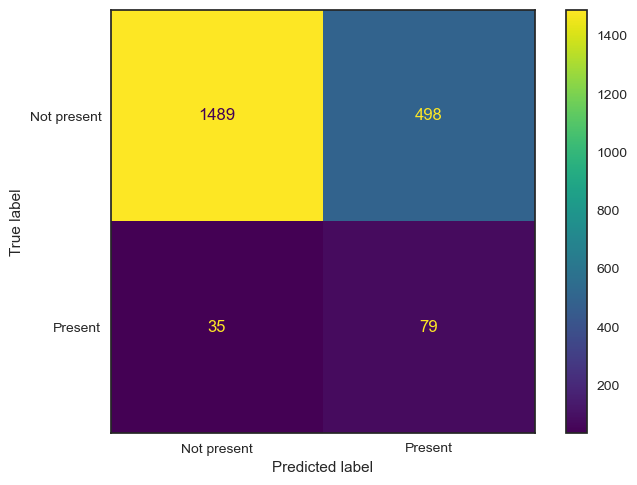

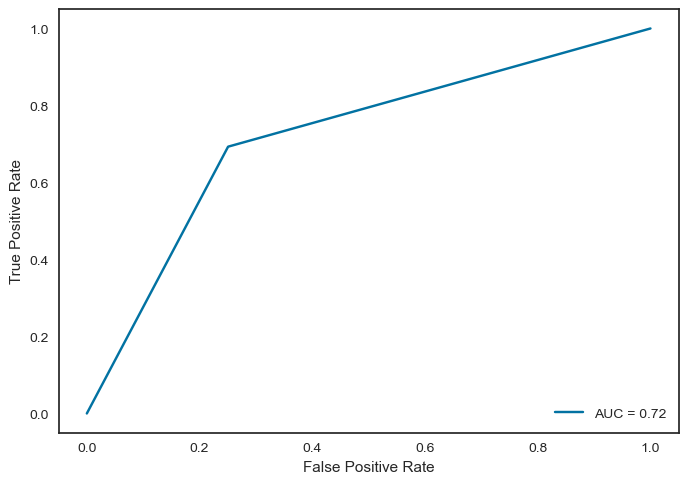

In [289]:
# Scores for Train.csv (test)
sns.set_style('white')
display_scores(gs,X_train_sc,y_train,X_test_sc,y_test)

#### 3.1.1.2 Baseline Logistic Regression model (SMOTE)

In [290]:
%%time

gs_smote = GridSearchCV(lr_pipe, 
                  param_grid=lr_pipe_params,
                  cv=5,
                  verbose = 1,
                  n_jobs=-1,
                  scoring = 'recall'
                 ).fit(X_train_sm, y_train_sm)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.9min finished


Wall time: 9min 39s


In [291]:
pd.DataFrame(gs_smote.cv_results_).sort_values('rank_test_score').head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
23      52.499477      2.488347         0.023601        0.002745   
22      51.040447      2.310248         0.048607        0.048250   
21      45.088601     10.371571         0.016366        0.002721   
20      36.233581     12.653540         0.024330        0.005504   
32      39.217724     15.066676         0.161281        0.277686   

   param_logreg__C param_logreg__class_weight param_logreg__l1_ratio  \
23            3.75              {0: 1, 1: 16}                    1.0   
22            3.75              {0: 1, 1: 16}               0.666667   
21            3.75              {0: 1, 1: 16}               0.333333   
20            3.75              {0: 1, 1: 16}                    0.0   
32             7.5              {0: 1, 1: 16}                    0.0   

   param_logreg__max_iter param_logreg__n_jobs  \
23                   1000                   -1   
22                   1000                   -1   
21                   1000                   -1   
20                   1000                   -1   
32                   1000                   -1   

                                               params  split0_test_score  \
23  {'logreg__C': 3.75, 'logreg__class_weight': {0...           0.793624   
22  {'logreg__C': 3.75, 'logreg__class_weight': {0...           0.793624   
21  {'logreg__C': 3.75, 'logreg__class_weight': {0...           0.793624   
20  {'logreg__C': 3.75, 'logreg__class_weight': {0...           0.793624   
32  {'logreg__C': 7.5, 'logreg__class_weight': {0:...           0.792785   

    split1_test_score  split2_test_score  split3_test_score  \
23                1.0                1.0                1.0   
22                1.0                1.0                1.0   
21                1.0                1.0                1.0   
20                1.0                1.0                1.0   
32                1.0                1.0                1.0   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
23           0.999161         0.958557        0.082467                1  
22           0.999161         0.958557        0.082467                1  
21           0.999161         0.958557        0.082467                1  
20           0.999161         0.958557        0.082467                1  
32           0.999161         0.958389        0.082803                5

Accuracy_score(train):0.99
Accuracy_score(test):0.73
MisclassificationRate_score(test):0.27
Recall_score(test):0.68
Specificity_score(test):0.73
Precision_score(test):0.13
F1_score(test):0.22
ROC_AUC_score(test):0.71


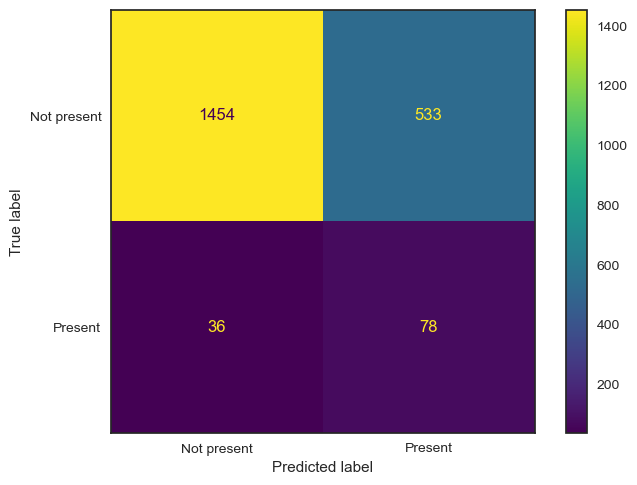

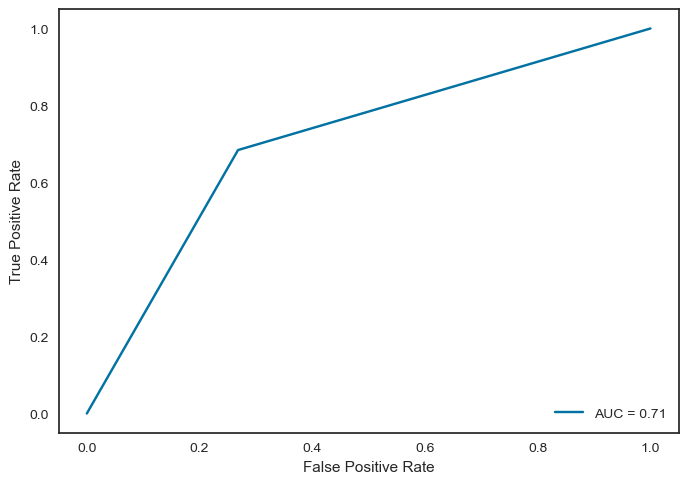

In [292]:
# Scores for Train.csv (test)
sns.set_style('white')
display_scores(gs_smote,X_train_sm,y_train_sm,X_test_sc,y_test)

#### 3.1.1.3 Baseline Logistic Regression model (ADASYN)

In [293]:
%%time

gs_ada = GridSearchCV(lr_pipe, 
                  param_grid=lr_pipe_params,
                  cv=5,
                  verbose = 1,
                  n_jobs=-1,
                  scoring = 'recall'
                 ).fit(X_train_ada, y_train_ada)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.8min finished


Wall time: 9min 34s


In [294]:
pd.DataFrame(gs_ada.cv_results_).sort_values('rank_test_score').head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
22      47.555757     14.688450         0.044944        0.031627   
20      49.896540     11.822417         0.025911        0.006906   
23      38.954882     14.134235         0.047466        0.059151   
21      43.092207     14.849852         0.016778        0.003435   
58      30.799087      7.273863         0.016259        0.009964   

   param_logreg__C param_logreg__class_weight param_logreg__l1_ratio  \
22            3.75              {0: 1, 1: 16}               0.666667   
20            3.75              {0: 1, 1: 16}                    0.0   
23            3.75              {0: 1, 1: 16}                    1.0   
21            3.75              {0: 1, 1: 16}               0.333333   
58            15.0              {0: 1, 1: 16}               0.666667   

   param_logreg__max_iter param_logreg__n_jobs  \
22                   1000                   -1   
20                   1000                   -1   
23                   1000                   -1   
21                   1000                   -1   
58                   1000                   -1   

                                               params  split0_test_score  \
22  {'logreg__C': 3.75, 'logreg__class_weight': {0...           0.767781   
20  {'logreg__C': 3.75, 'logreg__class_weight': {0...           0.767781   
23  {'logreg__C': 3.75, 'logreg__class_weight': {0...           0.767781   
21  {'logreg__C': 3.75, 'logreg__class_weight': {0...           0.767781   
58  {'logreg__C': 15.0, 'logreg__class_weight': {0...           0.766067   

    split1_test_score  split2_test_score  split3_test_score  \
22                1.0           0.997429                1.0   
20                1.0           0.997429                1.0   
23                1.0           0.997429                1.0   
21                1.0           0.997429                1.0   
58                1.0           0.997429                1.0   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
22                1.0         0.953042        0.092636                1  
20                1.0         0.953042        0.092636                1  
23                1.0         0.953042        0.092636                1  
21                1.0         0.953042        0.092636                1  
58                1.0         0.952699        0.093322                5

Accuracy_score(train):0.99
Accuracy_score(test):0.73
MisclassificationRate_score(test):0.27
Recall_score(test):0.68
Specificity_score(test):0.73
Precision_score(test):0.13
F1_score(test):0.22
ROC_AUC_score(test):0.71


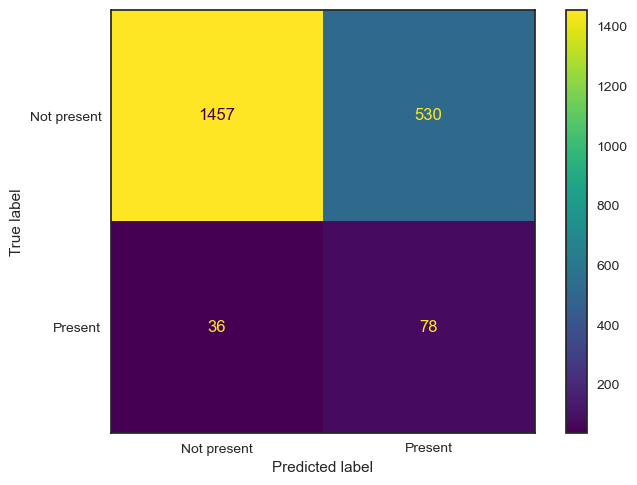

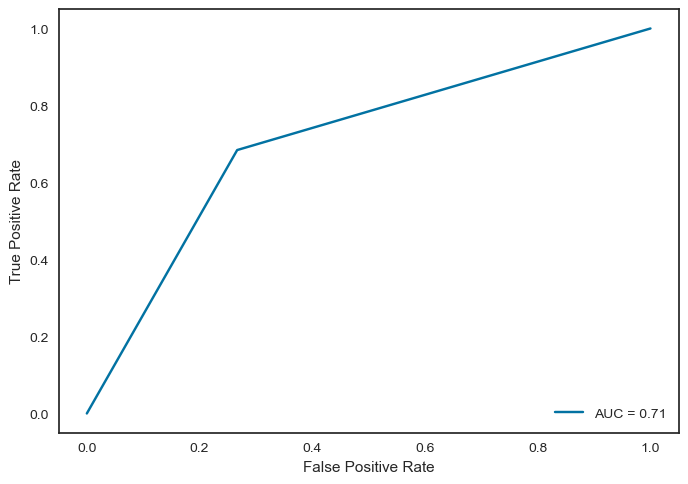

In [295]:
# Scores for Train.csv (test)
sns.set_style('white')
display_scores(gs_ada,X_train_ada,y_train_ada,X_test_sc,y_test)

#### 3.1.1.4 Baseline Logistic Regression model (SVMSMOTE)

In [296]:
%%time

gs_svm = GridSearchCV(lr_pipe, 
                  param_grid=lr_pipe_params,
                  cv=5,
                  verbose = 1,
                  n_jobs=-1,
                  scoring = 'recall'
                 ).fit(X_train_svm, y_train_svm)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.9min finished


Wall time: 9min 36s


In [297]:
pd.DataFrame(gs_svm.cv_results_).sort_values('rank_test_score').head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
23      47.024209      3.012202         0.014999        0.000010   
22      45.941848     10.620968         0.044602        0.048231   
21      33.937523      8.716254         0.021497        0.007461   
20      53.418994     13.803046         0.015522        0.003104   
59      24.033368      3.274654         0.007323        0.013861   

   param_logreg__C param_logreg__class_weight param_logreg__l1_ratio  \
23            3.75              {0: 1, 1: 16}                    1.0   
22            3.75              {0: 1, 1: 16}               0.666667   
21            3.75              {0: 1, 1: 16}               0.333333   
20            3.75              {0: 1, 1: 16}                    0.0   
59            15.0              {0: 1, 1: 16}                    1.0   

   param_logreg__max_iter param_logreg__n_jobs  \
23                   1000                   -1   
22                   1000                   -1   
21                   1000                   -1   
20                   1000                   -1   
59                   1000                   -1   

                                               params  split0_test_score  \
23  {'logreg__C': 3.75, 'logreg__class_weight': {0...           0.789430   
22  {'logreg__C': 3.75, 'logreg__class_weight': {0...           0.789430   
21  {'logreg__C': 3.75, 'logreg__class_weight': {0...           0.789430   
20  {'logreg__C': 3.75, 'logreg__class_weight': {0...           0.789430   
59  {'logreg__C': 15.0, 'logreg__class_weight': {0...           0.781879   

    split1_test_score  split2_test_score  split3_test_score  \
23                1.0                1.0                1.0   
22                1.0                1.0                1.0   
21                1.0                1.0                1.0   
20                1.0                1.0                1.0   
59                1.0                1.0                1.0   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
23                1.0         0.957886        0.084228                1  
22                1.0         0.957886        0.084228                1  
21                1.0         0.957886        0.084228                1  
20                1.0         0.957886        0.084228                1  
59                1.0         0.956376        0.087248                5

Accuracy_score(train):0.99
Accuracy_score(test):0.73
MisclassificationRate_score(test):0.27
Recall_score(test):0.69
Specificity_score(test):0.74
Precision_score(test):0.13
F1_score(test):0.22
ROC_AUC_score(test):0.71


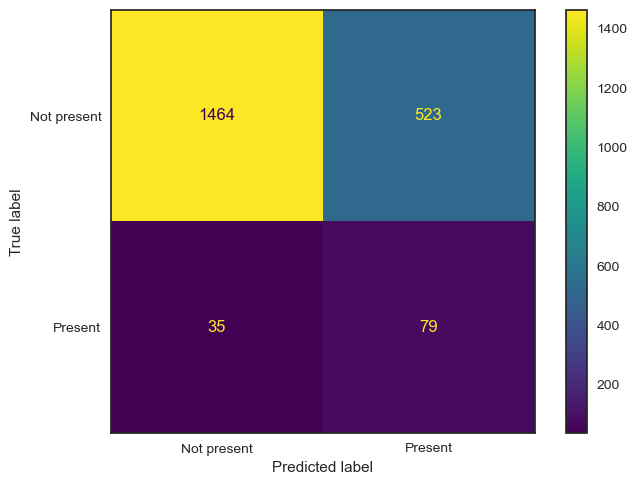

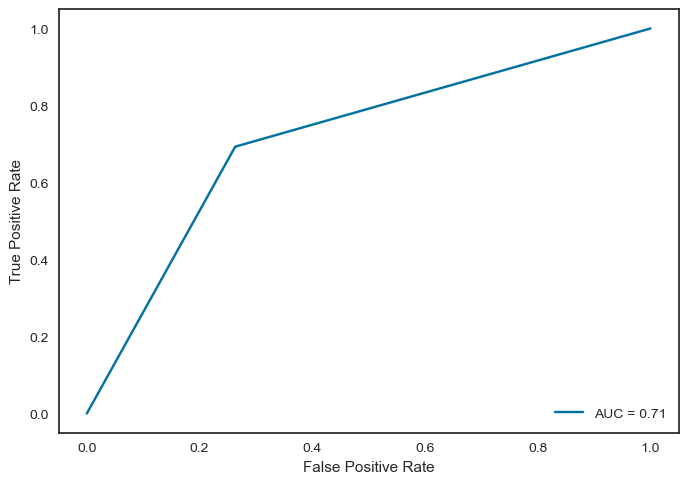

In [298]:
# Scores for Train.csv (test)
sns.set_style('white')
display_scores(gs_svm,X_train_svm,y_train_svm,X_test_sc,y_test)

#### 3.1.1.5 Baseline Logistic Regression model (SMOTENC)

In [299]:
%%time

gs_smnc = GridSearchCV(lr_pipe, 
                  param_grid=lr_pipe_params,
                  cv=5,
                  verbose = 1,
                  n_jobs=-1,
                  scoring = 'recall'
                 ).fit(X_train_smnc, y_train_smnc)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.4min finished


Wall time: 9min 10s


In [300]:
pd.DataFrame(gs_smnc.cv_results_).sort_values('rank_test_score').head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
23      45.627896      5.856107         0.014999        0.000095   
22      45.641812      4.213446         0.022624        0.007299   
21      46.518542      3.859153         0.024512        0.005956   
20      47.509630      6.363371         0.022211        0.004884   
32      46.302498     20.594578         0.034145        0.022003   

   param_logreg__C param_logreg__class_weight param_logreg__l1_ratio  \
23            3.75              {0: 1, 1: 16}                    1.0   
22            3.75              {0: 1, 1: 16}               0.666667   
21            3.75              {0: 1, 1: 16}               0.333333   
20            3.75              {0: 1, 1: 16}                    0.0   
32             7.5              {0: 1, 1: 16}                    0.0   

   param_logreg__max_iter param_logreg__n_jobs  \
23                   1000                   -1   
22                   1000                   -1   
21                   1000                   -1   
20                   1000                   -1   
32                   1000                   -1   

                                               params  split0_test_score  \
23  {'logreg__C': 3.75, 'logreg__class_weight': {0...           0.736577   
22  {'logreg__C': 3.75, 'logreg__class_weight': {0...           0.736577   
21  {'logreg__C': 3.75, 'logreg__class_weight': {0...           0.736577   
20  {'logreg__C': 3.75, 'logreg__class_weight': {0...           0.736577   
32  {'logreg__C': 7.5, 'logreg__class_weight': {0:...           0.735738   

    split1_test_score  split2_test_score  split3_test_score  \
23                1.0                1.0                1.0   
22                1.0                1.0                1.0   
21                1.0                1.0                1.0   
20                1.0                1.0                1.0   
32                1.0                1.0                1.0   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
23                1.0         0.947315        0.105369                1  
22                1.0         0.947315        0.105369                1  
21                1.0         0.947315        0.105369                1  
20                1.0         0.947315        0.105369                1  
32                1.0         0.947148        0.105705                5

Accuracy_score(train):0.99
Accuracy_score(test):0.74
MisclassificationRate_score(test):0.26
Recall_score(test):0.68
Specificity_score(test):0.74
Precision_score(test):0.13
F1_score(test):0.22
ROC_AUC_score(test):0.71


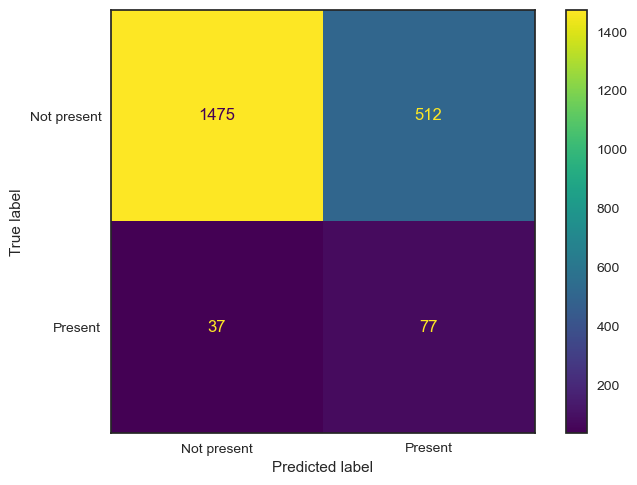

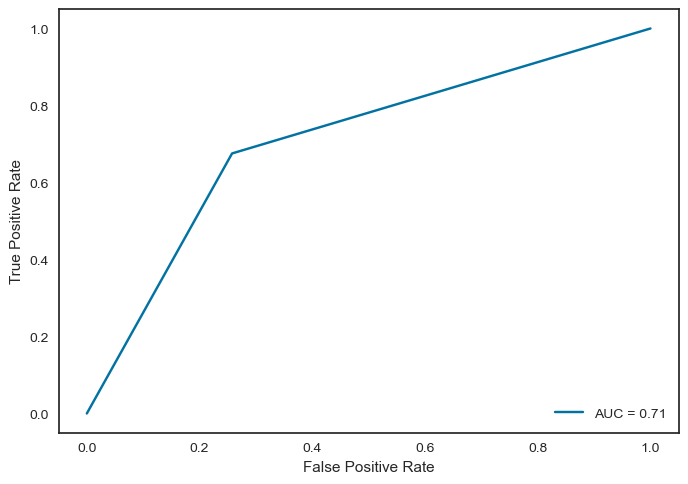

In [301]:
# Scores for Train.csv (test)
sns.set_style('white')
display_scores(gs_smnc,X_train_smnc,y_train_smnc,X_test_sc,y_test)

#### 3.1.1.6 Baseline Logistic Regression model (SMOTENC + PCA)

In [503]:
%%time

gs_pca = GridSearchCV(lr_pipe, 
                  param_grid=lr_pipe_params,
                  cv=5,
                  verbose = 1,
                  n_jobs=-1,
                  scoring = 'precision'
                 ).fit(Z_train, y_train_sm)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.4s finished


Wall time: 3.76 s


In [504]:
pd.DataFrame(gs_pca.cv_results_).sort_values('rank_test_score').head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
50       0.230519      0.004301         0.003706        0.000609   
27       0.140104      0.045881         0.003200        0.000984   
26       0.186278      0.053554         0.003107        0.000674   
25       0.164193      0.051381         0.003236        0.000694   
24       0.116249      0.006751         0.003626        0.000373   

   param_logreg__C param_logreg__class_weight param_logreg__l1_ratio  \
50            15.0                   balanced               0.666667   
27             7.5                   balanced                    1.0   
26             7.5                   balanced               0.666667   
25             7.5                   balanced               0.333333   
24             7.5                   balanced                    0.0   

   param_logreg__max_iter param_logreg__n_jobs  \
50                   1000                   -1   
27                   1000                   -1   
26                   1000                   -1   
25                   1000                   -1   
24                   1000                   -1   

                                               params  split0_test_score  \
50  {'logreg__C': 15.0, 'logreg__class_weight': 'b...           0.753776   
27  {'logreg__C': 7.5, 'logreg__class_weight': 'ba...           0.753776   
26  {'logreg__C': 7.5, 'logreg__class_weight': 'ba...           0.753776   
25  {'logreg__C': 7.5, 'logreg__class_weight': 'ba...           0.753776   
24  {'logreg__C': 7.5, 'logreg__class_weight': 'ba...           0.753776   

    split1_test_score  split2_test_score  split3_test_score  \
50           0.754758           0.756496           0.737579   
27           0.754758           0.756496           0.737579   
26           0.754758           0.756496           0.737579   
25           0.754758           0.756496           0.737579   
24           0.754758           0.756496           0.737579   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
50           0.754801         0.751482        0.007006                1  
27           0.754801         0.751482        0.007006                1  
26           0.754801         0.751482        0.007006                1  
25           0.754801         0.751482        0.007006                1  
24           0.754801         0.751482        0.007006                1

Accuracy_score(train):0.75
Accuracy_score(test):0.73
MisclassificationRate_score(test):0.27
Recall_score(test):0.69
Specificity_score(test):0.74
Precision_score(test):0.13
F1_score(test):0.22
ROC_AUC_score(test):0.71


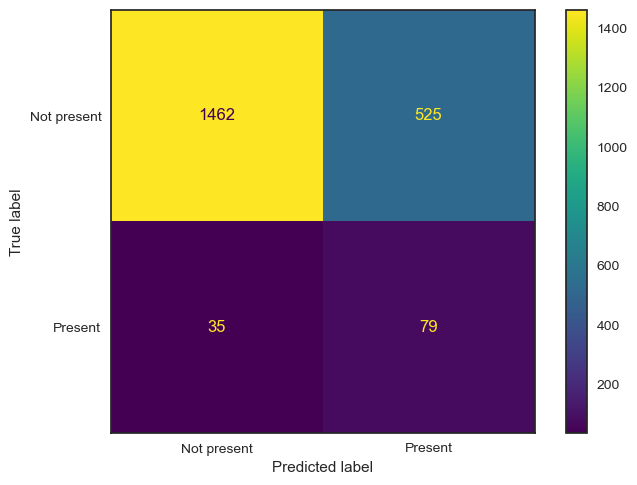

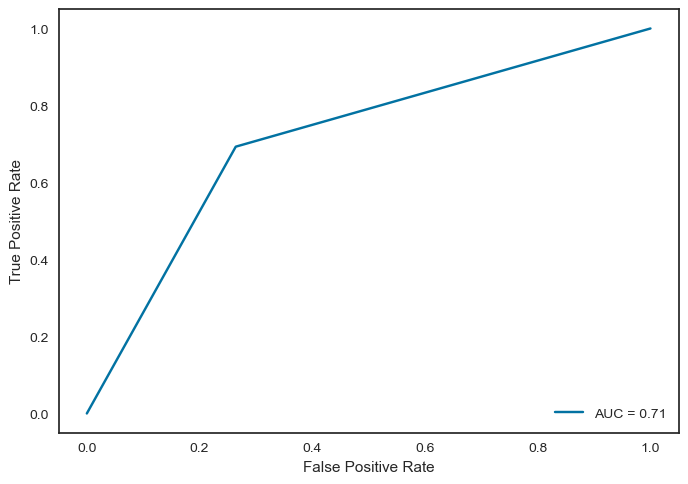

In [505]:
# Scores for Train.csv (test)
sns.set_style('white')
display_scores(gs_pca,Z_train,y_train_sm,Z_test,y_test)

### 3.2.0 Pycaret model

In [305]:
Xpy_train = pd.concat([X_train_smnc, y_train_smnc], axis=1)
Xpy_test = pd.concat([X_test_sc, y_test], axis=1)

In [306]:
numeric_columns = Xpy_train.columns.tolist()
numeric_columns.remove('WnvPresent')

In [307]:
s = setup(data = Xpy_train, target = 'WnvPresent',use_gpu = True, preprocess = False,silent=True ,numeric_features = numeric_columns,fold = 5) 

In [308]:
# Get top performing Models for evaluation
best_model = compare_models(sort = 'AUC')

#### 3.1.2.1 Pycaret model xgboost

In [456]:
%%time
# train model
xgboost = create_model('xgboost')

# tune model
tuned_xgboost = tune_model(xgboost, optimize = 'F1')

Wall time: 1min 15s


In [457]:
evaluate_model(tuned_xgboost)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

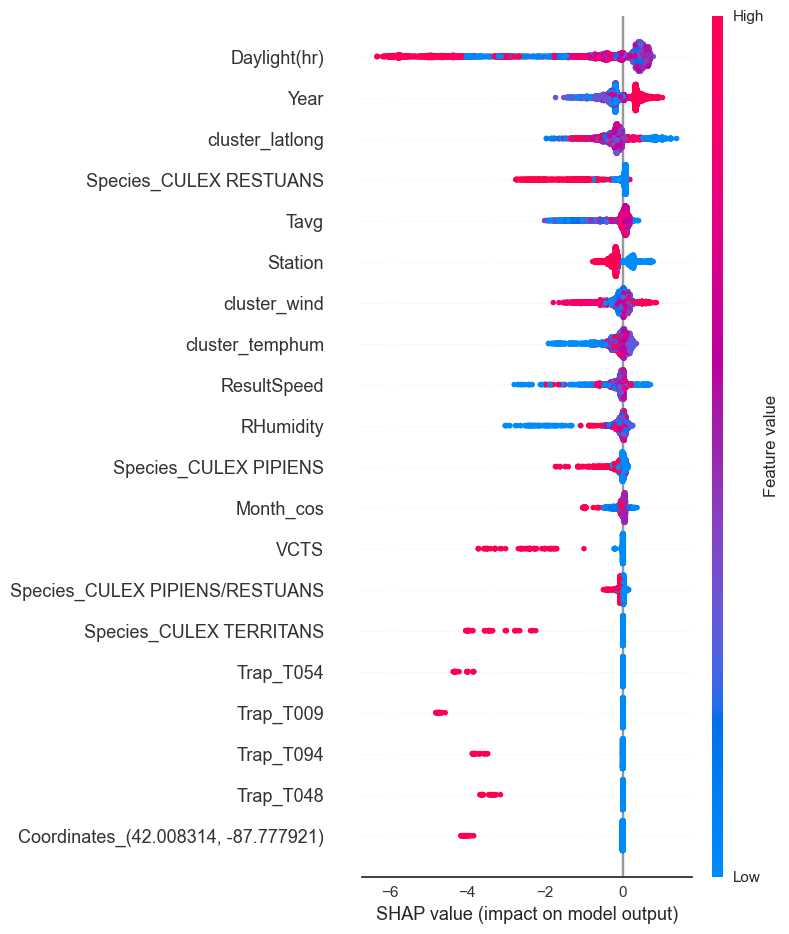

In [458]:
interpret_model(tuned_xgboost)

In [459]:
ypred_tuned_xgboost_HO = predict_model(tuned_xgboost)

Accuracy_score(test):0.74
MisclassificationRate_score(test):0.26
Recall_score(test):0.75
Specificity_score(test):0.74
Precision_score(test):0.14
F1_score(test):0.24
ROC_AUC_score(test):0.74


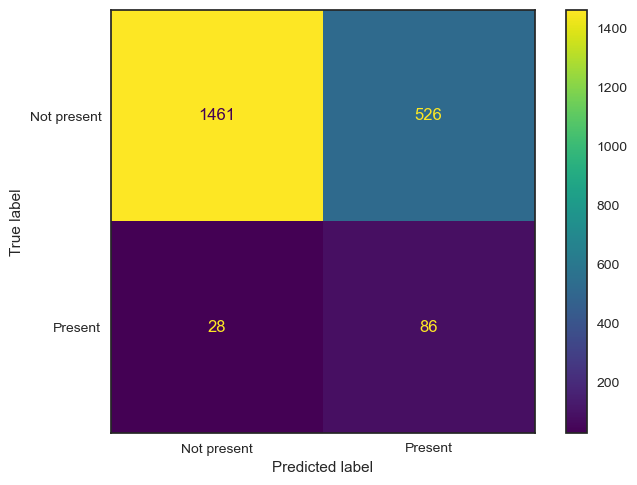

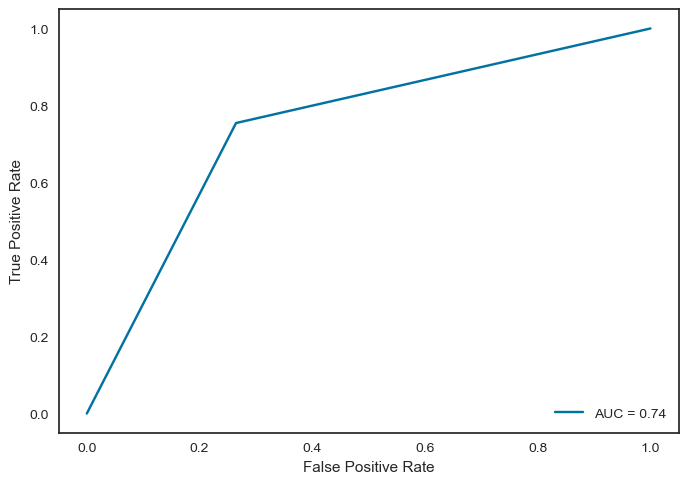

In [460]:
ypred_tuned_xgboost = predict_model(tuned_xgboost, data = Xpy_test )
ypred_xgboost = ypred_tuned_xgboost['Label']
pycaret_get_cm(y_test,ypred_xgboost)

In [ ]:
xgboost_final = finalize_model(tuned_xgboost)

#### 3.1.2.2 Pycaret Extra Trees model

In [315]:
# train model
et = create_model('et')

# tune model
tuned_et = tune_model(et, optimize = 'recall')

In [316]:
evaluate_model(tuned_et)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

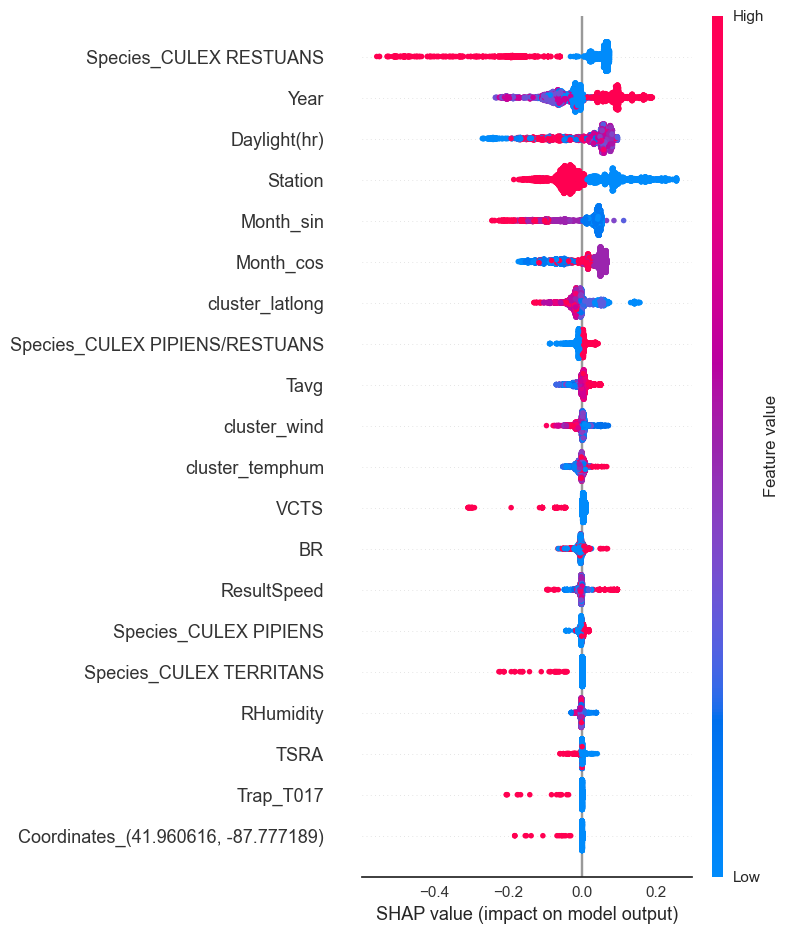

In [317]:
interpret_model(tuned_et)

In [318]:
ypred_tuned_et_HO = predict_model(tuned_et)

Accuracy_score(test):0.78
MisclassificationRate_score(test):0.22
Recall_score(test):0.73
Specificity_score(test):0.78
Precision_score(test):0.16
F1_score(test):0.26
ROC_AUC_score(test):0.76


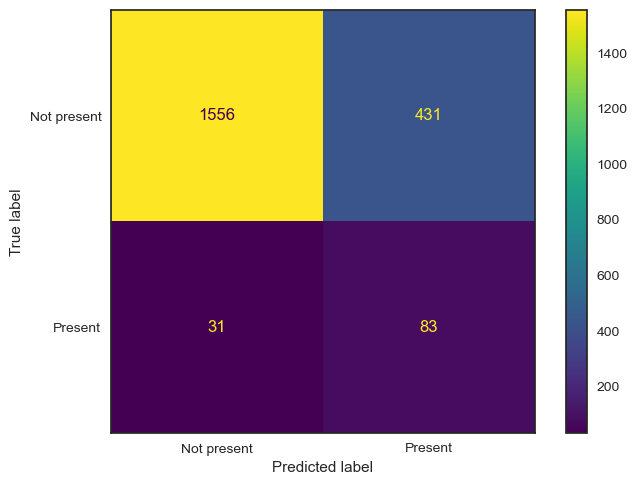

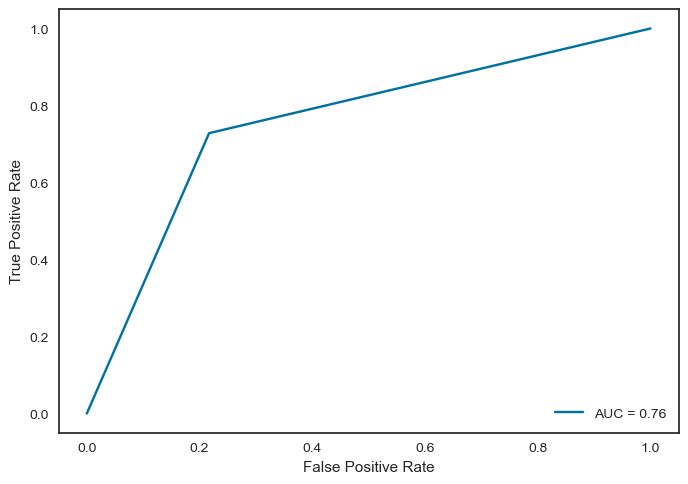

In [319]:
ypred_tuned_et =predict_model(tuned_et, data = Xpy_test )
ypred_et = ypred_tuned_et['Label']
pycaret_get_cm(y_test,ypred_et)

In [320]:
et_final = finalize_model(tuned_et)

#### 3.1.2.3 Pycaret Random Forest model

In [369]:
# train model
rf = create_model('rf')

# tune model
tuned_rf = tune_model(rf, optimize = 'F1')

In [370]:
evaluate_model(tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

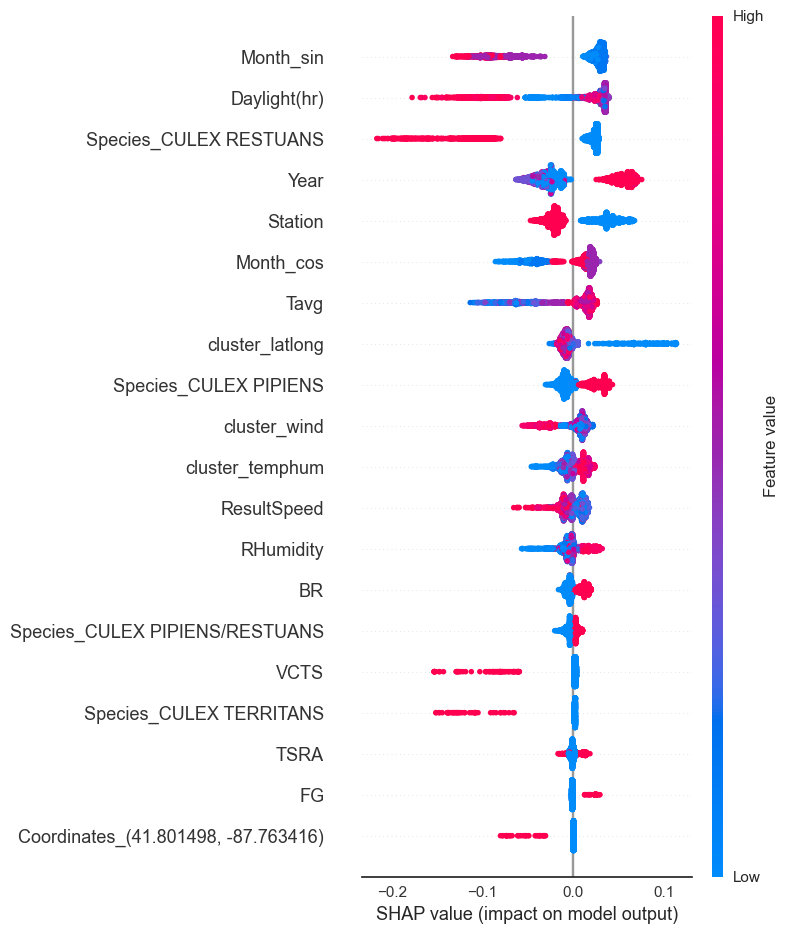

In [371]:
interpret_model(tuned_rf)

In [372]:
ypred_tuned_rf_HO = predict_model(tuned_rf)

Accuracy_score(test):0.79
MisclassificationRate_score(test):0.21
Recall_score(test):0.68
Specificity_score(test):0.80
Precision_score(test):0.16
F1_score(test):0.26
ROC_AUC_score(test):0.74


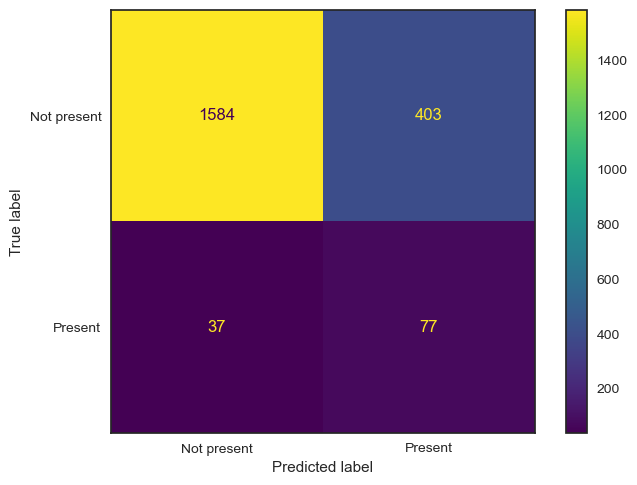

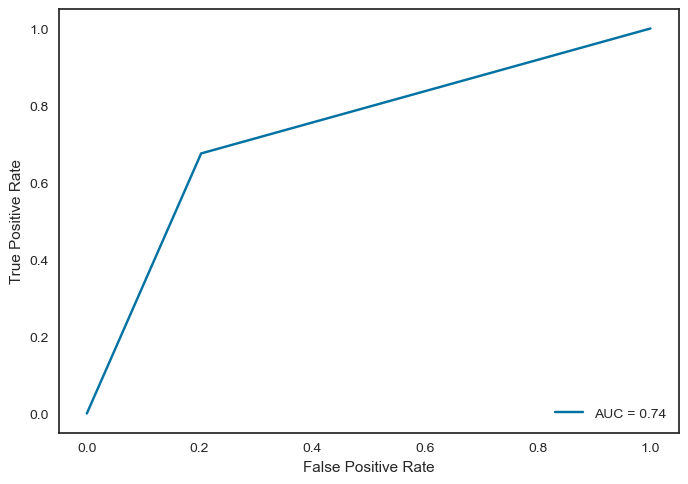

In [373]:
ypred_tuned_rf =predict_model(tuned_rf, data = Xpy_test )
ypred_rf = ypred_tuned_rf['Label']
pycaret_get_cm(y_test,ypred_rf)

In [374]:
rf_final = finalize_model(tuned_rf)

#### 3.1.2.4 Pycaret CatBoost model

In [327]:
# train model
catboost = create_model('catboost')

# tune model
tuned_catboost = tune_model(catboost, optimize = 'Prec.')

In [328]:
evaluate_model(tuned_catboost)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

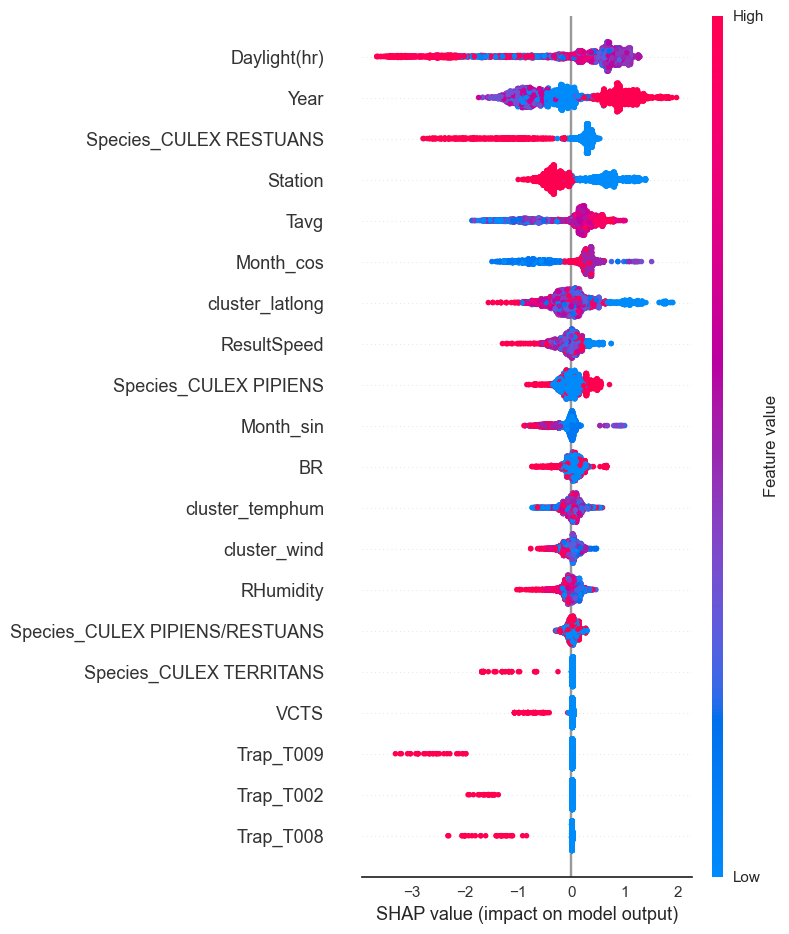

In [329]:
interpret_model(tuned_catboost)

In [330]:
ypred_tuned_catboost_HO = predict_model(tuned_catboost)

Accuracy_score(test):0.90
MisclassificationRate_score(test):0.10
Recall_score(test):0.45
Specificity_score(test):0.92
Precision_score(test):0.25
F1_score(test):0.32
ROC_AUC_score(test):0.68


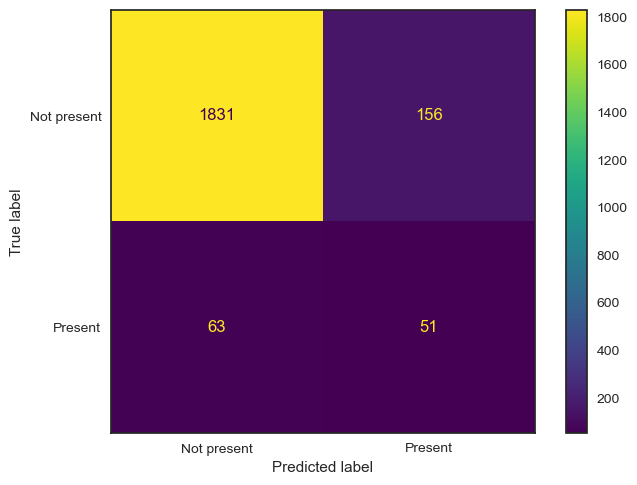

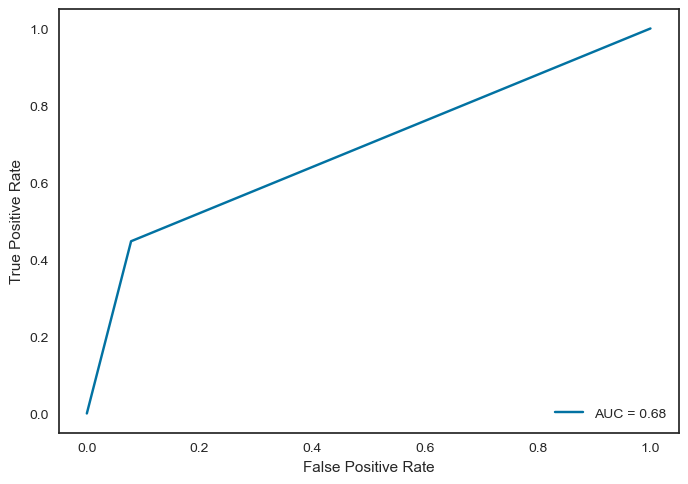

In [331]:
ypred_tuned_catboost =predict_model(tuned_catboost, data = Xpy_test )
ypred_catboost = ypred_tuned_catboost['Label']
pycaret_get_cm(y_test,ypred_catboost)

In [332]:
catboost_final = finalize_model(tuned_catboost)

### Model summary

| Score              | LR no resampling | LR SMOTE resampling | LR ADASYN resampling | LR SVMSMOTE resampling | LR SMOTENC resampling | LR SMOTENC PCA | xgboost | Extra Trees | Random Forest | CatBoost Classifier |
|--------------------|:----------------:|:-------------------:|:--------------------:|:----------------------:|:---------------------:|:--------------:|:-------:|:-----------:|:-------------:|:-------------------:|
| Acc (train)        |       0.87       |         0.99        |         0.99         |          0.99          |          0.99         |      0.75     |   0.85  |     0.86    |      0.86     |         0.95        |   
| Acc (test)         |       0.75       |         0.73        |         0.73         |          0.73          |          0.74         |      0.73      |   0.74  |     0.78    |      0.79     |         0.90         |   
| MisclassRate(test) |       0.25       |         0.27        |         0.27         |          0.27          |          0.26         |      0.27      |   0.26  |     0.22    |      0.21     |         0.10         |   
| Recall (test)      |       0.69       |         0.68        |         0.68         |          0.69          |          0.68         |      0.68      |   0.75  |     0.73    |      0.68     |         0.45        |   
| Spec (test)        |       0.75       |         0.73        |         0.73         |          0.74          |          0.74         |      0.74      |   0.74  |     0.78    |      0.80      |         0.92        |   
| Precision (test)   |       0.14       |         0.13        |         0.13         |          0.13          |          0.13         |      0.13      |   0.14  |     0.16    |      0.16     |         0.25        |   
| F1 (test)          |       0.23       |         0.22        |         0.22         |          0.22          |          0.22         |      0.22      |   0.24  |     0.26    |      0.26     |         0.32        |   
| ROC_AUC (test)     |       0.72       |         0.71        |         0.71         |          0.71          |          0.71         |      0.71      |   0.74  |     0.76    |      0.74     |         0.68        |


**Oversampling techniques**
- SMOTENC was chosen as it works best with Nominal and Continuous features

**From Pycaret Best Models function**
- Random Forest Classifier
- Extra Trees Classifier
- Logistic Regression
- Extreme Gradient Boosting (Self add in)

**Best Model**
- Extra Trees Classifier with 0.76 AUC score


## 4.0.0 Kaggle submission

In [412]:
def get_submission(model,XTest):
    y_preds = pd.DataFrame(model.predict_proba(XTest),columns = ["WnvnotPresent","WnvPresent"])
    y_preds.insert(0, 'Id', range(1, len(XTest)+1))
    y_preds.drop("WnvnotPresent",axis =1,inplace=True)
    return y_preds

In [413]:
et_submission = get_submission(et_final,XTest_sc)

In [414]:
et_submission.to_csv('./Assets/input/et_submission.csv', index=False)

## 5.0.0 Benefit Analysis

### EDA for Cost Benefit Analysis

In [334]:
mapdata = np.loadtxt('./Assets/input/mapdata_copyright_openstreetmap_contributors.txt')

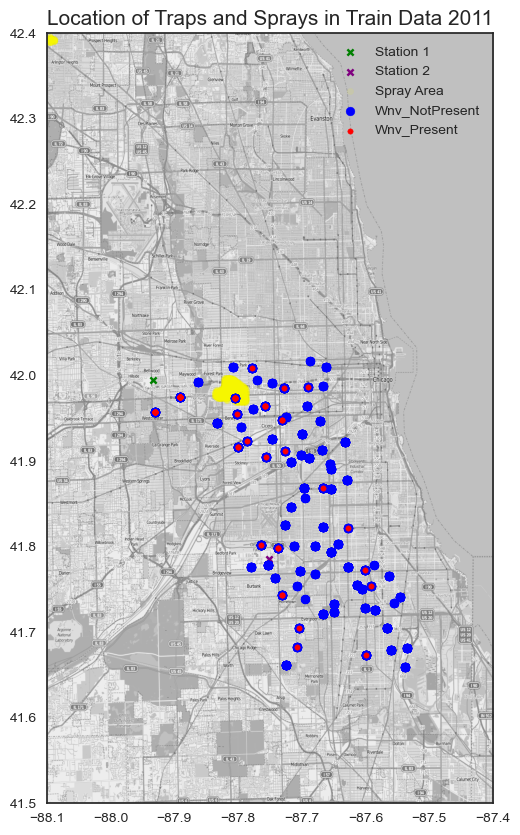

In [335]:
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_boundary = (-88.1, -87.4, 41.5, 42.4)
plt.figure(figsize=(8,10))

plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_boundary, 
           aspect=aspect)

# plot station 1
plt.scatter(-87.933, 
            41.995, 
            c="green", 
            marker='x', 
            s=20, 
            alpha=1, 
            label='Station 1')

# plot station 2
plt.scatter(-87.752, 
            41.786, 
            c="purple", 
            marker='x', 
            s=20, 
            alpha=1, 
            label='Station 2')

spray_2011 = spray_df.loc[spray_df['Year']==2011]

# plot spray area
plt.scatter(spray_2011['Longitude'], 
            spray_2011['Latitude'], 
            c="yellow", 
            s=20, 
            alpha=0.1, 
            label='Spray Area')

# plot locations of traps and instances of WNV cases
wnv = train_merged.loc[(train_merged["WnvPresent"]==1) & (train_merged["Year"] == 2011)]
no_wnv = train_merged.loc[(train_merged["WnvPresent"]==0) & (train_merged["Year"] == 2011)]

# plot no wnv traps
plt.scatter(no_wnv['Longitude'], 
            no_wnv['Latitude'], 
            c="blue", 
            s=40, 
            alpha=1, 
            label='Wnv_NotPresent')

# plot traps with wnv
plt.scatter(wnv['Longitude'], 
            wnv['Latitude'], 
            c="red", 
            s=15, 
            alpha=1, 
            label='Wnv_Present')

plt.title("Location of Traps and Sprays in Train Data 2011", 
          fontsize=15)
plt.legend();

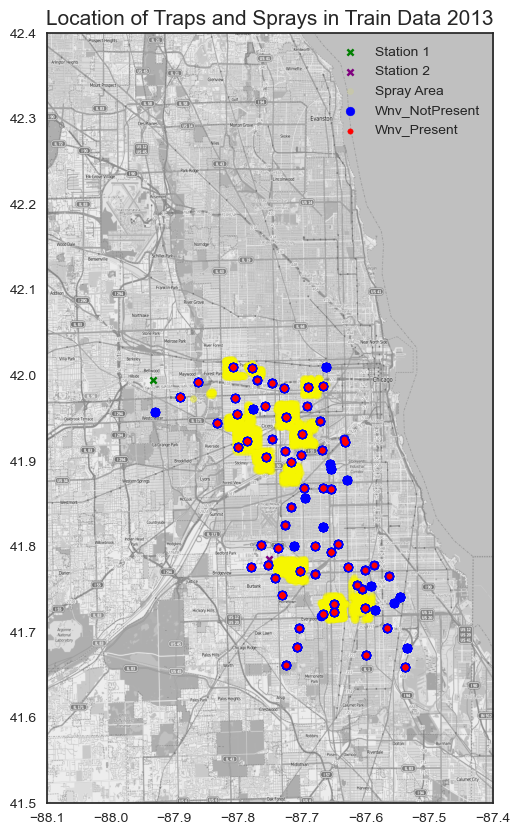

In [336]:
mapdata
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_boundary = (-88.1, -87.4, 41.5, 42.4)
plt.figure(figsize=(8,10))

plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_boundary, 
           aspect=aspect)

# plot station 1
plt.scatter(-87.933, 
            41.995, 
            c="green", 
            marker='x', 
            s=20, 
            alpha=1, 
            label='Station 1')

# plot station 2
plt.scatter(-87.752, 
            41.786, 
            c="purple", 
            marker='x', 
            s=20, 
            alpha=1, 
            label='Station 2')

spray_2013 = spray_df.loc[spray_df['Year']==2013]

# plot spray area
plt.scatter(spray_2013['Longitude'], 
            spray_2013['Latitude'], 
            c="yellow", 
            s=20, 
            alpha=0.1, 
            label='Spray Area')

# plot locations of traps and instances of WNV cases
wnv = train_merged.loc[(train_merged["WnvPresent"]==1) & (train_merged["Year"] == 2013)]
no_wnv = train_merged.loc[(train_merged["WnvPresent"]==0) & (train_merged["Year"] == 2013)]

# plot no wnv traps
plt.scatter(no_wnv['Longitude'], 
            no_wnv['Latitude'], 
            c="blue", 
            s=40, 
            alpha=1, 
            label='Wnv_NotPresent')

# plot traps with wnv
plt.scatter(wnv['Longitude'], 
            wnv['Latitude'], 
            c="red", 
            s=15, 
            alpha=1, 
            label='Wnv_Present')

plt.title("Location of Traps and Sprays in Train Data 2013", 
          fontsize=15)
plt.legend();

In [424]:
cba_pred = pd.DataFrame(et_final.predict(XTest_sc),columns = ["WnvPresent"])
latlongtestyear = test_df[['Latitude','Longitude','Year']]
virus_presence = pd.concat([cba_pred,latlongtestyear],axis =1)

In [438]:
# postive predictions by year (2008)
virus_presence[(virus_presence["WnvPresent"] == 1) & (virus_presence['Year'] == 2008)]["WnvPresent"].count()

7947

In [439]:
# postive predictions by year (2010)
virus_presence[(virus_presence["WnvPresent"] == 1) & (virus_presence['Year'] == 2010)]["WnvPresent"].count()

3722

In [440]:
# postive predictions by year (2012)
virus_presence[(virus_presence["WnvPresent"] == 1) & (virus_presence['Year'] == 2012)]["WnvPresent"].count()

12058

In [441]:
# postive predictions by year (2014)
virus_presence[(virus_presence["WnvPresent"] == 1) & (virus_presence['Year'] == 2014)]["WnvPresent"].count()

8068

In [416]:
cba_pred.value_counts(normalize=True)

WnvPresent
0             0.726596
1             0.273404
dtype: float64

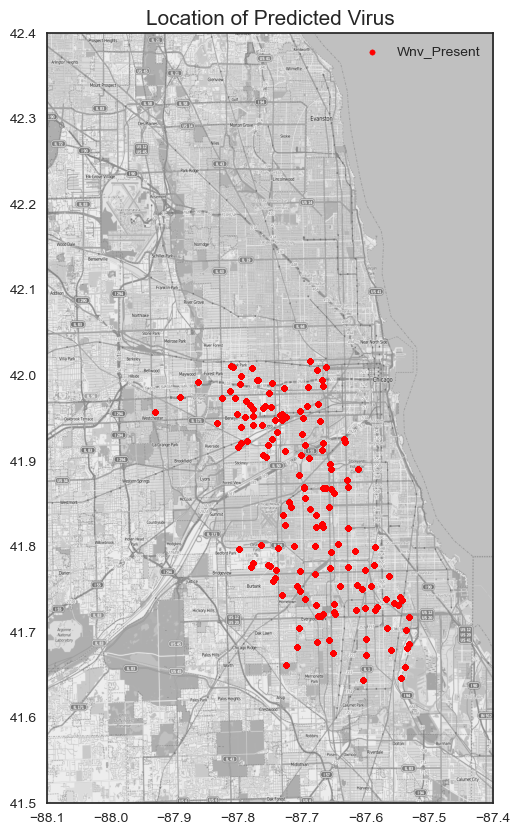

In [411]:
mapdata
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_boundary = (-88.1, -87.4, 41.5, 42.4)
plt.figure(figsize=(8,10))

plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_boundary, 
           aspect=aspect)

# plot locations of instances of WNV cases
wnv = virus_presence.loc[(virus_presence["WnvPresent"]==1)]

# plot traps with wnv
plt.scatter(wnv['Longitude'], 
            wnv['Latitude'], 
            c="red", 
            s=15, 
            alpha=1, 
            label='Wnv_Present')

plt.title("Location of Predicted Virus", 
          fontsize=15)
plt.legend();

In [337]:
# dates of spray
spray_df['Date'].unique()

array(['2011-08-29T00:00:00.000000000', '2011-09-07T00:00:00.000000000',
       '2013-07-17T00:00:00.000000000', '2013-07-25T00:00:00.000000000',
       '2013-08-08T00:00:00.000000000', '2013-08-15T00:00:00.000000000',
       '2013-08-16T00:00:00.000000000', '2013-08-22T00:00:00.000000000',
       '2013-08-29T00:00:00.000000000', '2013-09-05T00:00:00.000000000'],
      dtype='datetime64[ns]')

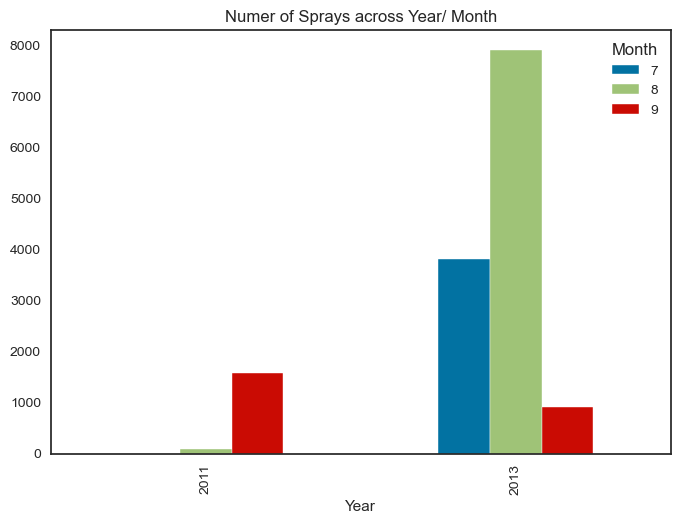

In [338]:
spray_freq_df = spray_df.groupby(['Year','Month']).size().unstack(level=1)
spray_freq_df.plot(kind='bar')
plt.title('Numer of Sprays across Year/ Month');

- Total of 2 dates recorded with spray activity in 2011.
- Total of 8 dates recorded with spray activity in 2013.
- All sprays performed in the same quarter of the year (Jul to Sep) , likely done as such to coincided with the summer period in Chicago.

**2011**

In [339]:
# create trap dataframe for 2011
trap_loc_2011 = train_merged[train_merged['Year']==2011][['Trap','Latitude', 'Longitude']].drop_duplicates()

In [340]:
# Find max and min latitude and longitude for spray area data collected on '2011-09-07'
spray_df[spray_df['Date']=='2011-09-07'][['Latitude', 'Longitude']].describe()

Latitude    Longitude
count  1573.000000  1573.000000
mean     41.982274   -87.809953
std       0.007476     0.012439
min      41.968435   -87.836560
25%      41.976190   -87.819043
50%      41.981745   -87.810398
75%      41.987764   -87.800045
max      41.997028   -87.787710

In [341]:
# Find trap in spray area on 2011-09-07
trap_loc_2011[(trap_loc_2011['Latitude'].between(41.968435, 41.997028))
               & (trap_loc_2011['Longitude'].between(-87.836560, -87.787710))]

Trap   Latitude  Longitude
4706  T223  41.973845 -87.805059

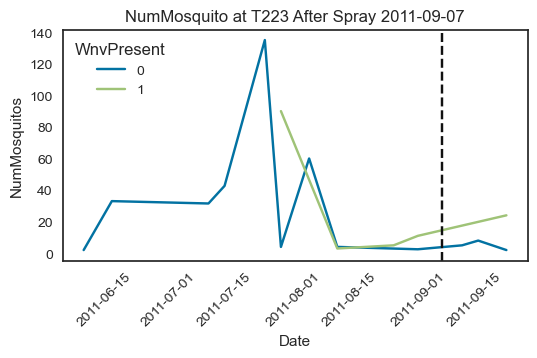

In [342]:
plt.figure(figsize=(6,3))
sns.lineplot(x='Date', 
             y='NumMosquitos',
             hue = 'WnvPresent',
             data=train_merged[(train_merged['Year']==2011) & (train_merged['Trap']=='T223')],
             ci=False)
plt.xticks(rotation=45)
plt.axvline(x=pd.to_datetime('2011-09-07'), color='k', linestyle='--')
plt.title('NumMosquito at T223 After Spray 2011-09-07');

Data Inference:
- The spray  regime in 2011 is ineffective in preventing Wnv as spray only took place after the peak period when mosquito is detected in late July and early Aug.
- No downward trend was observed in the period after the spray was administered.

#### 2013

In [343]:
# create trap dataframe for 2013
trap_loc_2013 = train_merged[train_merged['Year']==2013][['Trap','Latitude', 'Longitude']].drop_duplicates()

In [344]:
# Find max and min latitude and longitude for spray area on '2013-07-17'
spray_df[spray_df['Date']=='2013-07-17'][['Latitude', 'Longitude']].describe()

Latitude    Longitude
count  2202.000000  2202.000000
mean     41.798570   -87.681137
std       0.120172     0.055050
min      41.714098   -87.871023
25%      41.724988   -87.762576
50%      41.732917   -87.654760
75%      41.991582   -87.643375
max      42.015098   -87.629355

In [345]:
# Find trap in spray area on '2013-07-17'
trap_loc_2013[(trap_loc_2013['Latitude'].between(41.714098, 42.015098))
               & (trap_loc_2013['Longitude'].between(-87.871023, -87.629355))]

Trap   Latitude  Longitude
6393   T048  41.867108 -87.654224
6394   T054  41.921965 -87.632085
6395   T002  41.954690 -87.800991
6396   T155  41.776156 -87.778927
6405   T027  41.984809 -87.728492
6406   T009  41.992478 -87.862995
6411   T225  41.743402 -87.731435
6414   T224  41.947227 -87.671457
6415   T226  41.793818 -87.654234
6417   T230  41.904194 -87.756155
6419   T228  41.951866 -87.725057
6421   T035  41.763733 -87.742302
6422   T233  42.009876 -87.807277
6424   T236  41.994679 -87.770899
6425   T223  41.973845 -87.805059
6426   T082  41.803423 -87.642984
6428   T074  41.822536 -87.666343
6429   T159  41.732984 -87.649642
6430   T028  41.986921 -87.689778
6431   T031  41.801498 -87.763416
6432   T033  41.906638 -87.701431
6433   T089  41.723195 -87.649970
6437   T145  41.878114 -87.629798
6438   T151  41.916265 -87.800515
6439   T152  41.846075 -87.716277
6441   T008  42.008314 -87.777921
6442   T012  41.991429 -87.747113
6444   T047  41.868142 -87.696269
6449   T066  41.771660 -87.703047
6450   T062  41.800737 -87.711880
6451   T069  41.768388 -87.678649
6452   T061  41.801179 -87.679447
6454   T030  41.899230 -87.716788
6455   T018  42.010412 -87.662140
6457   T013  41.923738 -87.785288
6459   T094  41.720848 -87.666014
6480   T063  41.825610 -87.726549
6484   T114  41.798697 -87.736812
6492   T232  41.912563 -87.668055
6493   T231  41.987280 -87.666066
6506   T222  41.925198 -87.746381
6517   T003  41.964242 -87.757639
6518   T220  41.963976 -87.691810
6524   T147  41.932094 -87.700117
6528   T090  41.868077 -87.666901
6533   T011  41.944869 -87.832763
6539   T046  41.891118 -87.654491
6549   T043  41.857402 -87.694991
6550   T017  41.960616 -87.777189
6551   T039  41.911824 -87.726737
6555   T065  41.778297 -87.752411
6628   T049  41.896282 -87.655232
6826  T094B  41.719140 -87.669539
7490  T054C  41.925652 -87.633590

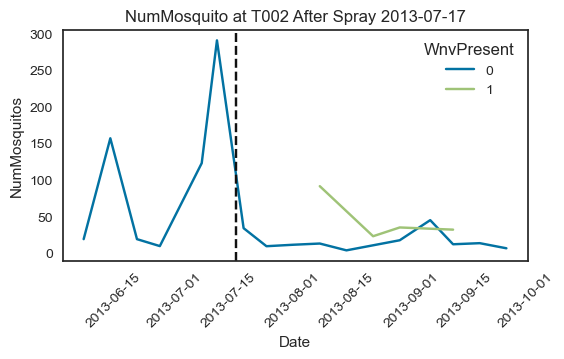

In [346]:
# T002 and T035 are chosen to be plotted as they are in the top 5 recorded traps
plt.figure(figsize=(6,3))
sns.lineplot(x='Date', 
             y='NumMosquitos',
             hue = 'WnvPresent',
             data=train_merged[(train_merged['Year']==2013) & (train_merged['Trap']=='T002')],
             ci=False)
plt.xticks(rotation=45)
plt.axvline(x=pd.to_datetime('2013-07-17'), color='k', linestyle='--')
plt.title('NumMosquito at T002 After Spray 2013-07-17');

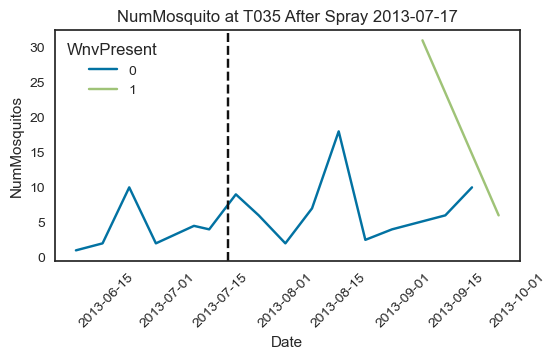

In [347]:
# T002 and T035 are chosen to be plotted as they are in the top 5 recorded traps
plt.figure(figsize=(6,3))
sns.lineplot(x='Date', 
             y='NumMosquitos',
             hue = 'WnvPresent',
             data=train_merged[(train_merged['Year']==2013) & (train_merged['Trap']=='T035')],
             ci=False)
plt.xticks(rotation=45)
plt.axvline(x=pd.to_datetime('2013-07-17'), color='k', linestyle='--')
plt.title('NumMosquito at T035 After Spray 2013-07-17');

In [348]:
# Find max and min latitude and longitude for spray area on 2013-07-25
spray_df[spray_df['Date']=='2013-07-25'][['Latitude', 'Longitude']].describe()

Latitude    Longitude
count  1607.000000  1607.000000
mean     41.954535   -87.722879
std       0.008333     0.008531
min      41.939308   -87.739840
25%      41.947379   -87.730314
50%      41.955607   -87.722537
75%      41.961917   -87.715814
max      41.968097   -87.707987

In [349]:
# Find trap in spray area on 2013-07-25
trap_loc_2013[(trap_loc_2013['Latitude'].between(41.939308, 41.968097))
               & (trap_loc_2013['Longitude'].between(-87.739840, -87.707987))]

Trap   Latitude  Longitude
6419  T228  41.951866 -87.725057

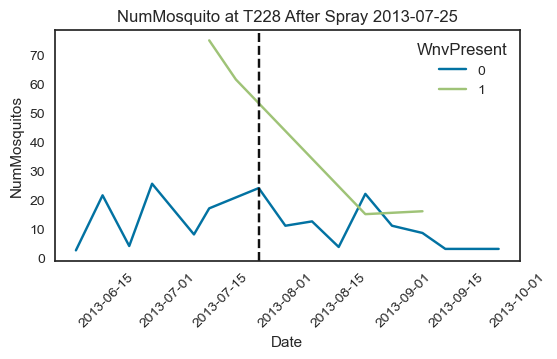

In [350]:
plt.figure(figsize=(6,3))
sns.lineplot(x='Date', 
             y='NumMosquitos',
             hue = 'WnvPresent',
             data=train_merged[(train_merged['Year']==2013) & (train_merged['Trap']=='T228')],
             ci=False)
plt.xticks(rotation=45)
plt.axvline(x=pd.to_datetime('2013-07-25'), color='k', linestyle='--')
plt.title('NumMosquito at T228 After Spray 2013-07-25');

Data Inference:
- In general, sprays performed in Jul 2013 seem to be effective in preventing the grwoth of mosquito. NumMosquito are observed to be trending downwards during the period of spray.

In [351]:
# Find max and min latitude and longitude for spray area on '2013-08-08'
spray_df[spray_df['Date']=='2013-08-08'][['Latitude', 'Longitude']].describe()

Latitude    Longitude
count  1195.000000  1195.000000
mean     41.931466   -87.697035
std       0.008555     0.010608
min      41.917227   -87.716847
25%      41.923121   -87.705352
50%      41.931312   -87.695657
75%      41.938589   -87.689037
max      41.946703   -87.678060

In [352]:
# Find trap in spray area on '2013-08-08'
trap_loc_2013[(trap_loc_2013['Latitude'].between(41.917227, 41.946703))
               & (trap_loc_2013['Longitude'].between(-87.716847, -87.678060))]

Trap   Latitude  Longitude
6524  T147  41.932094 -87.700117

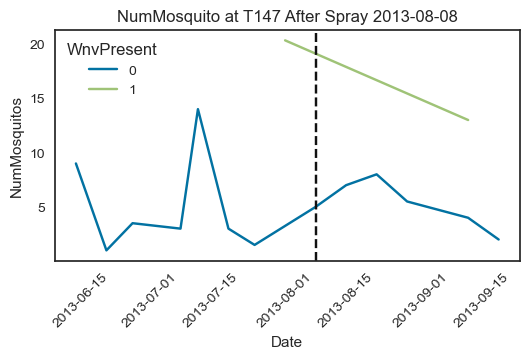

In [353]:
plt.figure(figsize=(6,3))
sns.lineplot(x='Date', 
             y='NumMosquitos',
             hue = 'WnvPresent',
             data=train_merged[(train_merged['Year']==2013) & (train_merged['Trap']=='T147')],
             ci=False)
plt.xticks(rotation=45)
plt.axvline(x=pd.to_datetime('2013-08-08'), color='k', linestyle='--')
plt.title('NumMosquito at T147 After Spray 2013-08-08');

In [354]:
# Find max and min latitude and longitude for spray area on '2013-08-15'
spray_df[spray_df['Date']=='2013-08-15'][['Latitude', 'Longitude']].describe()

Latitude    Longitude
count  2668.000000  2668.000000
mean     41.926007   -87.783171
std       0.019562     0.018831
min      41.887825   -87.818408
25%      41.908333   -87.798794
50%      41.930112   -87.782974
75%      41.942250   -87.768382
max      41.966532   -87.745625

In [355]:
# Find trap in spray area on '2013-08-15'
trap_loc_2013[(trap_loc_2013['Latitude'].between(41.887825	, 41.966532))
               & (trap_loc_2013['Longitude'].between(-87.818408, -87.745625))]

Trap   Latitude  Longitude
6395  T002  41.954690 -87.800991
6417  T230  41.904194 -87.756155
6438  T151  41.916265 -87.800515
6457  T013  41.923738 -87.785288
6506  T222  41.925198 -87.746381
6517  T003  41.964242 -87.757639
6550  T017  41.960616 -87.777189

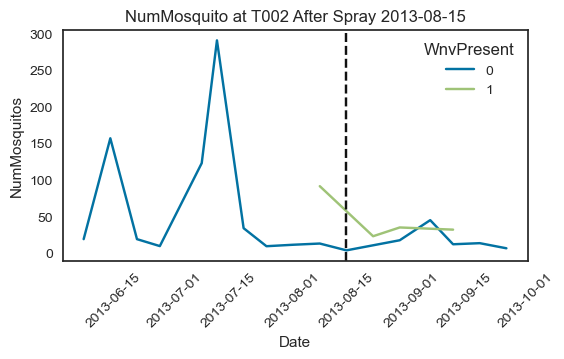

In [356]:
# plot for Trap 'T002'  since this is the second time the spray is performed in its vicinity
plt.figure(figsize=(6,3))
sns.lineplot(x='Date', 
             y='NumMosquitos',
             hue = 'WnvPresent',
             data=train_merged[(train_merged['Year']==2013) & (train_merged['Trap']=='T002')],
             ci=False)
plt.xticks(rotation=45)
plt.axvline(x=pd.to_datetime('2013-08-15'), color='k', linestyle='--')
plt.title('NumMosquito at T002 After Spray 2013-08-15');

In [357]:
# Find max and min latitude and longitude for spray area on '2013-08-29'
spray_df[spray_df['Date']=='2013-08-29'][['Latitude', 'Longitude']].describe()

Latitude    Longitude
count  2302.000000  2302.000000
mean     41.860128   -87.703237
std       0.104671     0.019881
min      41.758812   -87.741315
25%      41.773463   -87.719263
50%      41.782194   -87.700269
75%      41.984902   -87.685353
max      41.997808   -87.660885

In [358]:
# Find trap in spray area on '2013-08-29'
trap_loc_2013[(trap_loc_2013['Latitude'].between(41.758812, 41.997808))
               & (trap_loc_2013['Longitude'].between(-87.741315, -87.660885))]

Trap   Latitude  Longitude
6405  T027  41.984809 -87.728492
6414  T224  41.947227 -87.671457
6419  T228  41.951866 -87.725057
6428  T074  41.822536 -87.666343
6430  T028  41.986921 -87.689778
6432  T033  41.906638 -87.701431
6439  T152  41.846075 -87.716277
6444  T047  41.868142 -87.696269
6449  T066  41.771660 -87.703047
6450  T062  41.800737 -87.711880
6451  T069  41.768388 -87.678649
6452  T061  41.801179 -87.679447
6454  T030  41.899230 -87.716788
6480  T063  41.825610 -87.726549
6484  T114  41.798697 -87.736812
6492  T232  41.912563 -87.668055
6493  T231  41.987280 -87.666066
6518  T220  41.963976 -87.691810
6524  T147  41.932094 -87.700117
6528  T090  41.868077 -87.666901
6549  T043  41.857402 -87.694991
6551  T039  41.911824 -87.726737

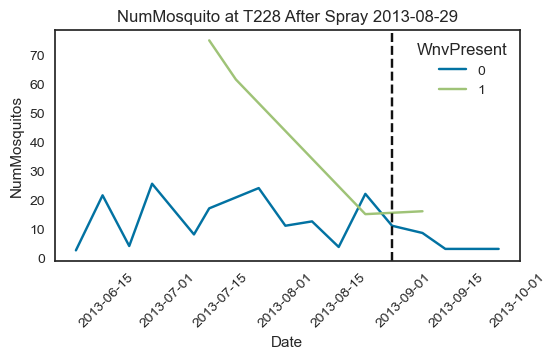

In [359]:
plt.figure(figsize=(6,3))
sns.lineplot(x='Date', 
             y='NumMosquitos',
             hue = 'WnvPresent',
             data=train_merged[(train_merged['Year']==2013) & (train_merged['Trap']=='T228')],
             ci=False)
plt.xticks(rotation=45)
plt.axvline(x=pd.to_datetime('2013-08-29'), color='k', linestyle='--')
plt.title('NumMosquito at T228 After Spray 2013-08-29');

Data Inference:
- Trap T228: Upward trending in NumMosquito was observed approximately within 15 days after the first spray in 25 Jul 2013. This coincided with the life cycle of a mosquito which takes about 10 days from the day it is hatched to become an aduit mosquito. This information can influence the frquency of administering the spray in the same location.
- In general, sprays performed in Aug 2013 seem to be effective in preventing the grwoth of mosquito. NumMosquito are observed to be trending downwards during the period of spray.

In [360]:
# Find max and min latitude and longitude for spray area on '2013-09-05'
spray_df[spray_df['Date']=='2013-09-05'][['Latitude', 'Longitude']].describe()

Latitude   Longitude
count  924.000000  924.000000
mean    42.005436  -87.813085
std      0.009167    0.010006
min     41.976773  -87.846338
25%     42.000493  -87.817065
50%     42.006043  -87.812263
75%     42.012290  -87.808538
max     42.018907  -87.789812

In [361]:
# Find trap in spray area on '2013-09-05'
trap_loc_2013[(trap_loc_2013['Latitude'].between(41.976773, 42.018907))
               & (trap_loc_2013['Longitude'].between(-87.846338, -87.789812))]

Trap   Latitude  Longitude
6422  T233  42.009876 -87.807277

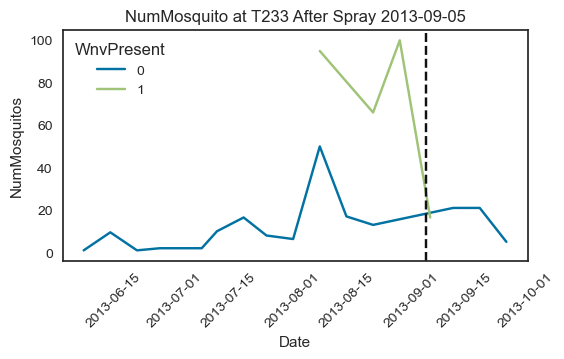

In [362]:
plt.figure(figsize=(6,3))
sns.lineplot(x='Date', 
             y='NumMosquitos',
             hue = 'WnvPresent',
             data=train_merged[(train_merged['Year']==2013) & (train_merged['Trap']=='T233')],
             ci=False)
plt.xticks(rotation=45)
plt.axvline(x=pd.to_datetime('2013-09-05'), color='k', linestyle='--')
plt.title('NumMosquito at T233 After Spray 2013-09-05');

Data Inference
- In general, sprays performed in Aug 2013 seem to be effective in preventing the grwoth of mosquito. NumMosquito are observed to be trending downwards during the period of spray.
- There is a general decline in NumMosquito observed in traps in the vicinity of the spray after the sprays are administered. It can be inferred that sprays are effective in controllng mosquito counts.

### Details of Cost Benefit Analysis

#### By Total Coverage

Size of Chicago City is 150,100 acres ([*source*](https://en.wikipedia.org/wiki/Chicago)). We will assume that the cost associated with the mosquito control involves adminstering of adulticide to cover the entire land area (full 100% coverage) in Chicago.

The material being used to control the adult mosquitoes, Zenivex™, will be applied at a rate of 1.5 fluid ounces per acre ([*source*](https://abc7chicago.com/archive/9206273/)) at a cost of 67 cents per acre ([*source*](https://www.centralmosquitocontrol.com/-/media/files/centralmosquitocontrol-na/us/resources-lit%20files/zenivex%20cost%20comparison%20fact%20sheet.pdf))

Cost of Spray (once per quarter) = 150100 * 0.67 = US$100,567

In the event that spay is performed thrice per year ([*source*](https://www.centralmosquitocontrol.com/-/media/files/centralmosquitocontrol-na/us/resources-lit%20files/zenivex%20cost%20comparison%20fact%20sheet.pdf)), cost of spray = 3 x USD100,507 x 3 = USD301,701

#### By Trap Coverage
- Zenivex For best results, apply perpendicular to the wind direction using a swath width of 300 ft ([*source*](https://www.centralmosquitocontrol.com/-/media/files/centralmosquitocontrol-na/us/specimen%20labels/zenivex%20e20%20specimen%20label.pdf))
In order to ensure sufficient coverage of the pesticide which is predicted to have WnvPresent, 

- Based on our modelling result there are a total of 12058 counts of positive predictions in 2012. Since this is the highest counts of positive observations (using test.csv dataset) reported in a single year, we will use this to calculate the cost of spraying selectively/

In [42]:
# recommended spray coverage (in sq ft)
spray_area = 3.142 *300 *300
spray_area

282780.0

In [43]:
# recommended spray coverage (in acre)
acre_spray_area = spray_area *2.2957/100000
acre_spray_area

6.491780459999999

In [44]:
# cost of spray to cover one trap predicted to have WnvPresent
acre_spray_area*0.67

4.3494929082

In [47]:
# spray cost (per year), selectively spray based on our prediction (positive prediction)
cost_optimised = 4.3494929082 * 12058 
cost_optimised

52446.1854870756

The cost incurred when spray is administered based on our predicted site is USD52,446. This is significantly lower than the cost to administer spray in the entire Chicago state, thrice per year.

#### Other Costs

**Health**

Most people (8 out of 10 ([*source*](https://www.cdc.gov/westnile/symptoms/index.html#:~:text=About%201%20in%205%20people,symptoms%20in%20a%20few%20people)) who are infected have a minor illness and recover fully. But, older people and those with weak immune systems are more likely to get a serious illness from the infection. 

Personnel who get serious illness may need to be hospitalised and substantial cost may be incurred to treat patient with severe illness. The high price tag comes mostly from the treatment of people who develop serious neurological problems when the virus infects the nerves. In these cases, West Nile can cause seizures, coma, paralysis of limbs, swelling in the brain or spinal cord (encephalitis and meningitis) and even death. It was reported that around USD800 million was incurred to treat 37,000 WNV patient since Year 1999 in US. This works out to approximately USD21,000 per patient ([*source*](https://www.npr.org/sections/health-shots/2014/02/11/275262857/the-high-cost-of-treating-people-hospitalized-with-west-nile-virus))
Since the cost incurred on the spray programme is approximately USD301,701 per annum (worst case), it would mean that prevention of 15 cases of WNV would make the spray programme in Chicago cost effective.

**Workforce and Productivity**

Furthermore, in addition to the health and medical impact, cases who develop symptoms may have to be absent from work and this will affect the state's workforce productivity.The average annual salary in Chicago is USD73,119 ([*source*](https://www.ziprecruiter.com/Salaries/-in-Chicago,IL)), which works out to USD281 for each man-day loss due to West Nile.

Since the cost incurred on the spray programme is approximately USD301,701 per annum,it would mean that prevention of 358 cases of WNV would make the spray programme in Chicago cost effective (assuming 3 days absence from work due to WNV).

## 6.0.0 Conclusion

- Highest count of mosquito in Jul and Aug period, which coincides with the period of the highest precipitation (PrecipTotal), relative humidity (RHumidity) and temperature (Tavg).
- Extra Trees model is selected as our best model.
- Based on the model, the top dominant features identified by the best model are:
    1) Species CULEX RESTAUNS
    2) Daylight(hr)
    3) Year
    4) Month_sin & Month_cos (Cyclical Features Months)
    5) Station
    6) Cluster Lat / Long
    7) Wind Result Speed
    8) Cluster for wind Result Speed & wind Result Direction
    9) Cluster temperature / RHumidity
- Spraying pesticide is an effective mean for mosquito control and prevention of the West Nile Virus. 

## 7.0.0 Recommendation

- To enhance the effectiveness of the spray, the spray regime should take into consideration the following
1. Life cycle of a Culex species mosquito. Since it will take 7 to 10 days for an egg to develop into an adult mosquito, the spray should be performed in the same location every 7 to 10 days.
2. Weather. Based on historical data, mosquito thrives best under hot, humid and rainy condition. Higher spray frequency can be planned and performed during such weather condition.
3. To augment existing spray regime with larvicide regime as a means to limit mosquito breeding and reduce the adult mosquito population density ([*source*](https://www.chicago.gov/dam/city/depts/cdph/comm_dis/general/Communicable_Disease/CD_CDInfo_Jun07_WNV.pdf))

**Limitation**

1) Limited to Chicago predictions
2) Datasets are from year 2007 - 2014
3) Limited to 7 species of mosquito located in Chicago